In [24]:
import time

import numpy as np
import pandas as pd
import datetime as dt
import xgboost as xgb

from itertools import combinations

from sklearn import metrics
from sklearn.model_selection import ShuffleSplit,StratifiedShuffleSplit, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.svm import SVR

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
def rmsle(h, y):
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

def rmsle_xgb(preds, dtrain):
    labels = dtrain.get_label()
    rmsle_score =rmsle(preds, labels)
    return 'rmsle', rmsle_score

In [5]:
df_train = pd.read_csv("../data/train_new.csv")
df_test = pd.read_csv("../data/test_new.csv")

In [6]:
test_id = df_test.id.values

In [7]:
features = list(set(df_train.columns.tolist()) - set(['formation_energy_ev_natom',
                                                'bandgap_energy_ev', 
                                                'id',
                                                'lattice_angle_alpha_degree_r',
                                                'lattice_angle_beta_degree_r',
                                                'lattice_angle_alpha_degree_r']))
targets = ['formation_energy_ev_natom', 'bandgap_energy_ev']

y_e = np.log(df_train['formation_energy_ev_natom'].values +1)
y_be = np.log(df_train['bandgap_energy_ev'].values +1)

y_e_s = np.sqrt(df_train['formation_energy_ev_natom'].values +0.5)
y_be_s = np.sqrt(df_train['bandgap_energy_ev'].values +0.5)

scaler_e = MinMaxScaler().fit(y_e.reshape(-1, 1))
y_e = scaler_e.transform(y_e.reshape(-1, 1)).flatten()

scaler_be = MinMaxScaler().fit(y_be.reshape(-1, 1))
y_be = scaler_be.transform(y_be.reshape(-1, 1)).flatten()

dist_features = [x for x in df_train.columns.tolist() if x.startswith('dist')]
path_features = [x for x in df_train.columns.tolist() if x.startswith('path')]
angle_features = [x for x in df_train.columns.tolist() if x.startswith('angle')]
dihedral_features = [x for x in df_train.columns.tolist() if x.startswith('dihedral')]
percent_features = [x for x in df_train.columns.tolist() if x.startswith('percent')]
avg_features = [x for x in df_train.columns.tolist() if x.startswith('avg')]
lattice_angle_features = [x for x in df_train.columns.tolist() if x.startswith('lattice_angle')]


FE_features =['lattice_angle_alpha_degree',
             'lattice_angle_gamma_degree',
             'vol',
             'atomic_density',
             'lattice_vector_1_ang',
             'lattice_vector_2_ang',
             'lattice_vector_3_ang']+avg_features+dihedral_features+angle_features+percent_features+path_features+dist_features



## Calculating Formation energy

In [36]:
params = {
    'objective': 'reg:linear',
    'max_depth': 5,
    'subsample': 0.75,
    'eta': 0.1, #0.028084362074445819, #0.025
    'gamma':0.01,
    'nthreads': 12,
    #'tree_method': 'gpu_hist',
    }


In [37]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['formation_energy_ev_natom'] = np.zeros_like(test_id)

In [38]:
features_fe_ = ['lattice_vector_2_ang',
 'avg_IP',
 'lattice_vector_3_ang',
 'percent_atom_in',
 'percent_atom_al',
 'lattice_angle_alpha_degree',
 'avg_electronegativity',
 'avg_LUMO',
 'avg_rd_max',
 'avg_rp_max',
 'atomic_density',
 'lattice_vector_1_ang',
 'vol',
 'avg_EA',
 'dihedral_112',
 'dihedral_60',
 'dihedral_94',
 'avg_rs_max',
 'dihedral_2',
 'avg_HOMO',
 'dihedral_7',
 'dihedral_0',
 'dist_8',
 'dihedral_174',
 'lattice_angle_gamma_degree']

In [69]:
features_fe = ['lattice_angle_alpha_degree',
               'lattice_angle_gamma_degree',
               'number_of_total_atoms',
               'vol',
               'atomic_density',
               'lattice_vector_1_ang',
               'lattice_vector_2_ang',
               'lattice_vector_3_ang']+avg_features+percent_features+dist_features+angle_features

X = df_train[features_fe].values
X_test = df_test[features_fe].values
y_e = np.log(df_train['formation_energy_ev_natom'].values +1)

t = time.time()

kfold = 5

sscv = ShuffleSplit(n_splits=5, test_size=.2)
vscores = []
for i, (train_index, test_index) in enumerate(sscv.split(X, y_e)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y_e[train_index], y_e[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(X_test)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params,
                    d_train,
                    1600,
                    watchlist,
                    early_stopping_rounds=70,
                    feval=rmsle_xgb,
                    maximize=False,
                    verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    vscores.append(mdl.best_score)
    
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)

    sub['formation_energy_ev_natom'] += ((np.exp(p_test)-1)/kfold)

    
print()
print('this took {}-seconds with a mean validation rmsle of {}'.format(time.time()-t, np.mean(vscores)))

[Fold 1/5]
[0]	train-rmse:0.309148	valid-rmse:0.311007	train-rmsle:0.240443	valid-rmsle:0.242193
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 70 rounds.
[100]	train-rmse:0.027006	valid-rmse:0.032528	train-rmsle:0.022344	valid-rmsle:0.026954
Stopping. Best iteration:
[108]	train-rmse:0.027003	valid-rmse:0.032521	train-rmsle:0.02234	valid-rmsle:0.026946

[Fold 1/5 Prediciton:]
[Fold 2/5]
[0]	train-rmse:0.308345	valid-rmse:0.313951	train-rmsle:0.239797	valid-rmsle:0.244577
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 70 rounds.
[100]	train-rmse:0.027888	valid-rmse:0.029475	train-rmsle:0.023084	valid-rmsle:0.024596
[200]	train-rmse:0.027508	valid-rmse:0.029375	train-rmsle:0.022762	valid-rmsle:0.024508
Stopping. Best iteration:
[169]	train-rmse:0.027571	valid-rmse:0.029252	train-rmsle:0.022818	valid-rmsle:0.0243

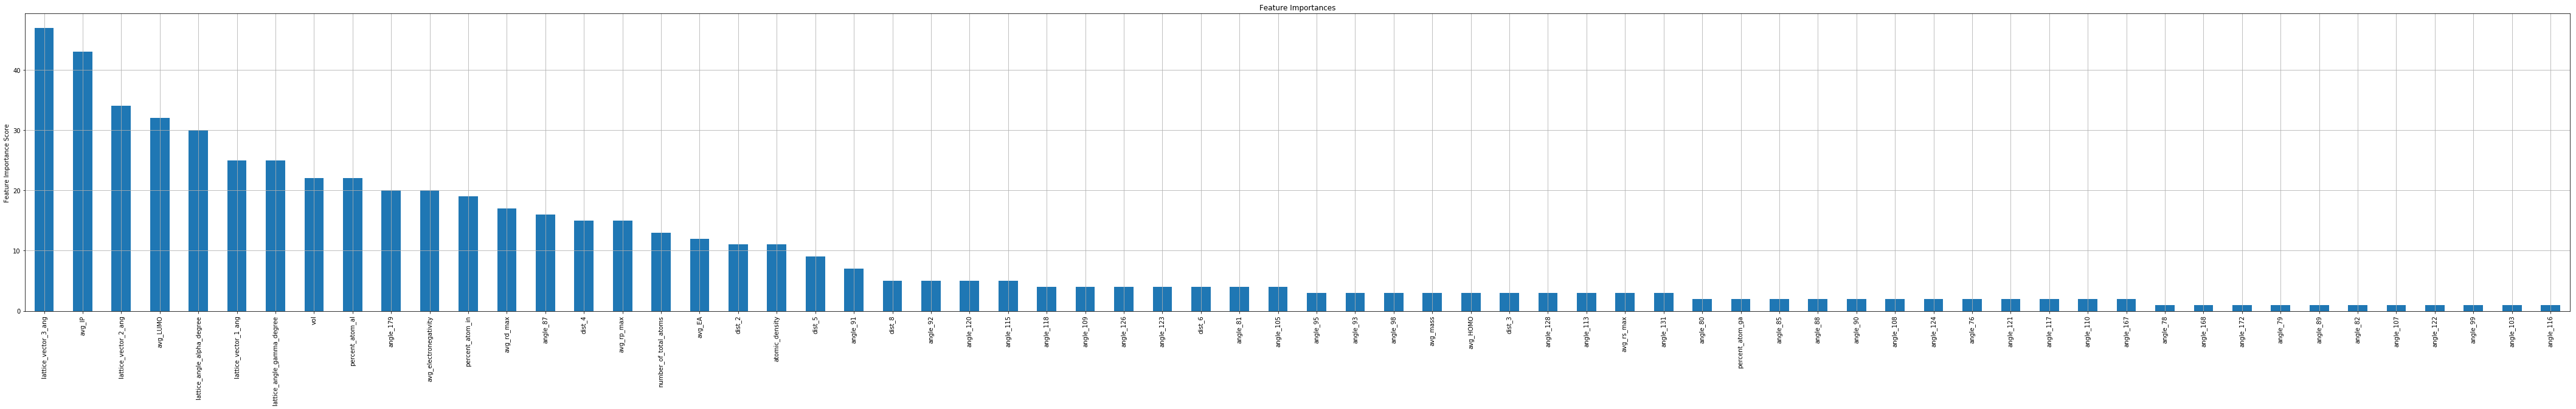

In [70]:
feat_imp = pd.Series(mdl.get_fscore()).sort_values(ascending=False)
feat_imp.rename(index={i:features_fe[int(i[1:])] for i in feat_imp.index.tolist()}, inplace=True)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(75,9))
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()


In [95]:
params = {'objective': 'reg:logistic',
    'max_depth': 3,
    'subsample': 0.87,
    'eta': 0.02, 
    'gamma': 0.05,
    'nthreads': 12}



In [15]:
sub['bandgap_energy_ev'] = np.zeros_like(test_id)

features_be = ['lattice_angle_alpha_degree',
               'lattice_angle_gamma_degree',
               'lattice_angle_gamma_degree',
               'number_of_total_atoms',
               'vol',
               'atomic_density',
               'lattice_vector_1_ang',
               'lattice_vector_2_ang',
               'lattice_vector_3_ang']+avg_features+percent_features+dist_features

X = df_train[features_be].values
X_test = df_test[features_be].values
y_be = np.log(df_train['bandgap_energy_ev'].values +1)

scaler_be = MinMaxScaler().fit(y_be.reshape(-1, 1))
y_be = scaler_be.transform(y_be.reshape(-1, 1)).flatten()

t = time.time()

kfold = 11
sscv = KFold(n_splits=kfold, shuffle=False, random_state=42)
vscores = []
for i, (train_index, test_index) in enumerate(sscv.split(X, y_be)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y_be[train_index], y_be[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(X_test)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params,
                    d_train,
                    1600,
                    watchlist,
                    early_stopping_rounds=70,
                    feval=rmsle_xgb,
                    maximize=False,
                    verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    vscores.append(mdl.best_score)
    
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    p_test = scaler_be.inverse_transform(p_test.reshape(-1, 1)).flatten()
    sub['bandgap_energy_ev'] += ((np.exp(p_test)-1)/kfold)

    
print()
print('this took {}seconds with a mean validation rmsle of {}'.format(time.time()-t, np.mean(vscores)))

[Fold 1/11]
[0]	train-rmse:0.1805	valid-rmse:0.175554	train-rmsle:0.113966	valid-rmsle:0.109195
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 70 rounds.
[100]	train-rmse:0.032348	valid-rmse:0.044261	train-rmsle:0.022808	valid-rmsle:0.029883
Stopping. Best iteration:
[95]	train-rmse:0.03283	valid-rmse:0.04398	train-rmsle:0.023165	valid-rmsle:0.029706

[Fold 1/11 Prediciton:]
[Fold 2/11]
[0]	train-rmse:0.180945	valid-rmse:0.171669	train-rmsle:0.114073	valid-rmsle:0.108535
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 70 rounds.
[100]	train-rmse:0.031938	valid-rmse:0.049698	train-rmsle:0.022497	valid-rmsle:0.034662
Stopping. Best iteration:
[108]	train-rmse:0.03138	valid-rmse:0.049427	train-rmsle:0.022086	valid-rmsle:0.034413

[Fold 2/11 Prediciton:]
[Fold 3/11]
[0]	train-rmse:0.180169	valid-rmse:0.179275	train-

In [ ]:
this took 529.2393972873688seconds with a mean validation rmsle of 0.03249763636363637

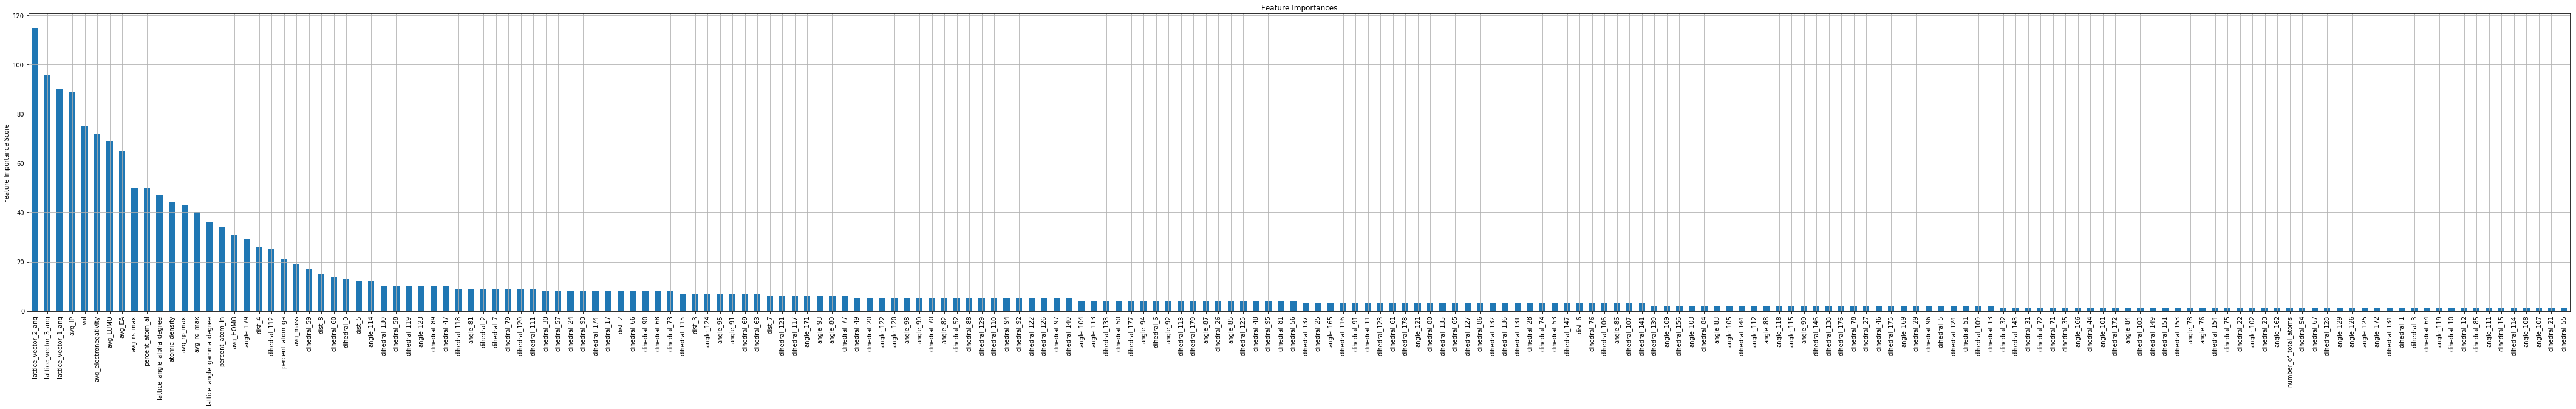

In [11]:
feat_imp = pd.Series(mdl.get_fscore()).sort_values(ascending=False)
feat_imp.rename(index={i:features_fe[int(i[1:])] for i in feat_imp.index.tolist()}, inplace=True)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(75,9))
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()


## Predicting bandgap energy

In [16]:
features_be = ['lattice_vector_1_ang',
               'lattice_vector_2_ang',
               'lattice_vector_3_ang']
X_be = df_train[features_be]
X_test_be = df_test[features_be]
frames = [X_be, X_test_be]
result = pd.concat(frames)

result = StandardScaler().fit_transform(result)
db = DBSCAN(eps=0.14, min_samples=10).fit(result)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
labels = db.labels_
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(result, labels))

Estimated number of clusters: 11
Silhouette Coefficient: 0.693


In [17]:
train_labels = labels[:2400]
test_labels = labels[2400:]

In [18]:
df_train['cluster'] = train_labels
df_test['cluster'] = test_labels

--------------------------------------
cluster: 0
--------------------------------------
[Fold 1/3]
[0]	train-rmse:0.191452	valid-rmse:0.196211	train-rmsle:0.142735	valid-rmsle:0.147284
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.017613	valid-rmse:0.033357	train-rmsle:0.01346	valid-rmsle:0.024547
[200]	train-rmse:0.017001	valid-rmse:0.033262	train-rmsle:0.012974	valid-rmsle:0.024441
Stopping. Best iteration:
[143]	train-rmse:0.01721	valid-rmse:0.033159	train-rmsle:0.01314	valid-rmsle:0.024378

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-rmse:0.194239	valid-rmse:0.189929	train-rmsle:0.145414	valid-rmsle:0.141398
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.017398	valid-rmse:0.037944	train-rmsle:0.013188	valid-rmsle:0.028248
Stopping. Best iterati

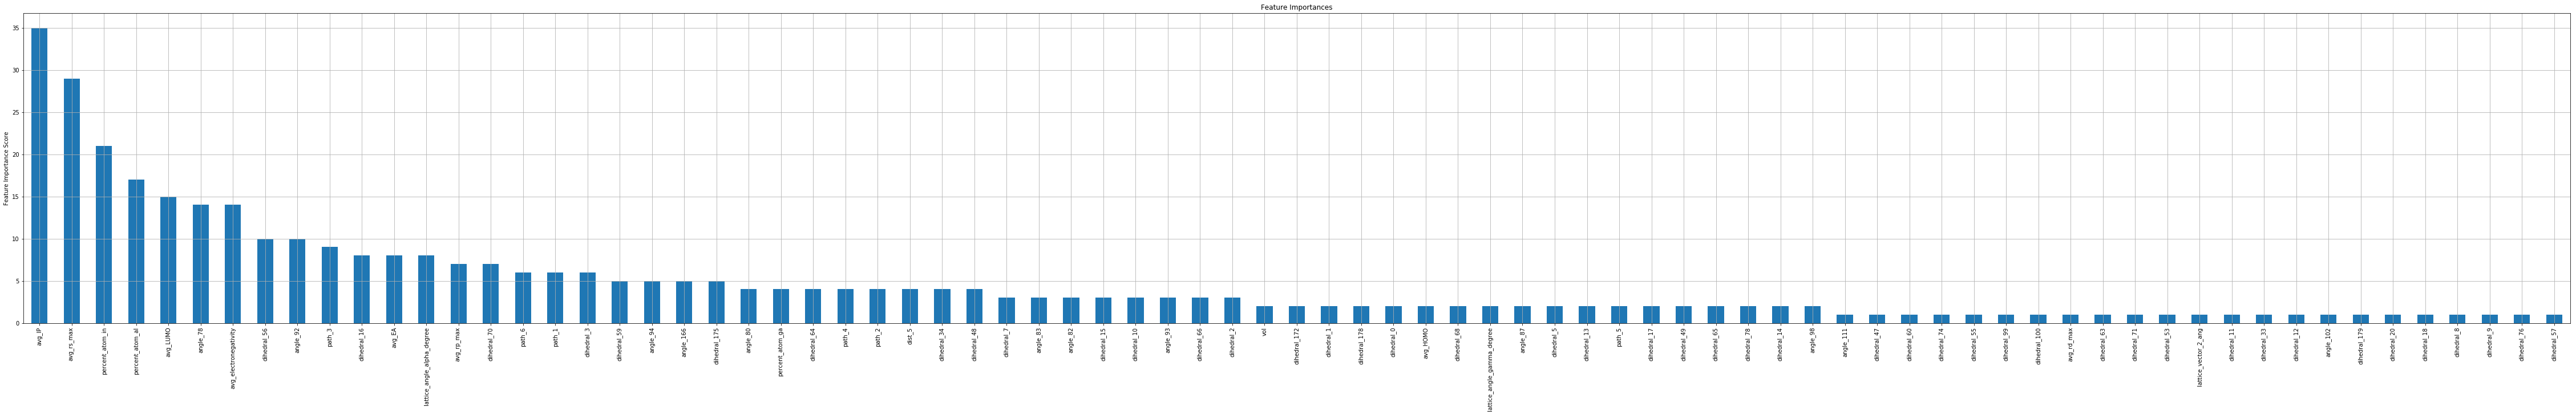

--------------------------------------
cluster: 1
--------------------------------------
[Fold 1/3]
[0]	train-rmse:0.141648	valid-rmse:0.143829	train-rmsle:0.102752	valid-rmsle:0.104804
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.027963	valid-rmse:0.089157	train-rmsle:0.019688	valid-rmsle:0.060467
Stopping. Best iteration:
[34]	train-rmse:0.049004	valid-rmse:0.081205	train-rmsle:0.034424	valid-rmsle:0.055542

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-rmse:0.139731	valid-rmse:0.145721	train-rmsle:0.100739	valid-rmsle:0.107535
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.029541	valid-rmse:0.092483	train-rmsle:0.020581	valid-rmsle:0.06303
Stopping. Best iteration:
[28]	train-rmse:0.056963	valid-rmse:0.082954	train-rmsle:0.040032	valid-rmsle:0.057

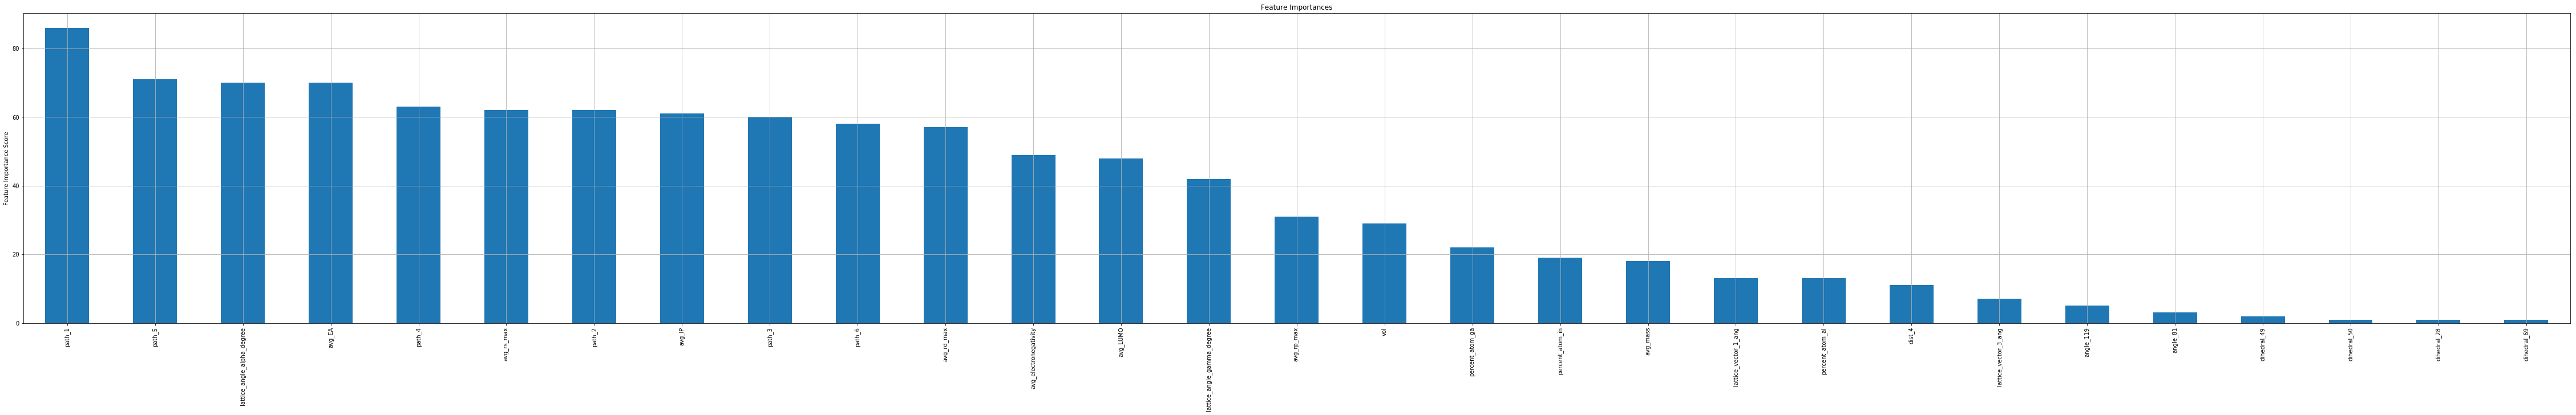

--------------------------------------
cluster: 2
--------------------------------------
[Fold 1/3]
[0]	train-rmse:0.152685	valid-rmse:0.152591	train-rmsle:0.109669	valid-rmsle:0.107046
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.0224	valid-rmse:0.094102	train-rmsle:0.016238	valid-rmsle:0.06474
Stopping. Best iteration:
[29]	train-rmse:0.049014	valid-rmse:0.087817	train-rmsle:0.03572	valid-rmsle:0.059846

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-rmse:0.150498	valid-rmse:0.154975	train-rmsle:0.106973	valid-rmsle:0.111169
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.023957	valid-rmse:0.083625	train-rmsle:0.017561	valid-rmsle:0.058756
[200]	train-rmse:0.020128	valid-rmse:0.084276	train-rmsle:0.014775	valid-rmsle:0.059143
Stopping. Best iteration

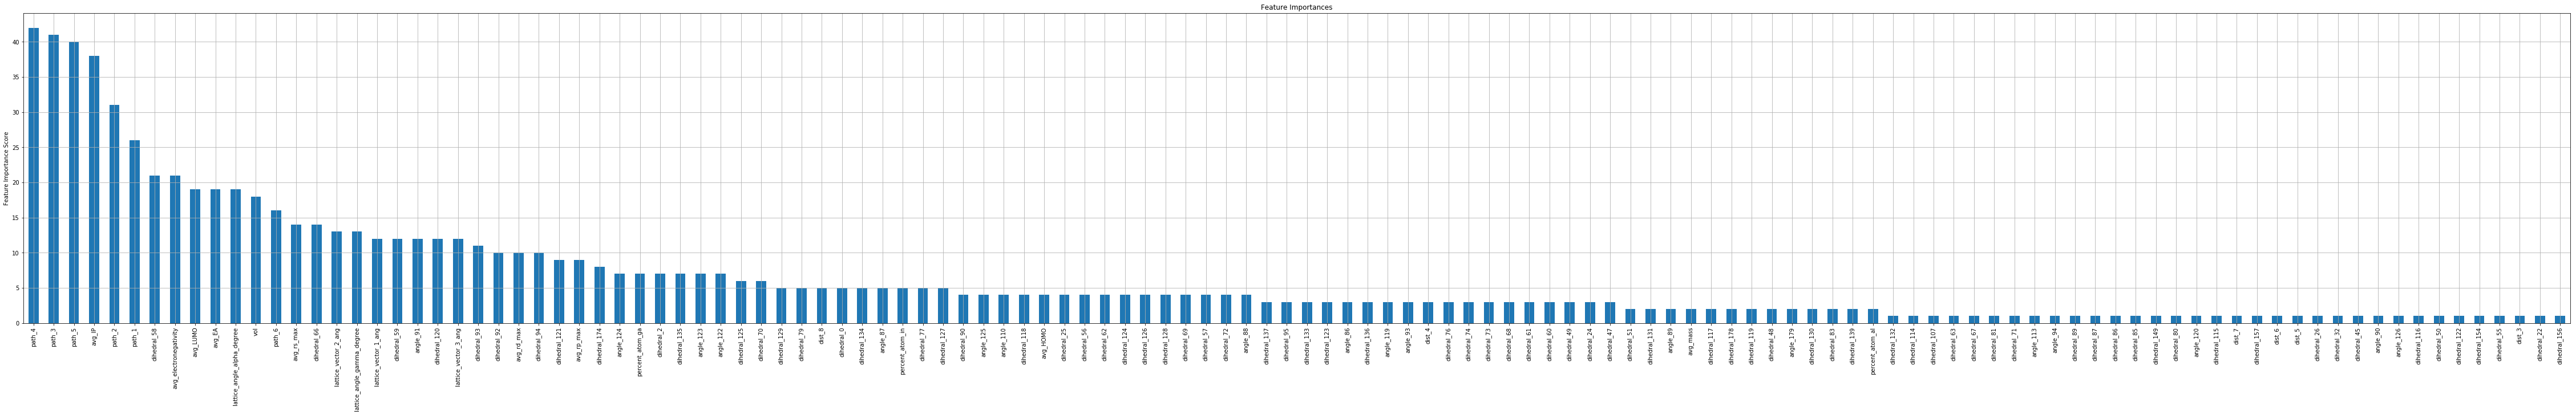

--------------------------------------
cluster: 3
--------------------------------------
[Fold 1/3]
[0]	train-rmse:0.254076	valid-rmse:0.267487	train-rmsle:0.195004	valid-rmsle:0.205621
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.024396	valid-rmse:0.050542	train-rmsle:0.018292	valid-rmsle:0.036691
Stopping. Best iteration:
[59]	train-rmse:0.02816	valid-rmse:0.049096	train-rmsle:0.02118	valid-rmsle:0.035877

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-rmse:0.26594	valid-rmse:0.241345	train-rmsle:0.20484	valid-rmsle:0.184166
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.021548	valid-rmse:0.049381	train-rmsle:0.016492	valid-rmsle:0.035641
Stopping. Best iteration:
[80]	train-rmse:0.023095	valid-rmse:0.048502	train-rmsle:0.017647	valid-rmsle:0.035015

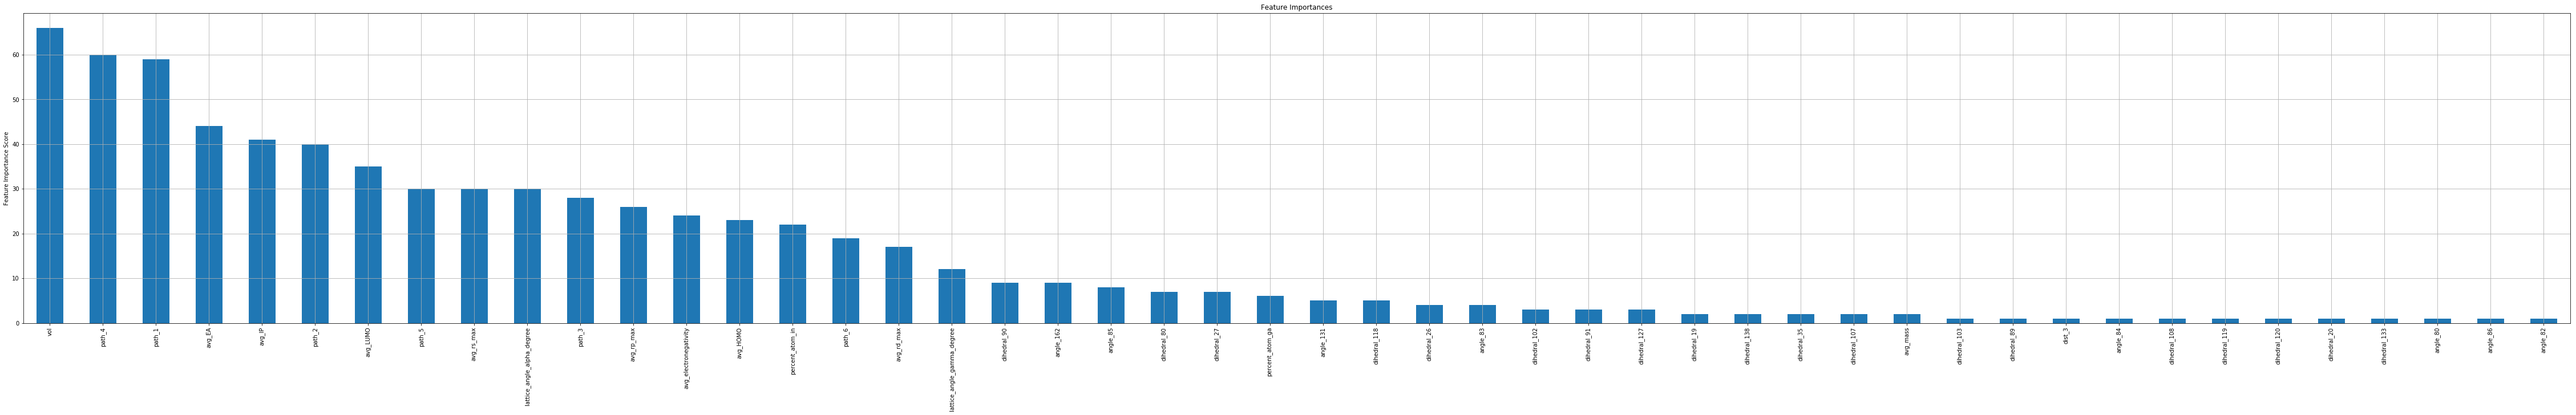

--------------------------------------
cluster: 4
--------------------------------------
[Fold 1/3]
[0]	train-rmse:0.237915	valid-rmse:0.231913	train-rmsle:0.180804	valid-rmsle:0.175374
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.021496	valid-rmse:0.05321	train-rmsle:0.015936	valid-rmsle:0.037343
Stopping. Best iteration:
[51]	train-rmse:0.025423	valid-rmse:0.05212	train-rmsle:0.01906	valid-rmsle:0.036427

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-rmse:0.236625	valid-rmse:0.235506	train-rmsle:0.179507	valid-rmsle:0.178831
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.023327	valid-rmse:0.041467	train-rmsle:0.01625	valid-rmsle:0.03081
Stopping. Best iteration:
[56]	train-rmse:0.029585	valid-rmse:0.040455	train-rmsle:0.020506	valid-rmsle:0.030079


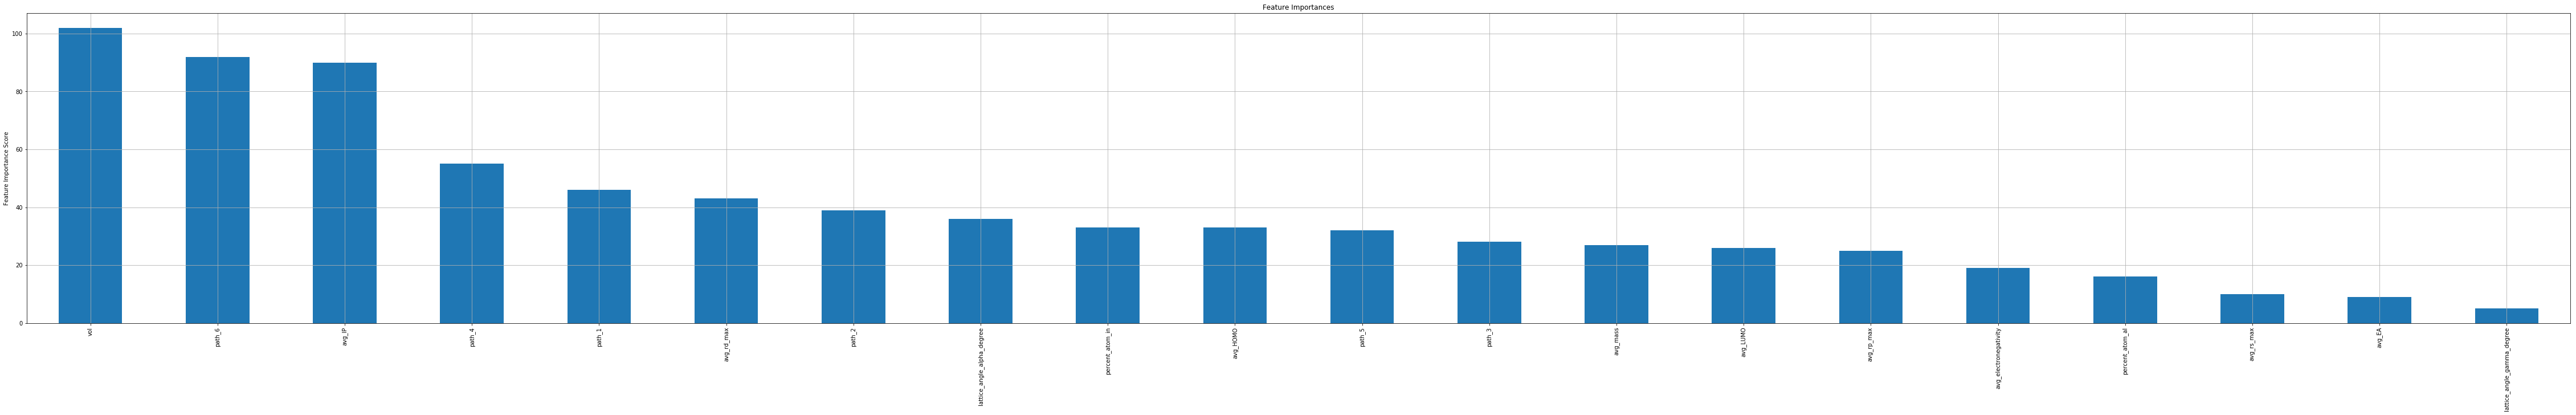

--------------------------------------
cluster: 5
--------------------------------------
[Fold 1/3]
[0]	train-rmse:0.317282	valid-rmse:0.30512	train-rmsle:0.25257	valid-rmsle:0.240388
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.035387	valid-rmse:0.09464	train-rmsle:0.029933	valid-rmsle:0.067501
Stopping. Best iteration:
[47]	train-rmse:0.046463	valid-rmse:0.090505	train-rmsle:0.039285	valid-rmsle:0.063661

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-rmse:0.311622	valid-rmse:0.320912	train-rmsle:0.246873	valid-rmsle:0.255146
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.039134	valid-rmse:0.096666	train-rmsle:0.030156	valid-rmsle:0.075879
Stopping. Best iteration:
[72]	train-rmse:0.043046	valid-rmse:0.093666	train-rmsle:0.033161	valid-rmsle:0.07362

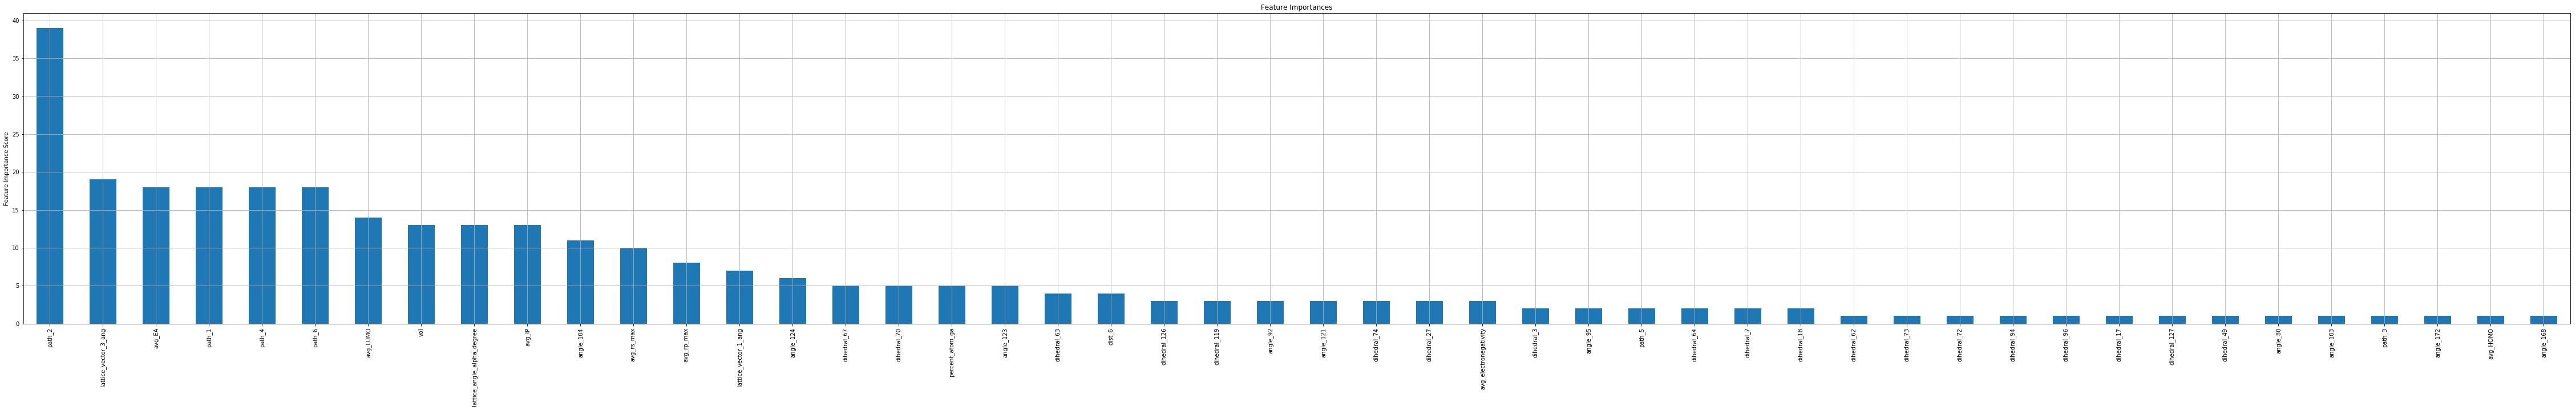

--------------------------------------
cluster: 6
--------------------------------------
[Fold 1/3]
[0]	train-rmse:0.265193	valid-rmse:0.21659	train-rmsle:0.20303	valid-rmsle:0.161812
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.025292	valid-rmse:0.033182	train-rmsle:0.021919	valid-rmsle:0.025524
[200]	train-rmse:0.022484	valid-rmse:0.031944	train-rmsle:0.019382	valid-rmsle:0.024698
[300]	train-rmse:0.021999	valid-rmse:0.031467	train-rmsle:0.018926	valid-rmsle:0.024337
[400]	train-rmse:0.021494	valid-rmse:0.031114	train-rmsle:0.018472	valid-rmsle:0.024069
[500]	train-rmse:0.021463	valid-rmse:0.031112	train-rmsle:0.018425	valid-rmsle:0.024077
Stopping. Best iteration:
[414]	train-rmse:0.021569	valid-rmse:0.030832	train-rmsle:0.018516	valid-rmsle:0.02385

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-rmse:0.239528	valid-rmse:0.273779	train-rmsle:0.181144	valid-rmsle:0.2

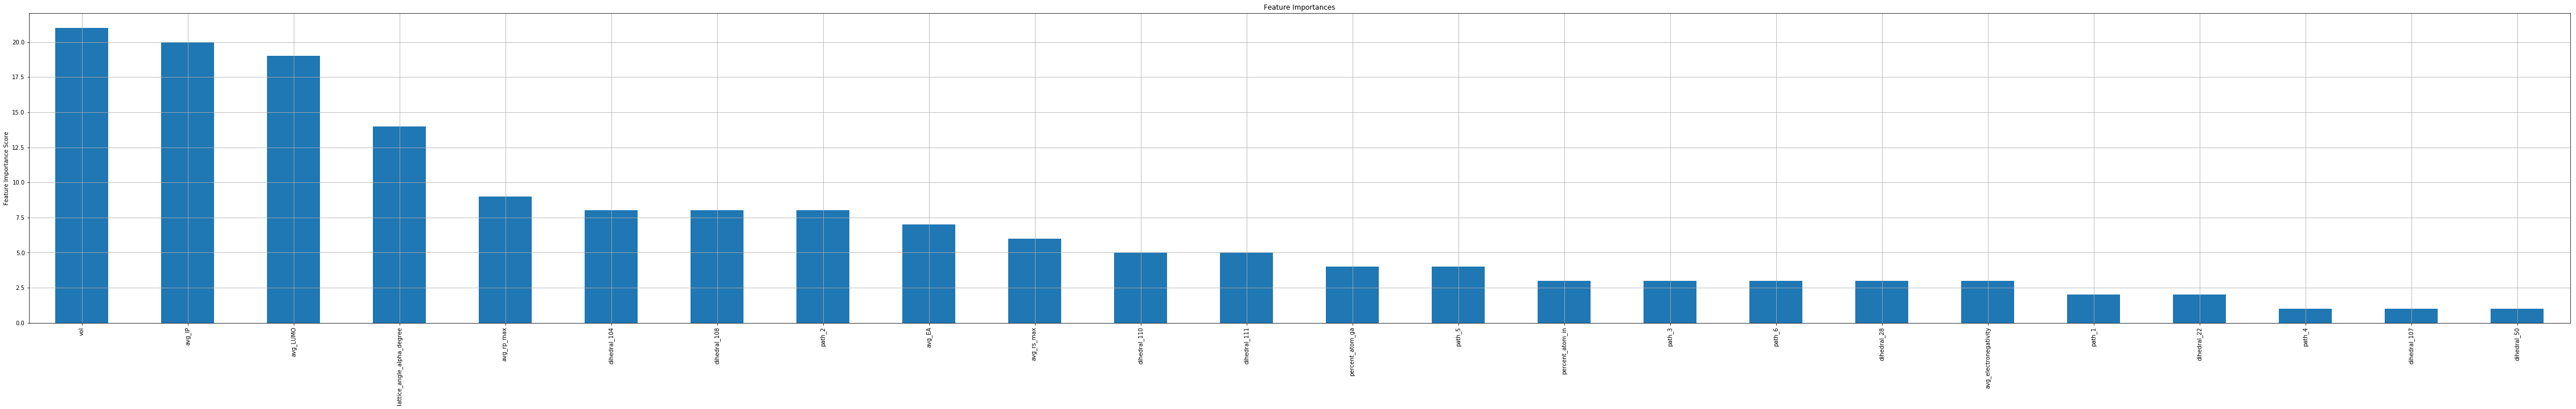

--------------------------------------
cluster: 7
--------------------------------------
[Fold 1/3]
[0]	train-rmse:0.250741	valid-rmse:0.242992	train-rmsle:0.193465	valid-rmsle:0.187052
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.020038	valid-rmse:0.046664	train-rmsle:0.016427	valid-rmsle:0.035536
Stopping. Best iteration:
[60]	train-rmse:0.023185	valid-rmse:0.045152	train-rmsle:0.019052	valid-rmsle:0.03444

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-rmse:0.25092	valid-rmse:0.24156	train-rmsle:0.194116	valid-rmsle:0.184952
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.018877	valid-rmse:0.05254	train-rmsle:0.015272	valid-rmsle:0.041058
Stopping. Best iteration:
[59]	train-rmse:0.022277	valid-rmse:0.052049	train-rmsle:0.01801	valid-rmsle:0.040661


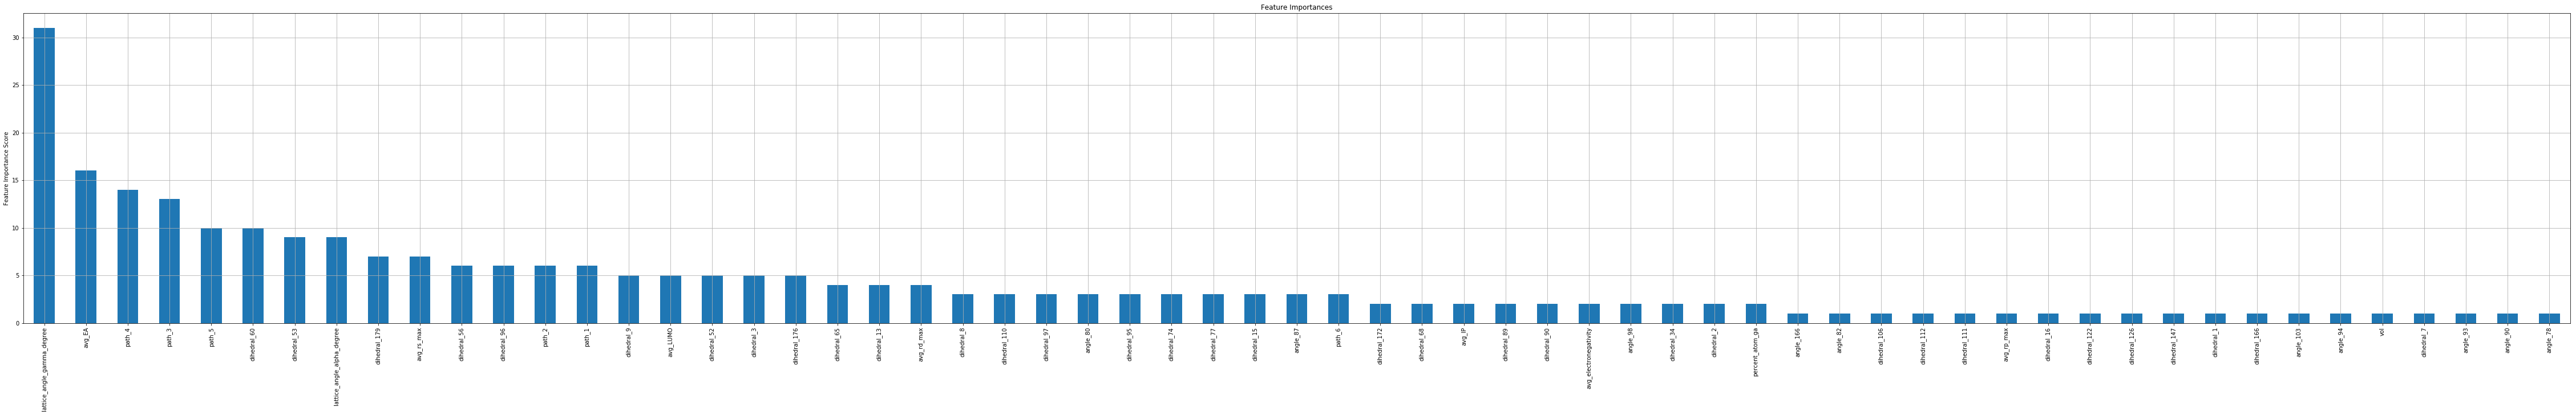

--------------------------------------
cluster: 8
--------------------------------------
[Fold 1/3]
[0]	train-rmse:0.282847	valid-rmse:0.254777	train-rmsle:0.220959	valid-rmsle:0.196869
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.032384	valid-rmse:0.066825	train-rmsle:0.025862	valid-rmsle:0.05143
Stopping. Best iteration:
[88]	train-rmse:0.034374	valid-rmse:0.06551	train-rmsle:0.02744	valid-rmsle:0.050511

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-rmse:0.26925	valid-rmse:0.28763	train-rmsle:0.208824	valid-rmsle:0.225003
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.028949	valid-rmse:0.074386	train-rmsle:0.023446	valid-rmsle:0.058212
Stopping. Best iteration:
[67]	train-rmse:0.035746	valid-rmse:0.073384	train-rmsle:0.028956	valid-rmsle:0.057724


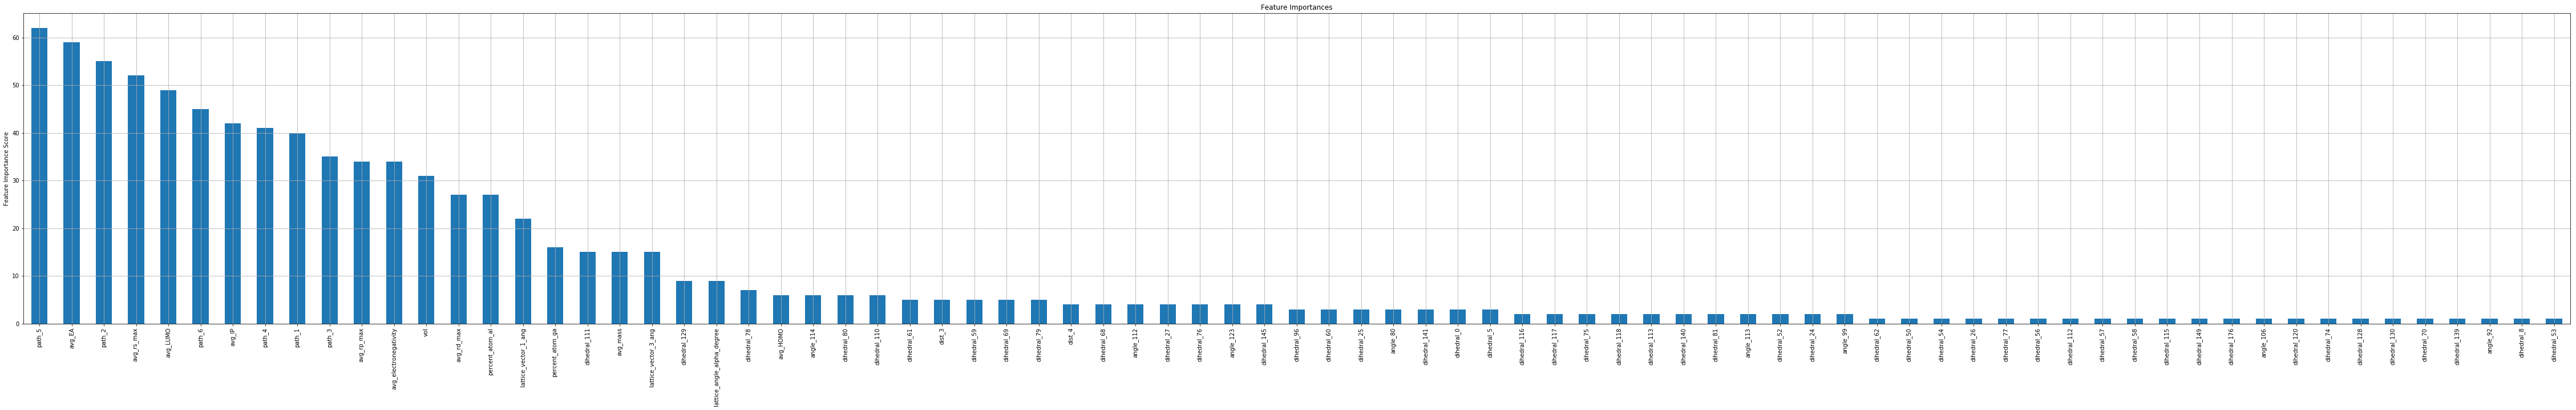

--------------------------------------
cluster: 9
--------------------------------------
[Fold 1/3]
[0]	train-rmse:0.113489	valid-rmse:0.145949	train-rmsle:0.073614	valid-rmsle:0.093006
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.023169	valid-rmse:0.093935	train-rmsle:0.015273	valid-rmsle:0.058996
Stopping. Best iteration:
[58]	train-rmse:0.027814	valid-rmse:0.092725	train-rmsle:0.018275	valid-rmsle:0.058262

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-rmse:0.132323	valid-rmse:0.109995	train-rmsle:0.084879	valid-rmsle:0.071514
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.023105	valid-rmse:0.069209	train-rmsle:0.015279	valid-rmsle:0.044234
Stopping. Best iteration:
[30]	train-rmse:0.045381	valid-rmse:0.066435	train-rmsle:0.029495	valid-rmsle:0.04

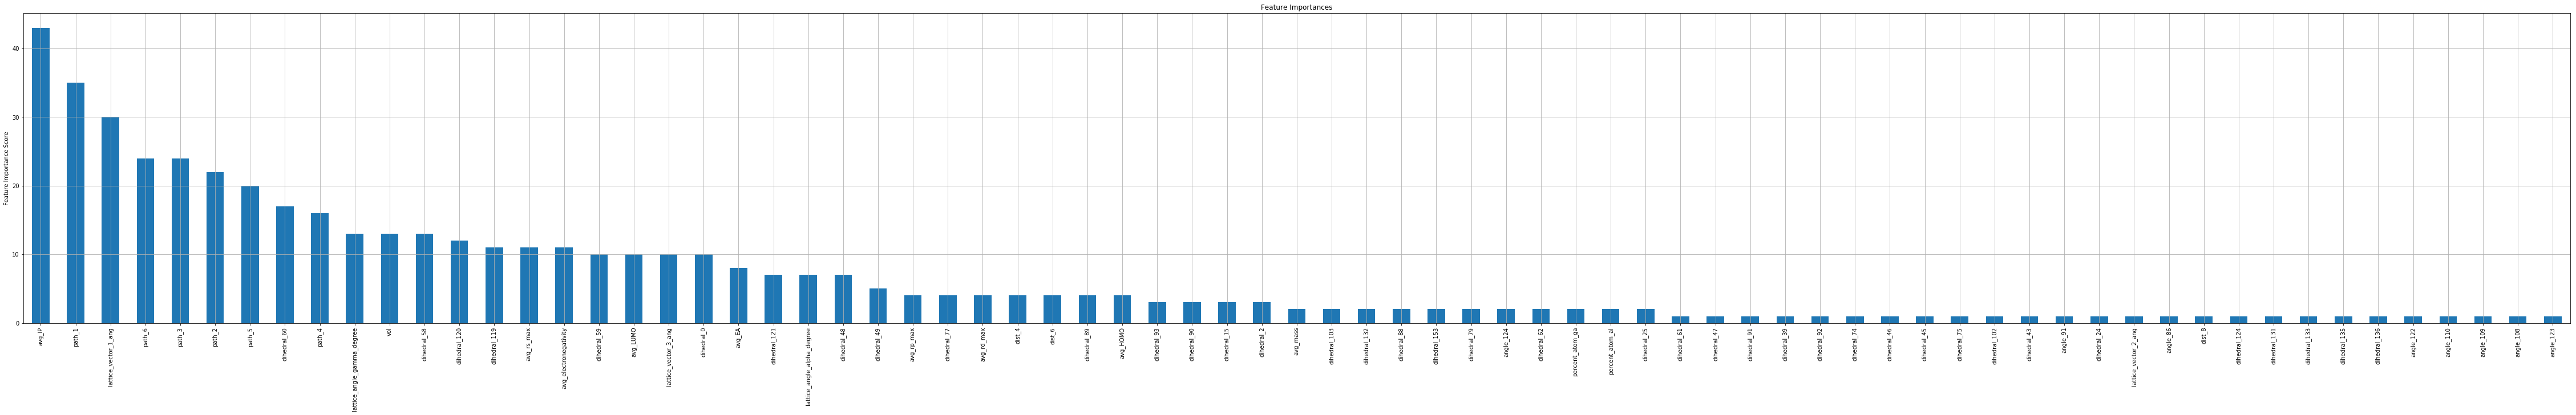

--------------------------------------
cluster: 10
--------------------------------------
[Fold 1/3]
[0]	train-rmse:0.23962	valid-rmse:0.217268	train-rmsle:0.153977	valid-rmsle:0.130647
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.228299	valid-rmse:0.236418	train-rmsle:0.142583	valid-rmsle:0.142673
Stopping. Best iteration:
[0]	train-rmse:0.23962	valid-rmse:0.217268	train-rmsle:0.153977	valid-rmsle:0.130647

[Fold 1/3 Prediciton:]
[Fold 2/3]
[0]	train-rmse:0.196053	valid-rmse:0.296294	train-rmsle:0.125541	valid-rmsle:0.183282
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.190241	valid-rmse:0.30047	train-rmsle:0.119448	valid-rmsle:0.183546
Stopping. Best iteration:
[11]	train-rmse:0.192099	valid-rmse:0.29746	train-rmsle:0.121831	valid-rmsle:0.1828



TypeError: Empty 'DataFrame': no numeric data to plot

In [208]:
# feat_list = ['lattice_angle_alpha_degree',
#              'lattice_vector_1_ang',
#              'lattice_vector_2_ang',
#              'lattice_vector_3_ang']+dist_features+avg_features


sub['formation_energy_ev_natom'] = np.zeros_like(test_id)

t = time.time()

kfold = 3
sscv = KFold(n_splits=3, shuffle=False, random_state=42)

for cluster in range(11):
    print('--------------------------------------')
    print('cluster: '+str(cluster))
    print('--------------------------------------')
#     BE_features = FE_features#  ['lattice_angle_alpha_degree',
# #                  'lattice_angle_gamma_degree',
# #                  'number_of_total_atoms',
# #                  'vol',
# #                  'atomic_density',
# #                  'lattice_vector_1_ang',
# #                  'lattice_vector_2_ang',
# #                  'lattice_vector_3_ang']+avg_features+percent_features+dist_features
    
    X_test_e = df_test[FE_features].values

    X_train_e = df_train[FE_features].values
    
    X = X_train_e[train_labels==cluster]
    y = y_e[train_labels==cluster]
    X_test = X_test_e[test_labels==cluster]
#     y_m = y.max()
#     y=y/y.max()
#    params = params_be[str(cluster)]
    
    for i, (train_index, test_index) in enumerate(sscv.split(X, y)):
        print('[Fold %d/%d]' % (i + 1, kfold))
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        # Convert our data into XGBoost format
        d_train = xgb.DMatrix(X_train, y_train)
        d_valid = xgb.DMatrix(X_valid, y_valid)
        d_test = xgb.DMatrix(X_test)
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]

        # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
        # and the custom metric (maximize=True tells xgb that higher metric is better)
        mdl = xgb.train(params,
                        d_train,
                        1600,
                        watchlist,
                        early_stopping_rounds=100,
                        feval=rmsle_xgb,
                        maximize=False,
                        verbose_eval=100)

        print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
        # Predict on our test data

        p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
        test_ids=test_id[test_labels==cluster]
        #sub.loc[sub['id'].isin(test_ids),'bandgap_energy_ev'] += ((np.exp(p_test*y_m)-1)/kfold)
        #sub.loc[sub['id'].isin(test_ids),'bandgap_energy_ev'] += ((np.square(p_test*y_be_s_m)-0.5)/kfold)
        p_test = scaler_e.inverse_transform(p_test.reshape(-1, 1)).flatten()
        sub.loc[sub['id'].isin(test_ids),'formation_energy_ev_natom'] += ((np.exp(p_test)-1)/kfold)
    
    feat_imp = pd.Series(mdl.get_fscore()).sort_values(ascending=False)
    feat_imp.rename(index={i:FE_features[int(i[1:])] for i in feat_imp.index.tolist()}, inplace=True)
    feat_imp.plot(kind='bar', title='Feature Importances', figsize=(80,10))
    plt.ylabel('Feature Importance Score')
    plt.grid()
    plt.show()

    
print()
print('this took {}seconds'.format(time.time()-t))

In [42]:
params_be = {'0' : {
    'objective': 'reg:linear',
    'max_depth': 3,
    'subsample': 0.8,
    'eta': 0.05,
    'gamma': 0.05,
    'nthreads': 12,
    },
    '1' : {
    'objective': 'reg:linear',
    'max_depth': 3,
    'subsample': 0.8,
    'eta': 0.05,
    'gamma': 0.05,
    'nthreads': 12,
    },
'2' : {
    'objective': 'reg:linear',
    'max_depth': 3,
    'subsample': 0.87,
    'eta': 0.02, 
    'gamma': 0.05,
    'nthreads': 12,
    },
'3' : {
    'objective': 'reg:linear',
    'max_depth': 3,
    'subsample': 0.75,
    'eta': 0.1, #0.028084362074445819, #0.025
    'gamma': 0.05,
    'nthreads': 12,
#     'tree_method': 'gpu_hist',
    },
'4' : {
    'objective': 'reg:linear',
    'max_depth': 4,
    'subsample': 0.75,
    'eta': 0.1, 
    'gamma': 0.05,
    'nthreads': 12,
    },
'5' : {
    'objective': 'reg:linear',
    'max_depth': 4,
    'subsample': 0.8,
    'eta': 0.3, 
    'gamma': 0.05,
    'nthreads': 12,
    },
'6' : {
    'objective': 'reg:linear',
    'max_depth': 3,
    'subsample': 0.7,
    'eta': 0.25,
    'gamma': 0.05,
    'nthreads': 12,
    },
'7' : {
    'objective': 'reg:linear',
    'max_depth': 1,
    'subsample': 0.8,
    'eta': 0.1, 
    'gamma': 0.05,
    'nthreads': 12,
    },
'8' : {
    'objective': 'reg:linear',
    'max_depth': 3,
    'subsample': 0.75,
    'eta': 0.35, #0.028084362074445819, #0.025
    'gamma': 0.05,
    'nthreads': 12,
#     'tree_method': 'gpu_hist',
    },
'9' : {
    'objective': 'reg:linear',
    'max_depth': 1,
    'subsample': 0.7,
    'eta': 0.25, #0.028084362074445819, #0.025
    'gamma': 0.25,
    'nthreads': 12,
#     'tree_method': 'gpu_hist',
    },
'10' : {
    'objective': 'reg:linear',
    'max_depth': 5,
    'subsample': 0.75,
    'eta': 0.1, #0.028084362074445819, #0.025
    'gamma':0.01,
    'nthreads': 12,
#     'tree_method': 'gpu_hist',
    }}

--------------------------------------
cluster: 0
--------------------------------------
[Fold 1/5]
[0]	train-rmse:0.666626	valid-rmse:0.661632	train-rmsle:0.349354	valid-rmsle:0.34777
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.031408	valid-rmse:0.034348	train-rmsle:0.015535	valid-rmsle:0.017567
[200]	train-rmse:0.030531	valid-rmse:0.033704	train-rmsle:0.015494	valid-rmsle:0.017495
[300]	train-rmse:0.030532	valid-rmse:0.033718	train-rmsle:0.015477	valid-rmsle:0.01749
[400]	train-rmse:0.030531	valid-rmse:0.0337	train-rmsle:0.015498	valid-rmsle:0.017496
[500]	train-rmse:0.030199	valid-rmse:0.033361	train-rmsle:0.015299	valid-rmsle:0.017314
[600]	train-rmse:0.030199	valid-rmse:0.033357	train-rmsle:0.015303	valid-rmsle:0.017315
Stopping. Best iteration:
[526]	train-rmse:0.030202	valid-rmse:0.033381	train-rmsle:0.015279	valid-rmsle:0.017308

[Fold 1/5 Prediciton:]


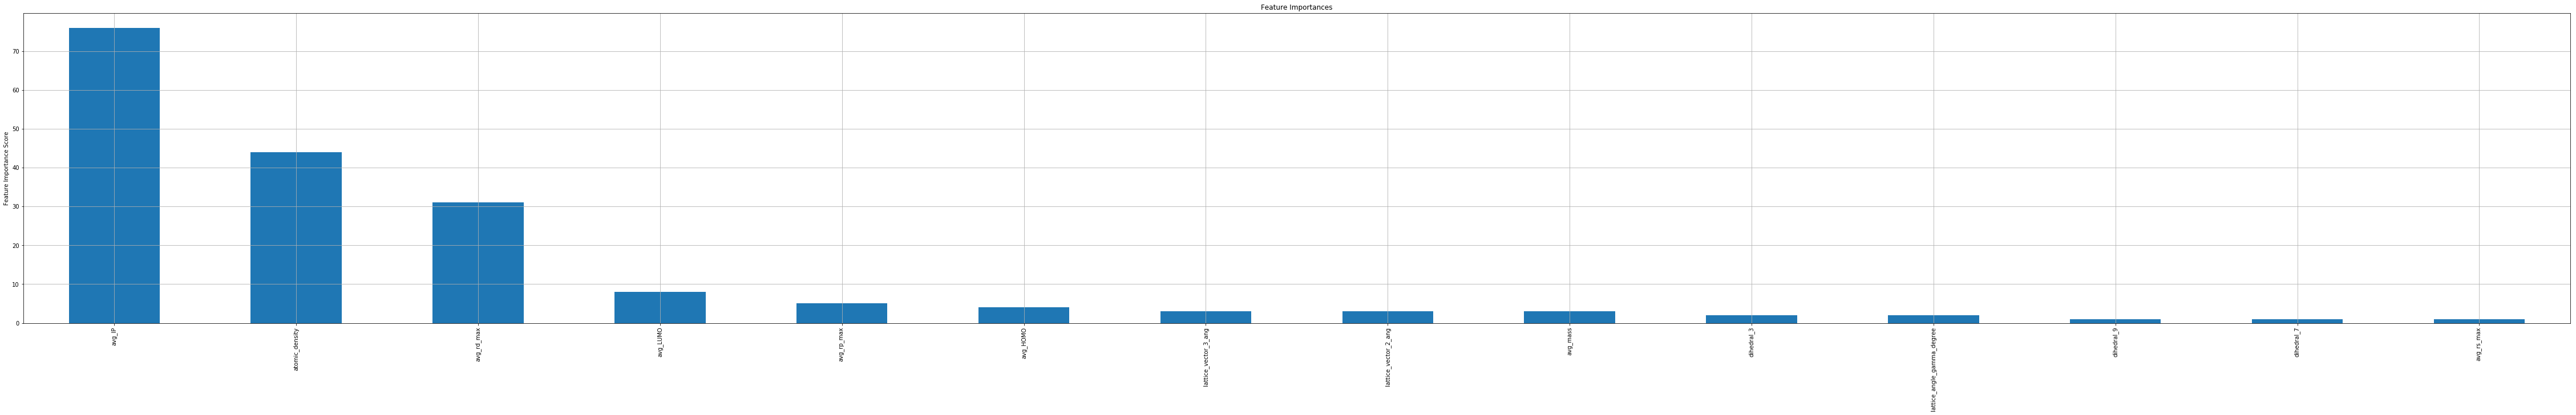

[Fold 2/5]
[0]	train-rmse:0.661096	valid-rmse:0.683932	train-rmsle:0.346974	valid-rmsle:0.357546
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.032125	valid-rmse:0.04034	train-rmsle:0.016013	valid-rmsle:0.017506
[200]	train-rmse:0.031214	valid-rmse:0.038851	train-rmsle:0.015856	valid-rmsle:0.016995
[300]	train-rmse:0.030862	valid-rmse:0.038689	train-rmsle:0.015658	valid-rmsle:0.016928
[400]	train-rmse:0.030862	valid-rmse:0.03868	train-rmsle:0.015661	valid-rmsle:0.016925
Stopping. Best iteration:
[320]	train-rmse:0.030862	valid-rmse:0.03861	train-rmsle:0.015683	valid-rmsle:0.016903

[Fold 2/5 Prediciton:]


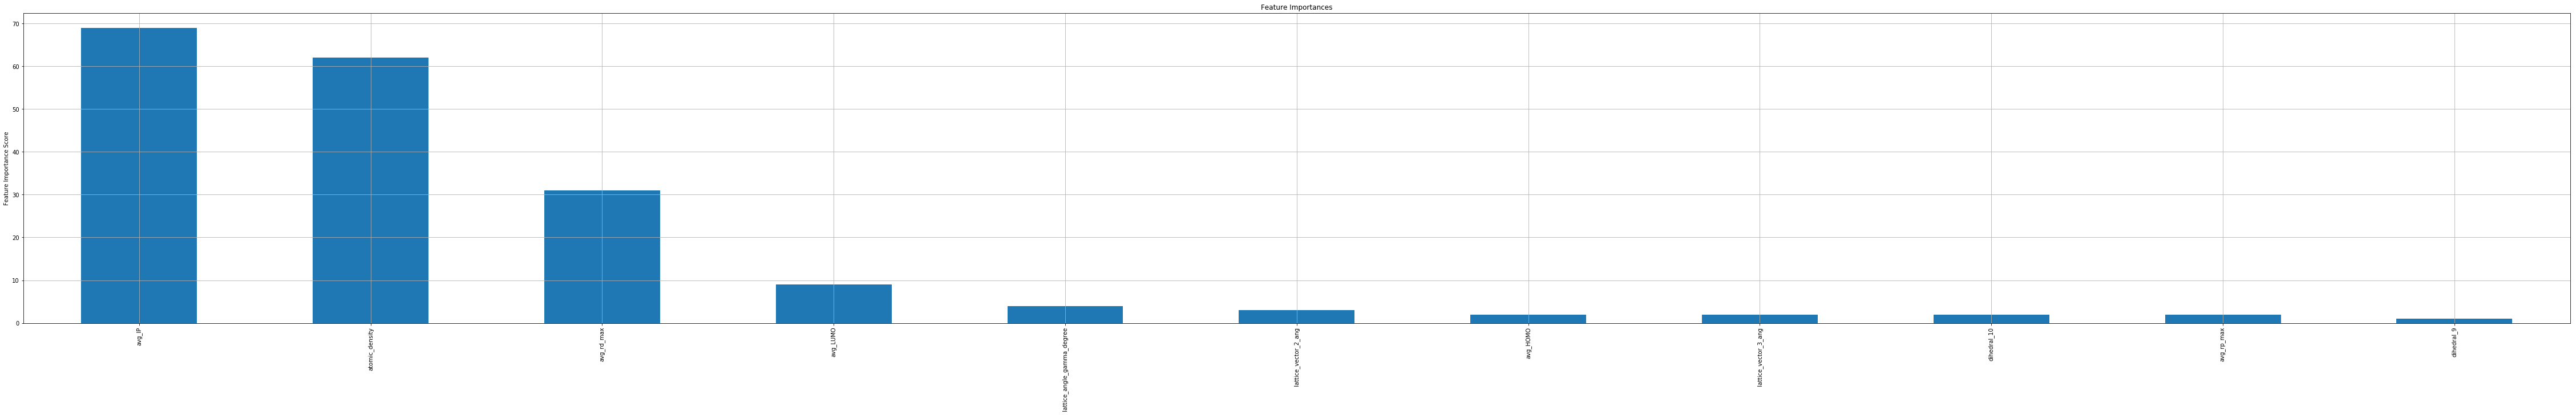

[Fold 3/5]
[0]	train-rmse:0.667761	valid-rmse:0.65743	train-rmsle:0.350224	valid-rmsle:0.344535
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.030966	valid-rmse:0.045336	train-rmsle:0.014993	valid-rmsle:0.023856
[200]	train-rmse:0.030067	valid-rmse:0.044782	train-rmsle:0.014901	valid-rmsle:0.023869
Stopping. Best iteration:
[104]	train-rmse:0.03023	valid-rmse:0.044717	train-rmsle:0.014738	valid-rmsle:0.023656

[Fold 3/5 Prediciton:]


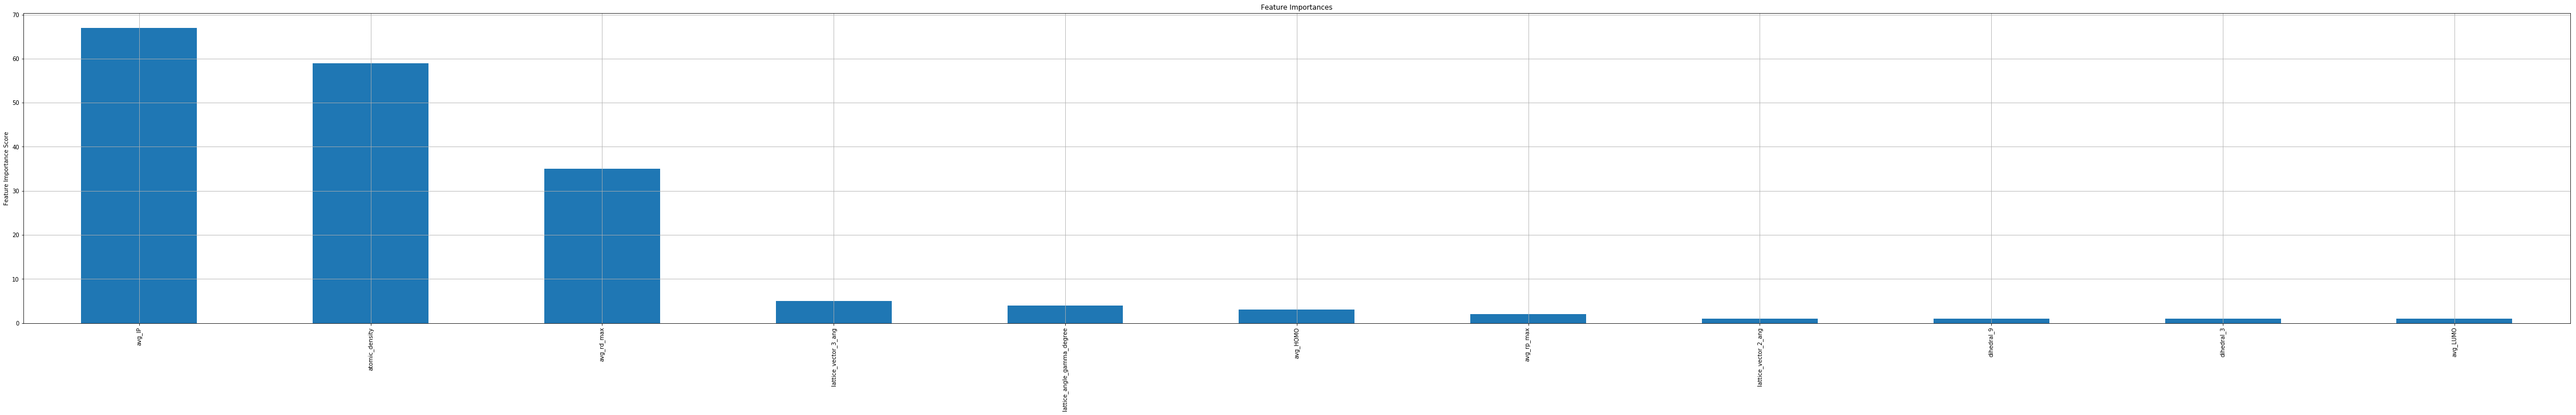

[Fold 4/5]
[0]	train-rmse:0.667641	valid-rmse:0.657026	train-rmsle:0.350128	valid-rmsle:0.344384
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.030975	valid-rmse:0.041322	train-rmsle:0.015342	valid-rmsle:0.020757
[200]	train-rmse:0.030404	valid-rmse:0.040554	train-rmsle:0.015414	valid-rmsle:0.020601
[300]	train-rmse:0.03007	valid-rmse:0.040392	train-rmsle:0.01521	valid-rmsle:0.020495
Stopping. Best iteration:
[207]	train-rmse:0.03007	valid-rmse:0.040381	train-rmsle:0.015218	valid-rmsle:0.020494

[Fold 4/5 Prediciton:]


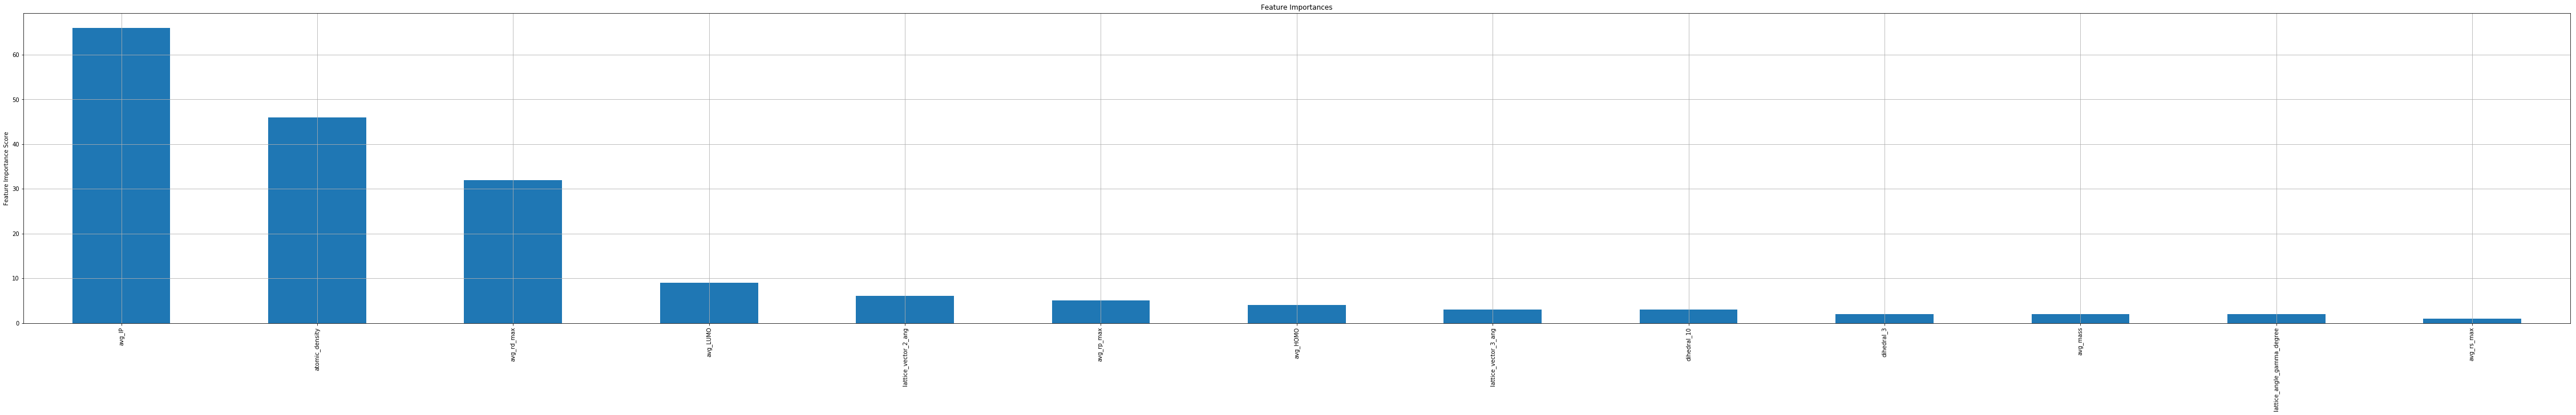

[Fold 5/5]
[0]	train-rmse:0.673689	valid-rmse:0.632648	train-rmsle:0.352637	valid-rmsle:0.334299
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.032262	valid-rmse:0.032685	train-rmsle:0.016073	valid-rmsle:0.016943
Stopping. Best iteration:
[79]	train-rmse:0.034593	valid-rmse:0.033426	train-rmsle:0.016609	valid-rmsle:0.016788

[Fold 5/5 Prediciton:]


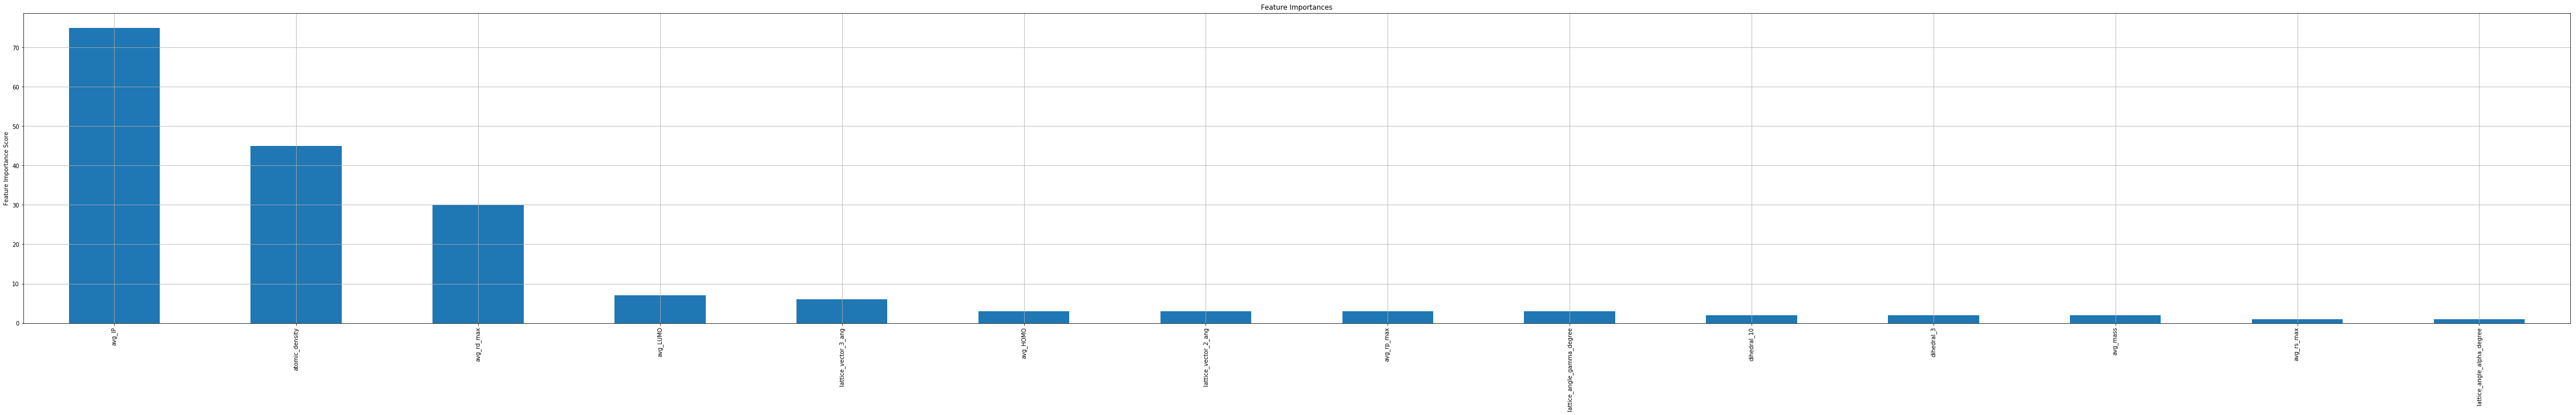

--------------------------------------
cluster: 1
--------------------------------------
[Fold 1/5]
[0]	train-rmse:0.534153	valid-rmse:0.513032	train-rmsle:0.28556	valid-rmsle:0.276407
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.078784	valid-rmse:0.088491	train-rmsle:0.041252	valid-rmsle:0.045598
[200]	train-rmse:0.076613	valid-rmse:0.088845	train-rmsle:0.040262	valid-rmsle:0.045808
Stopping. Best iteration:
[114]	train-rmse:0.078454	valid-rmse:0.088336	train-rmsle:0.041149	valid-rmsle:0.045502

[Fold 1/5 Prediciton:]


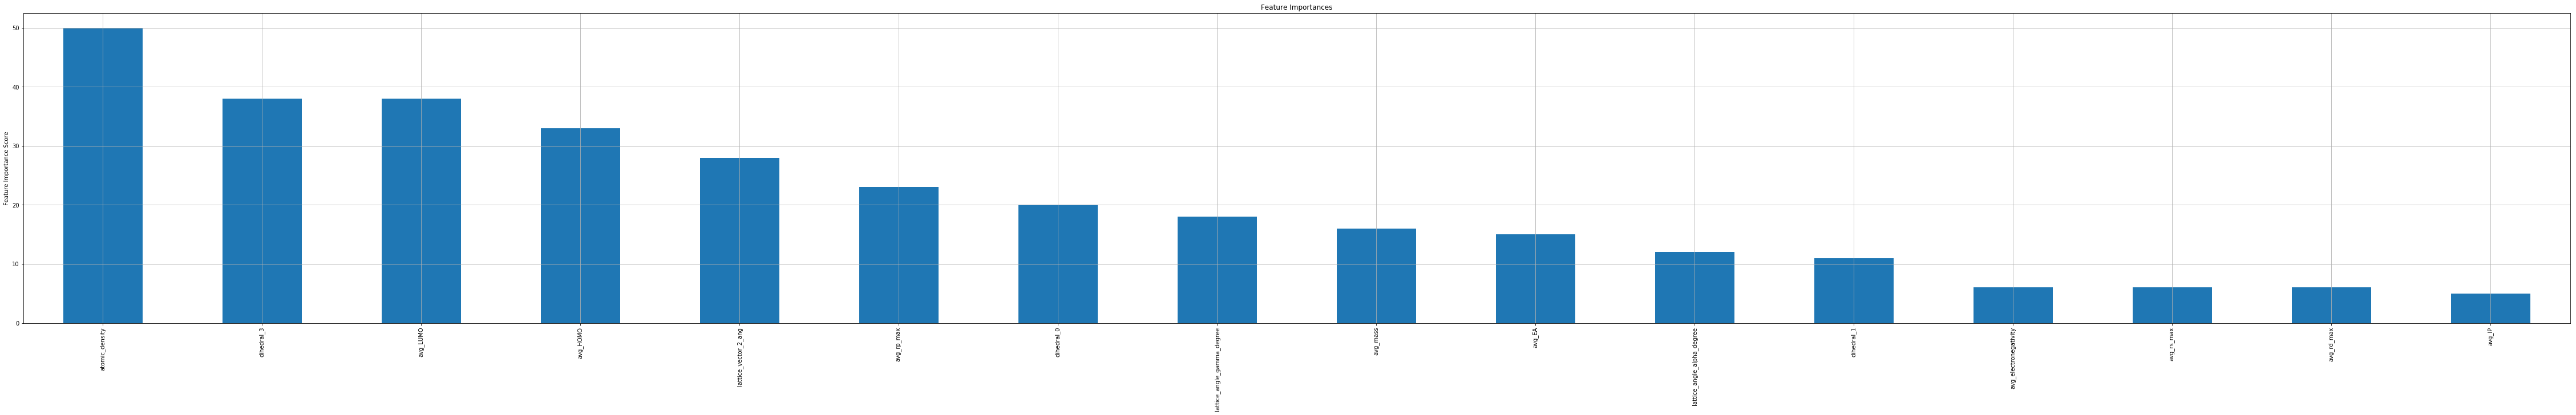

[Fold 2/5]
[0]	train-rmse:0.536446	valid-rmse:0.504799	train-rmsle:0.286916	valid-rmsle:0.271681
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.081246	valid-rmse:0.080718	train-rmsle:0.042537	valid-rmsle:0.041559
[200]	train-rmse:0.078522	valid-rmse:0.079973	train-rmsle:0.041105	valid-rmsle:0.041538
Stopping. Best iteration:
[162]	train-rmse:0.079163	valid-rmse:0.079403	train-rmsle:0.041467	valid-rmsle:0.041133

[Fold 2/5 Prediciton:]


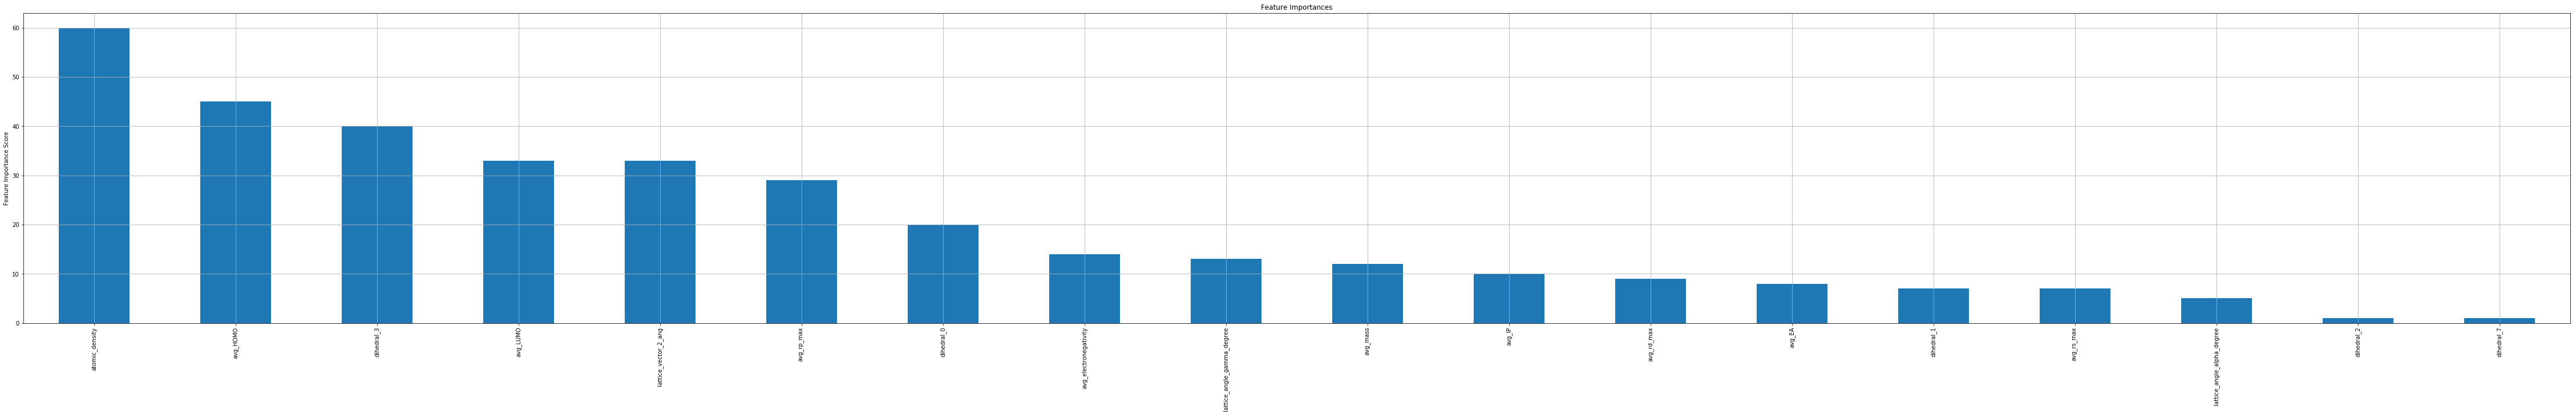

[Fold 3/5]
[0]	train-rmse:0.524531	valid-rmse:0.550753	train-rmsle:0.280758	valid-rmsle:0.295009
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.076215	valid-rmse:0.107528	train-rmsle:0.040677	valid-rmsle:0.05273
Stopping. Best iteration:
[85]	train-rmse:0.077434	valid-rmse:0.10653	train-rmsle:0.041122	valid-rmsle:0.052383

[Fold 3/5 Prediciton:]


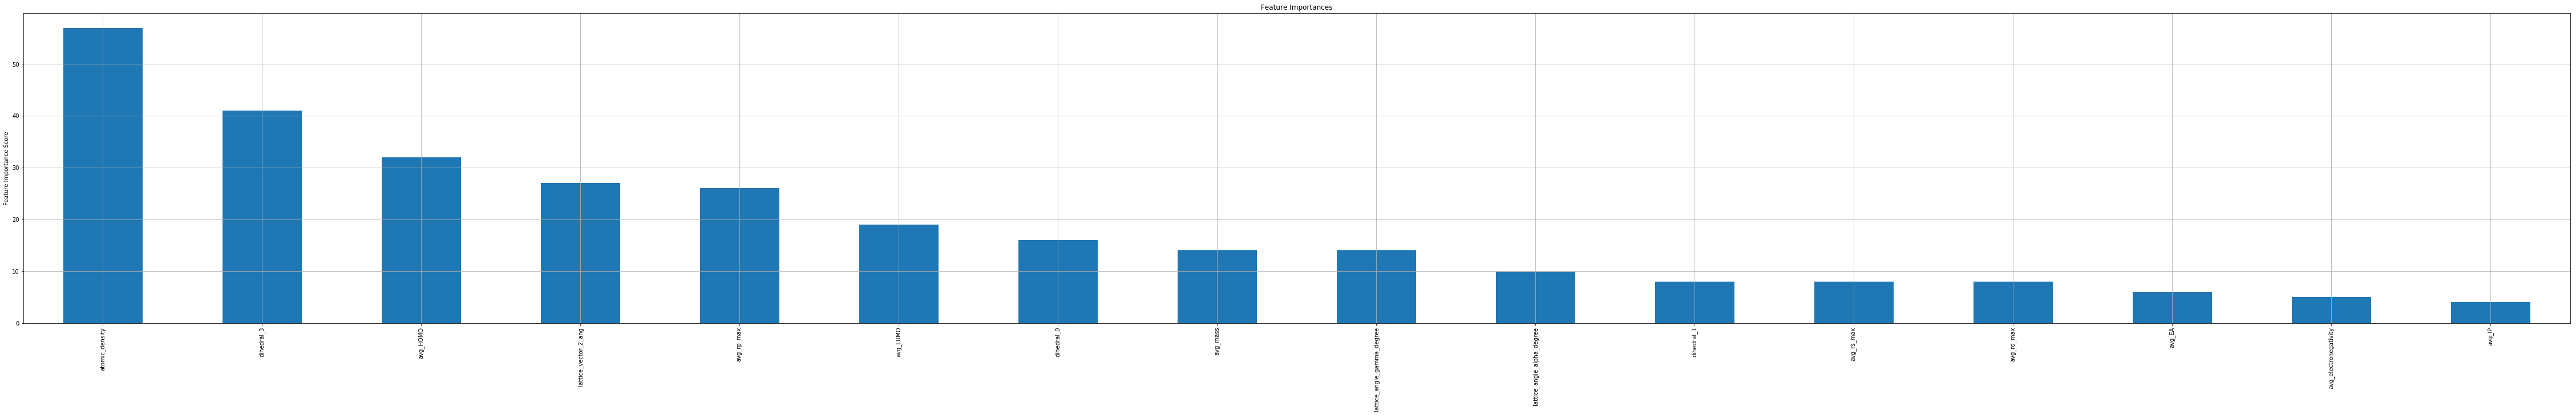

[Fold 4/5]
[0]	train-rmse:0.542698	valid-rmse:0.475007	train-rmsle:0.2896	valid-rmsle:0.258511
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.077988	valid-rmse:0.103327	train-rmsle:0.041023	valid-rmsle:0.053688
Stopping. Best iteration:
[55]	train-rmse:0.088593	valid-rmse:0.101077	train-rmsle:0.044902	valid-rmsle:0.052535

[Fold 4/5 Prediciton:]


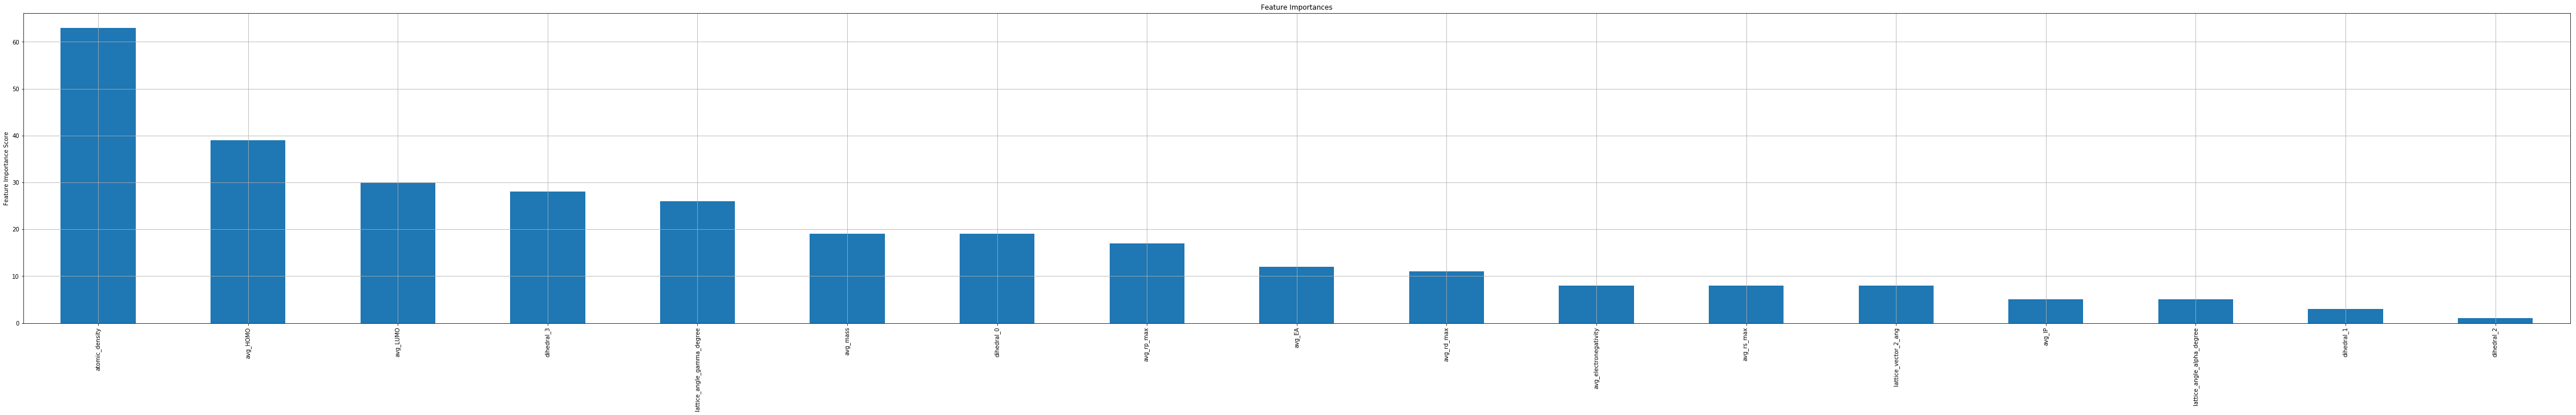

[Fold 5/5]
[0]	train-rmse:0.534655	valid-rmse:0.510802	train-rmsle:0.285791	valid-rmsle:0.27535
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.075189	valid-rmse:0.109513	train-rmsle:0.039446	valid-rmsle:0.055228
[200]	train-rmse:0.073329	valid-rmse:0.109431	train-rmsle:0.038605	valid-rmsle:0.055212
Stopping. Best iteration:
[114]	train-rmse:0.074339	valid-rmse:0.109091	train-rmsle:0.039091	valid-rmsle:0.055037

[Fold 5/5 Prediciton:]


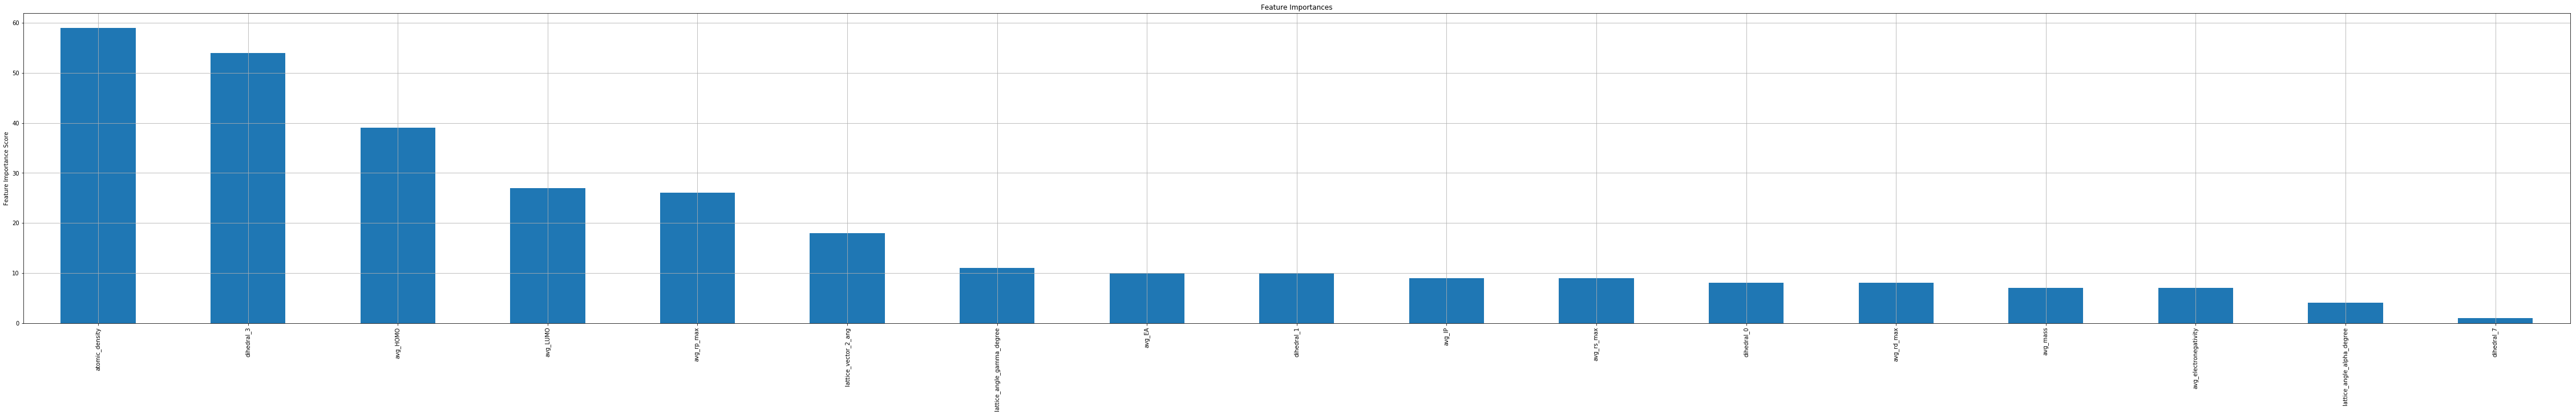

--------------------------------------
cluster: 2
--------------------------------------
[Fold 1/5]
[0]	train-rmse:0.519819	valid-rmse:0.517516	train-rmsle:0.285313	valid-rmsle:0.286077
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.132029	valid-rmse:0.172968	train-rmsle:0.069705	valid-rmsle:0.09565
[200]	train-rmse:0.094795	valid-rmse:0.164898	train-rmsle:0.05313	valid-rmsle:0.092432
Stopping. Best iteration:
[191]	train-rmse:0.096164	valid-rmse:0.164154	train-rmsle:0.053929	valid-rmsle:0.092033

[Fold 1/5 Prediciton:]


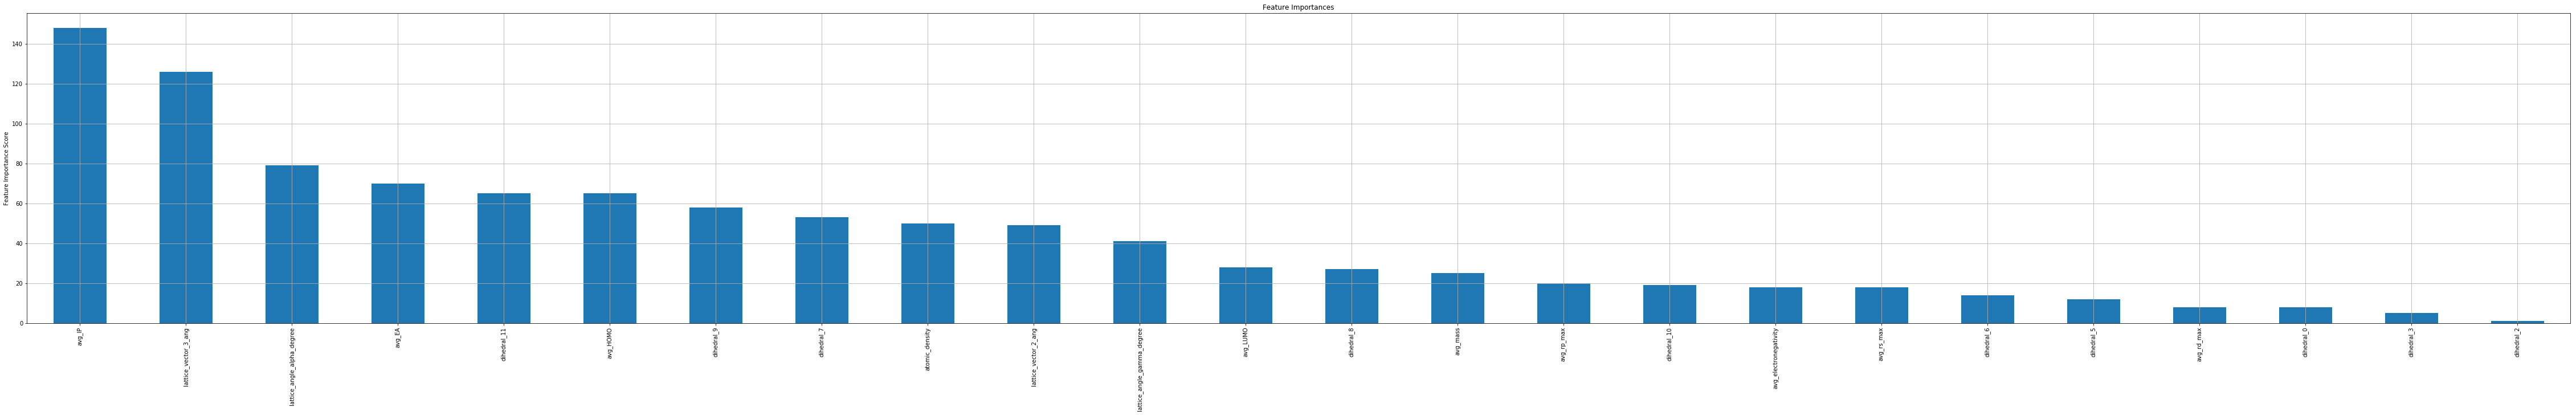

[Fold 2/5]
[0]	train-rmse:0.507817	valid-rmse:0.563647	train-rmsle:0.278946	valid-rmsle:0.31057
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.136565	valid-rmse:0.17118	train-rmsle:0.072694	valid-rmsle:0.094028
[200]	train-rmse:0.102607	valid-rmse:0.144922	train-rmsle:0.057901	valid-rmsle:0.083629
[300]	train-rmse:0.096413	valid-rmse:0.143737	train-rmsle:0.054602	valid-rmsle:0.083284
Stopping. Best iteration:
[259]	train-rmse:0.09824	valid-rmse:0.143417	train-rmsle:0.055642	valid-rmsle:0.083051

[Fold 2/5 Prediciton:]


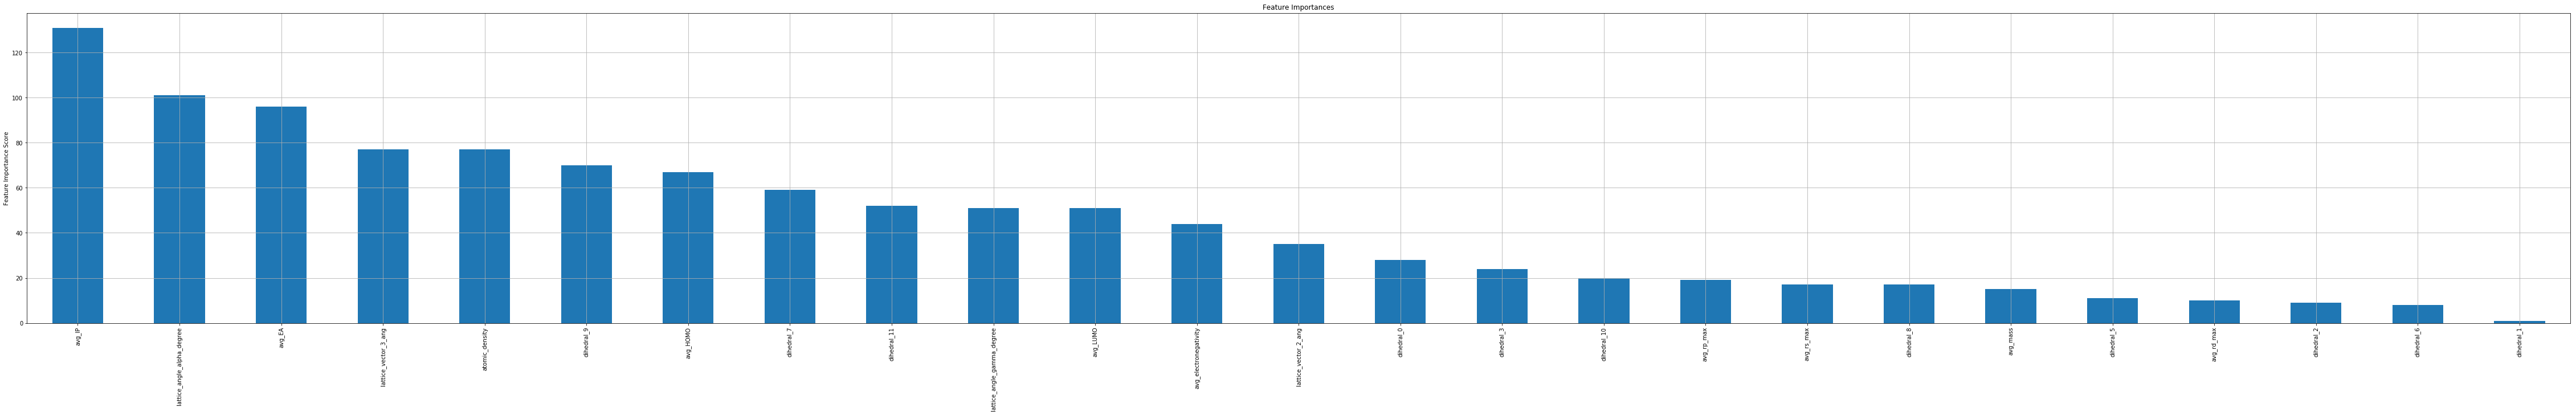

[Fold 3/5]
[0]	train-rmse:0.520981	valid-rmse:0.513375	train-rmsle:0.286725	valid-rmsle:0.280737
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.135533	valid-rmse:0.169224	train-rmsle:0.071171	valid-rmsle:0.092967
[200]	train-rmse:0.100707	valid-rmse:0.149657	train-rmsle:0.05589	valid-rmsle:0.08646
[300]	train-rmse:0.09551	valid-rmse:0.14838	train-rmsle:0.053217	valid-rmsle:0.085864
[400]	train-rmse:0.09358	valid-rmse:0.148211	train-rmsle:0.052083	valid-rmsle:0.085731
Stopping. Best iteration:
[380]	train-rmse:0.093921	valid-rmse:0.148	train-rmsle:0.052268	valid-rmsle:0.085644

[Fold 3/5 Prediciton:]


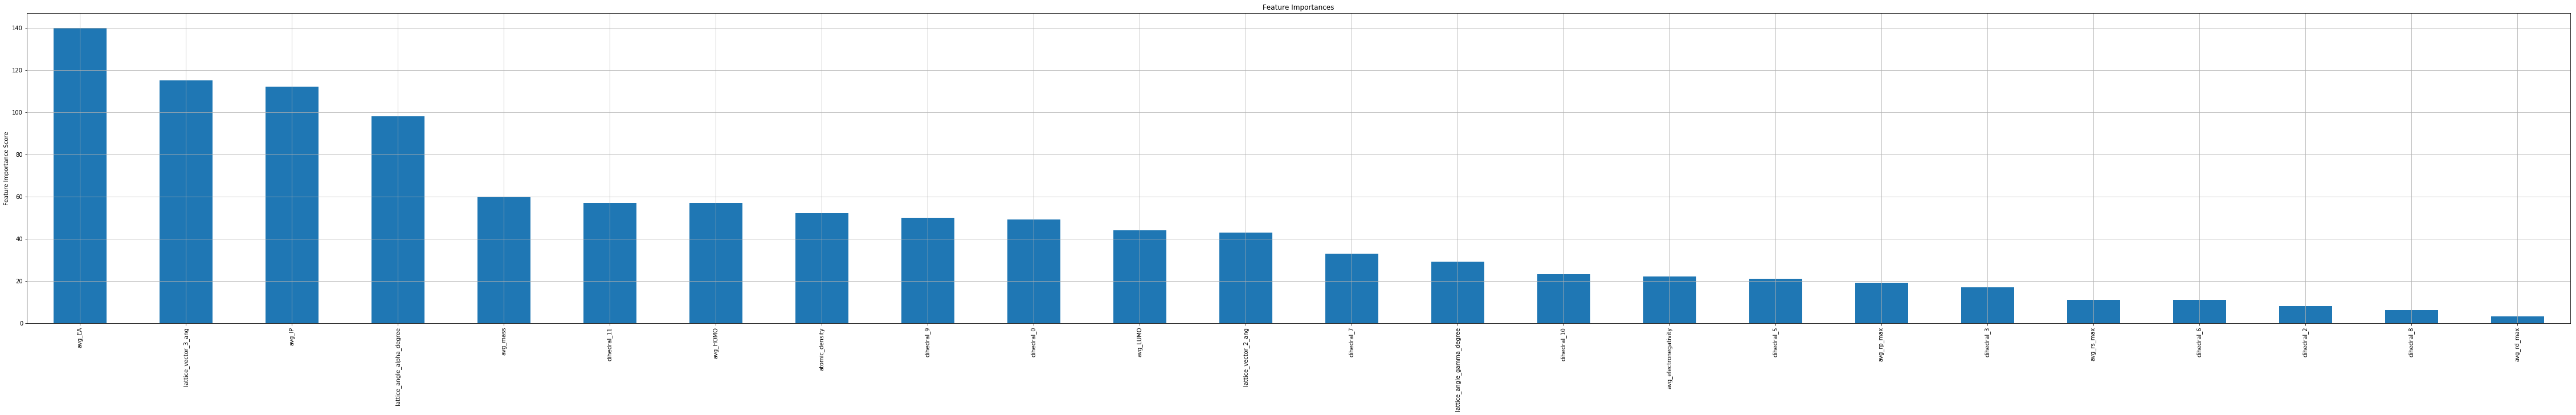

[Fold 4/5]
[0]	train-rmse:0.521135	valid-rmse:0.512696	train-rmsle:0.286369	valid-rmsle:0.282156
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.136193	valid-rmse:0.158236	train-rmsle:0.072596	valid-rmsle:0.085761
[200]	train-rmse:0.100792	valid-rmse:0.147564	train-rmsle:0.057315	valid-rmsle:0.082524
[300]	train-rmse:0.095464	valid-rmse:0.14575	train-rmsle:0.054522	valid-rmsle:0.081762
[400]	train-rmse:0.092567	valid-rmse:0.144874	train-rmsle:0.05287	valid-rmsle:0.081417
[500]	train-rmse:0.090354	valid-rmse:0.143967	train-rmsle:0.051487	valid-rmsle:0.080907
[600]	train-rmse:0.089264	valid-rmse:0.143673	train-rmsle:0.05081	valid-rmsle:0.080767
Stopping. Best iteration:
[520]	train-rmse:0.089994	valid-rmse:0.143624	train-rmsle:0.051226	valid-rmsle:0.080725

[Fold 4/5 Prediciton:]


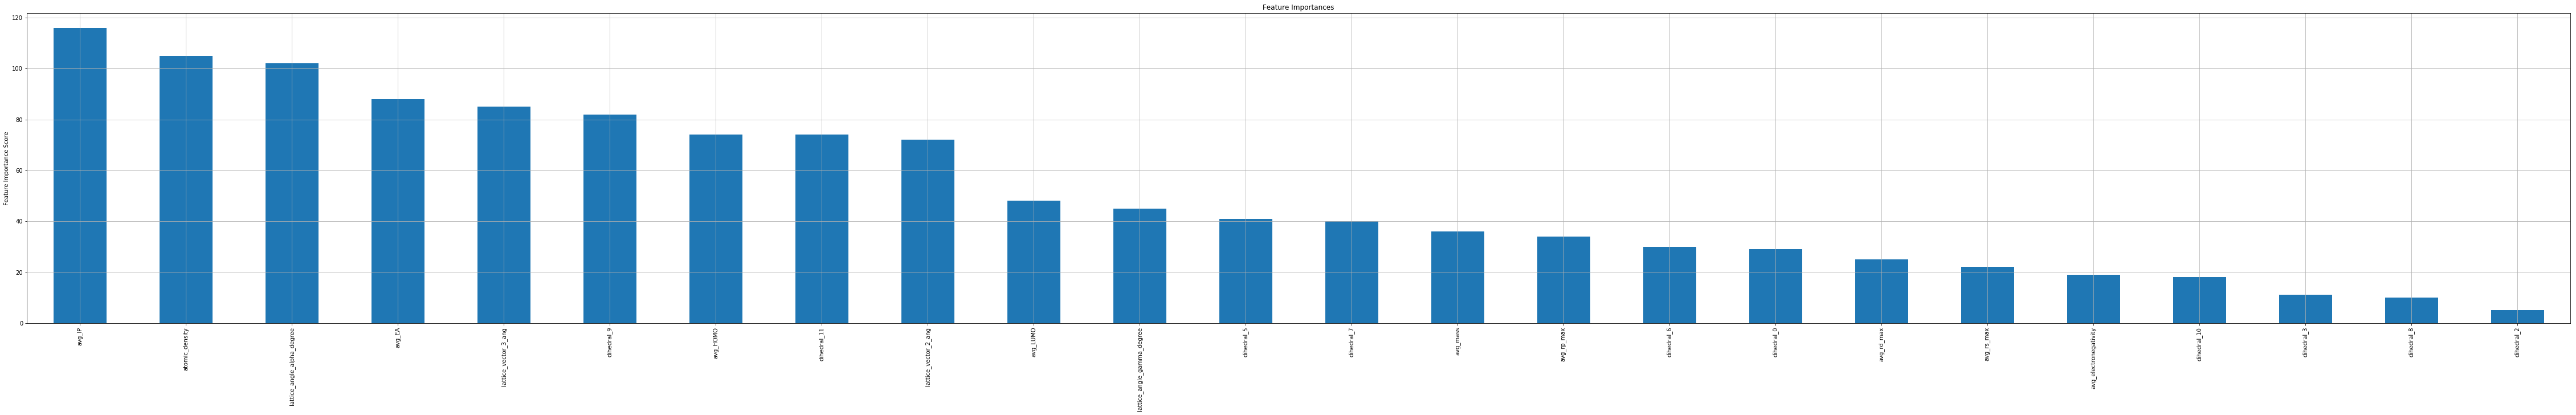

[Fold 5/5]
[0]	train-rmse:0.520024	valid-rmse:0.517794	train-rmsle:0.285591	valid-rmsle:0.285703
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.137426	valid-rmse:0.164171	train-rmsle:0.072545	valid-rmsle:0.092484
[200]	train-rmse:0.103504	valid-rmse:0.152008	train-rmsle:0.057875	valid-rmsle:0.088463
[300]	train-rmse:0.098173	valid-rmse:0.150915	train-rmsle:0.055146	valid-rmsle:0.087838
[400]	train-rmse:0.094811	valid-rmse:0.149104	train-rmsle:0.053202	valid-rmsle:0.086739
[500]	train-rmse:0.093394	valid-rmse:0.147997	train-rmsle:0.052417	valid-rmsle:0.086134
[600]	train-rmse:0.092306	valid-rmse:0.147601	train-rmsle:0.051839	valid-rmsle:0.085916
[700]	train-rmse:0.091494	valid-rmse:0.147807	train-rmsle:0.051312	valid-rmsle:0.086039
Stopping. Best iteration:
[604]	train-rmse:0.092166	valid-rmse:0.147504	train-rmsle:0.051747	valid-rmsle:0.085873

[Fold 5/5 Prediciton:]


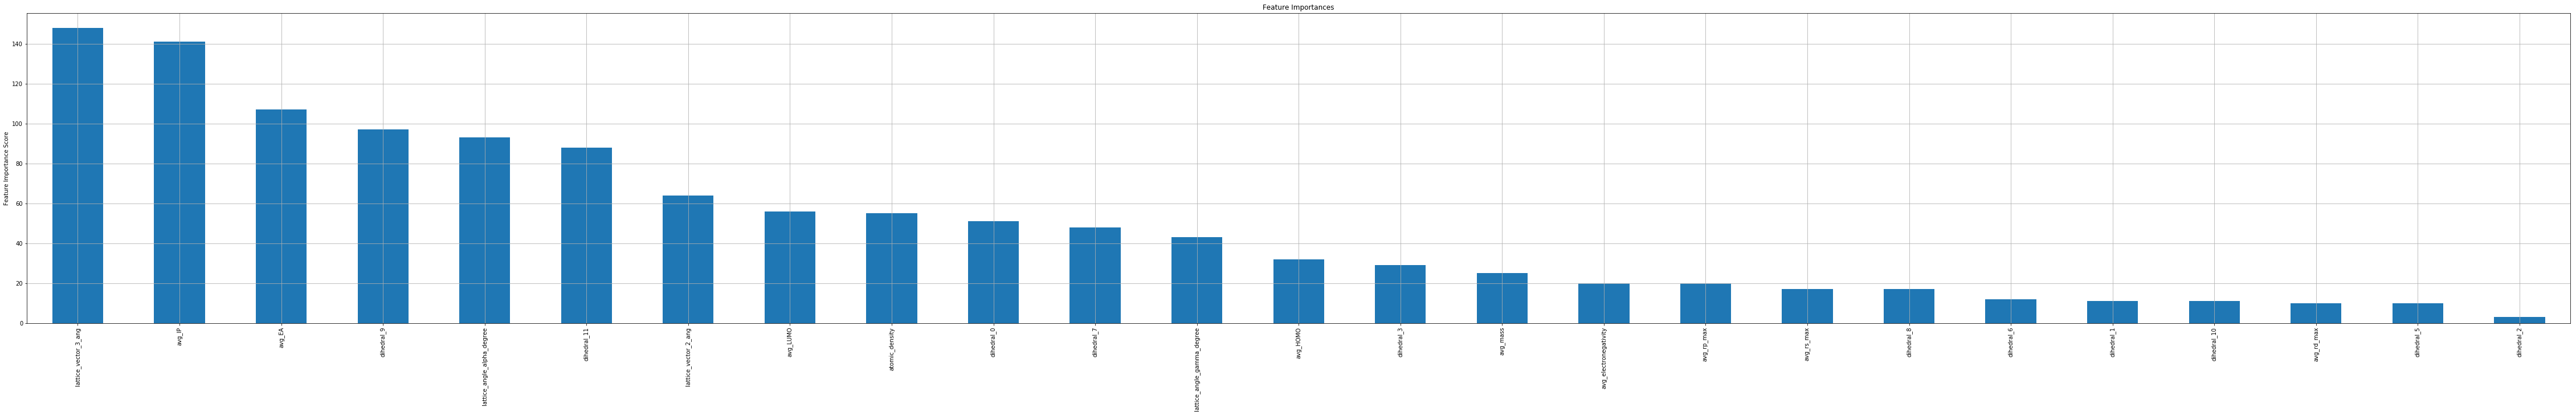

--------------------------------------
cluster: 3
--------------------------------------
[Fold 1/5]
[0]	train-rmse:0.803173	valid-rmse:0.742953	train-rmsle:0.400163	valid-rmsle:0.376312
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.030851	valid-rmse:0.034694	train-rmsle:0.014063	valid-rmsle:0.017657
Stopping. Best iteration:
[39]	train-rmse:0.034277	valid-rmse:0.034887	train-rmsle:0.014828	valid-rmsle:0.017152

[Fold 1/5 Prediciton:]


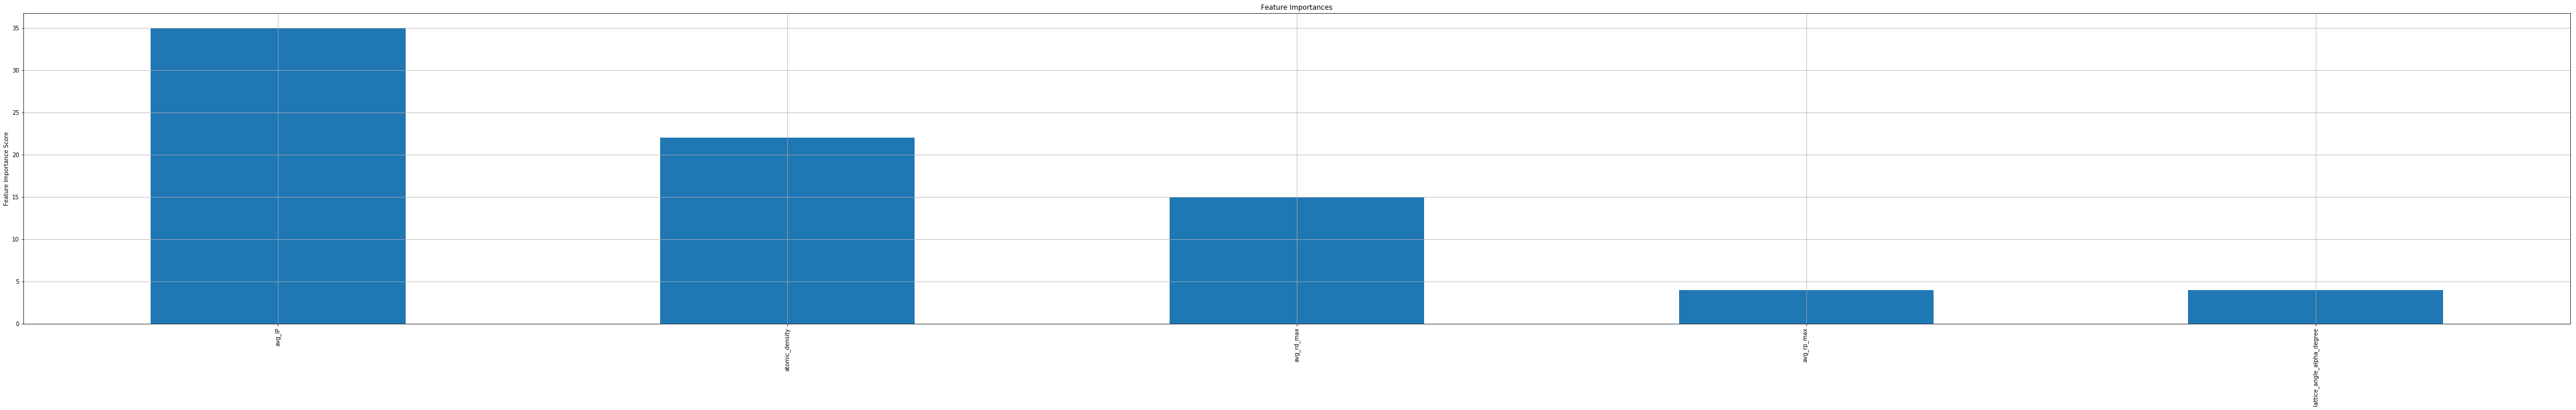

[Fold 2/5]
[0]	train-rmse:0.789446	valid-rmse:0.802274	train-rmsle:0.395087	valid-rmsle:0.399029
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.0307	valid-rmse:0.029002	train-rmsle:0.01411	valid-rmsle:0.013568
Stopping. Best iteration:
[51]	train-rmse:0.030926	valid-rmse:0.028854	train-rmsle:0.013958	valid-rmsle:0.013247

[Fold 2/5 Prediciton:]


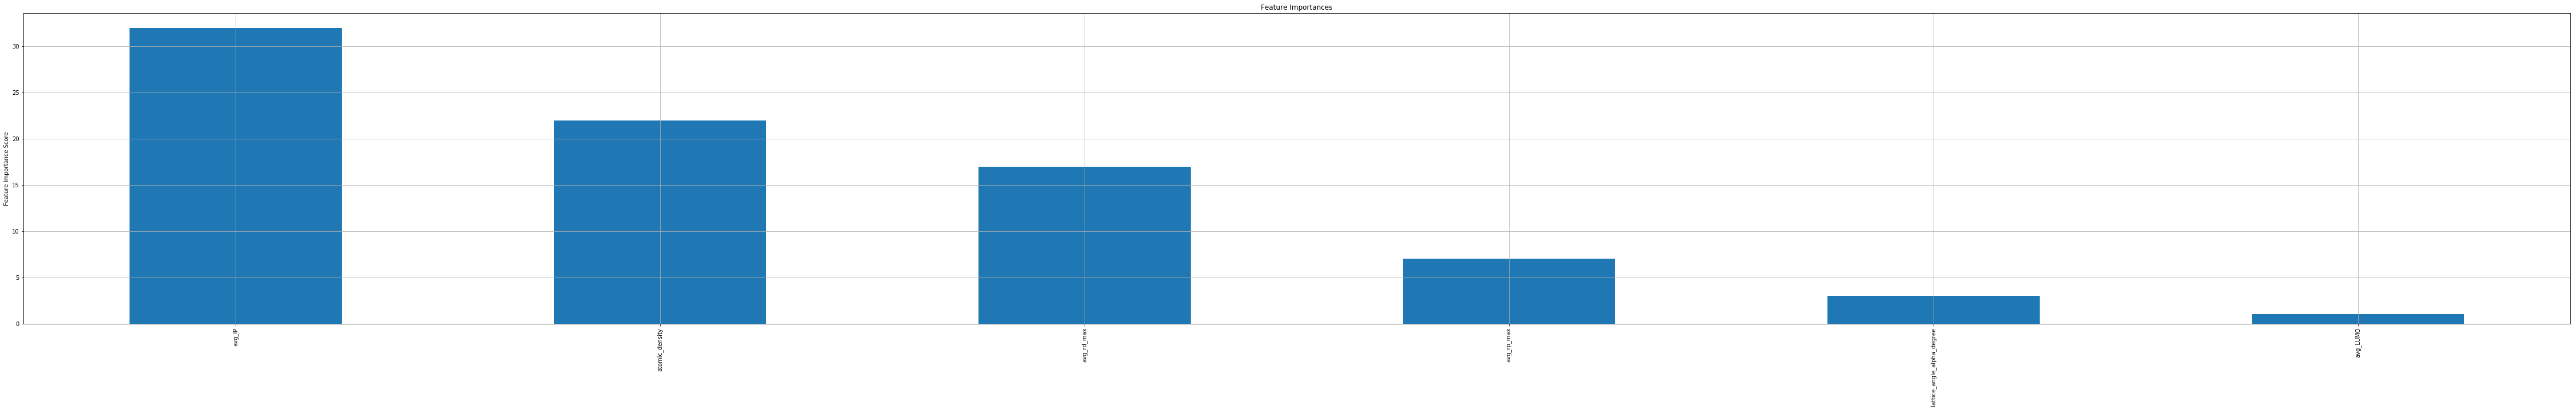

[Fold 3/5]
[0]	train-rmse:0.786051	valid-rmse:0.811891	train-rmsle:0.392803	valid-rmsle:0.405683
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.030201	valid-rmse:0.030297	train-rmsle:0.013887	valid-rmsle:0.013492
[200]	train-rmse:0.029536	valid-rmse:0.029959	train-rmsle:0.013641	valid-rmsle:0.01336
[300]	train-rmse:0.029536	valid-rmse:0.029955	train-rmsle:0.013636	valid-rmsle:0.013355
Stopping. Best iteration:
[245]	train-rmse:0.029541	valid-rmse:0.029927	train-rmsle:0.013599	valid-rmsle:0.013327

[Fold 3/5 Prediciton:]


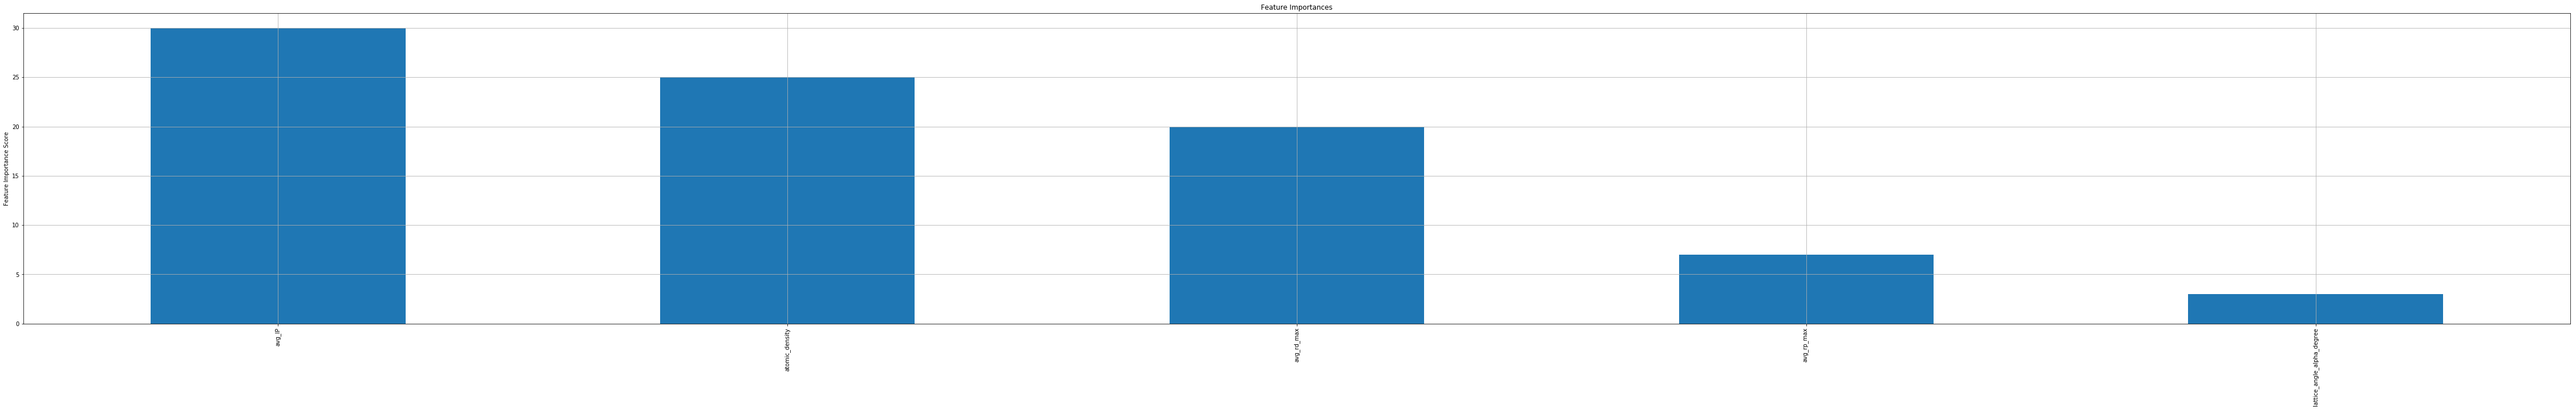

[Fold 4/5]
[0]	train-rmse:0.776454	valid-rmse:0.849545	train-rmsle:0.388929	valid-rmsle:0.421513
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.031087	valid-rmse:0.024819	train-rmsle:0.01435	valid-rmsle:0.011797
Stopping. Best iteration:
[52]	train-rmse:0.031237	valid-rmse:0.025063	train-rmsle:0.014261	valid-rmsle:0.011754

[Fold 4/5 Prediciton:]


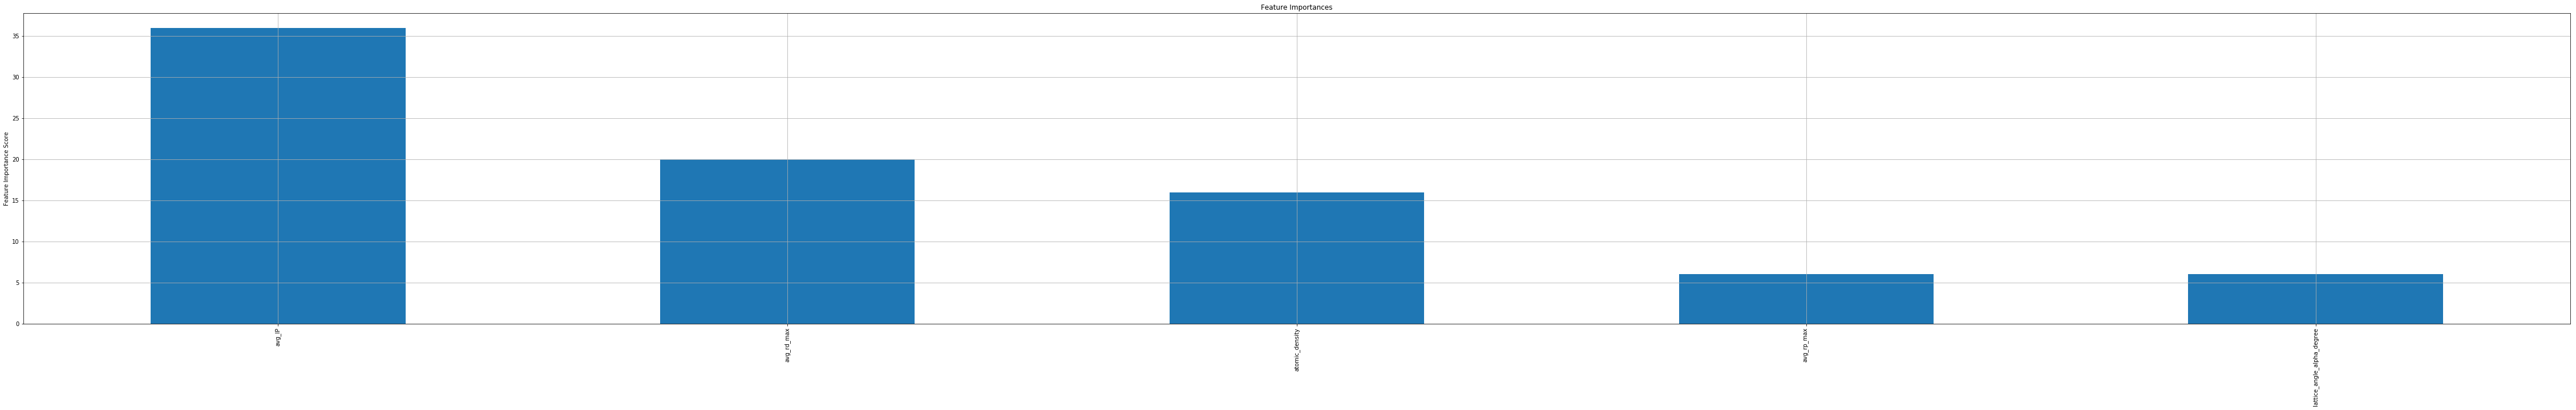

[Fold 5/5]
[0]	train-rmse:0.794526	valid-rmse:0.783689	train-rmsle:0.396834	valid-rmsle:0.393224
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.029508	valid-rmse:0.033987	train-rmsle:0.013522	valid-rmsle:0.015844
Stopping. Best iteration:
[37]	train-rmse:0.03411	valid-rmse:0.032659	train-rmsle:0.014437	valid-rmsle:0.014553

[Fold 5/5 Prediciton:]


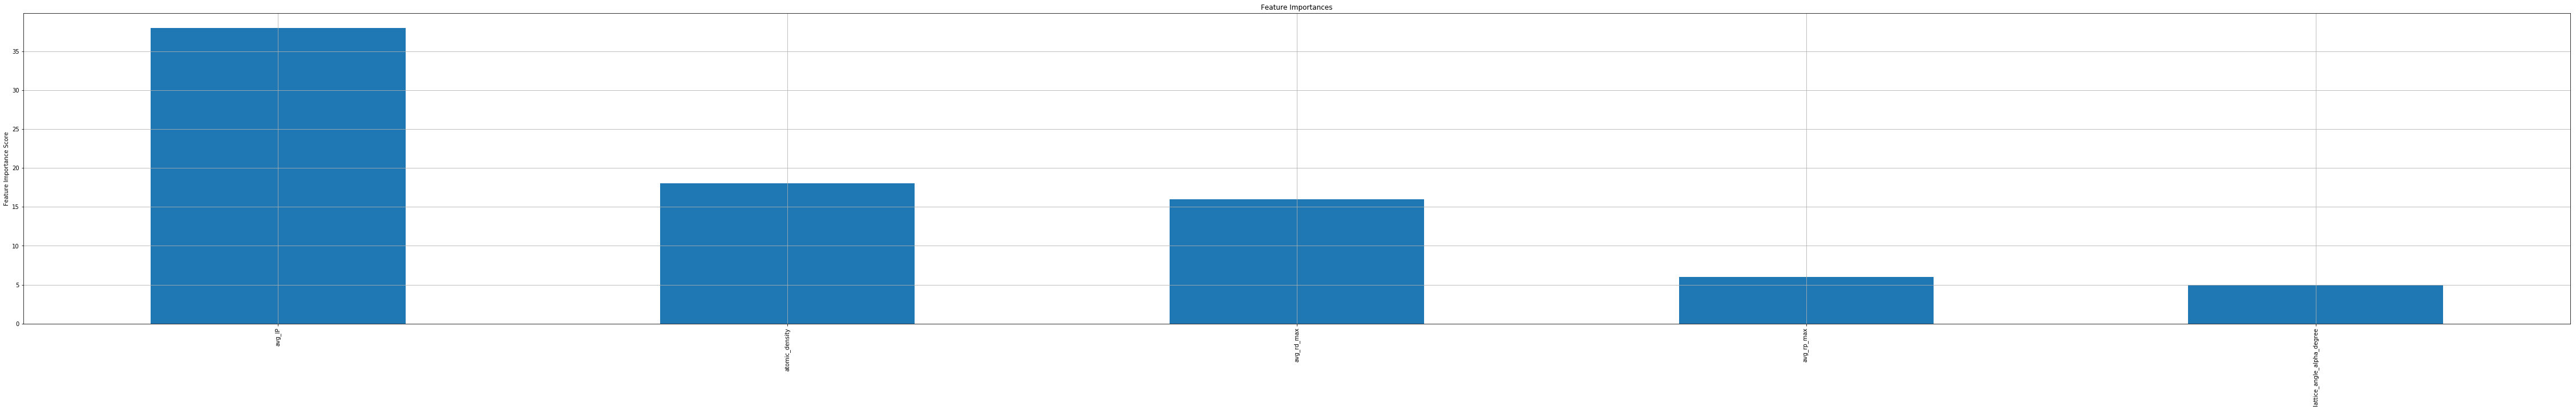

--------------------------------------
cluster: 4
--------------------------------------
[Fold 1/5]
[0]	train-rmse:0.613085	valid-rmse:0.603735	train-rmsle:0.316539	valid-rmsle:0.312697
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.030144	valid-rmse:0.054613	train-rmsle:0.015276	valid-rmsle:0.025064
Stopping. Best iteration:
[56]	train-rmse:0.03019	valid-rmse:0.05469	train-rmsle:0.015194	valid-rmsle:0.025052

[Fold 1/5 Prediciton:]


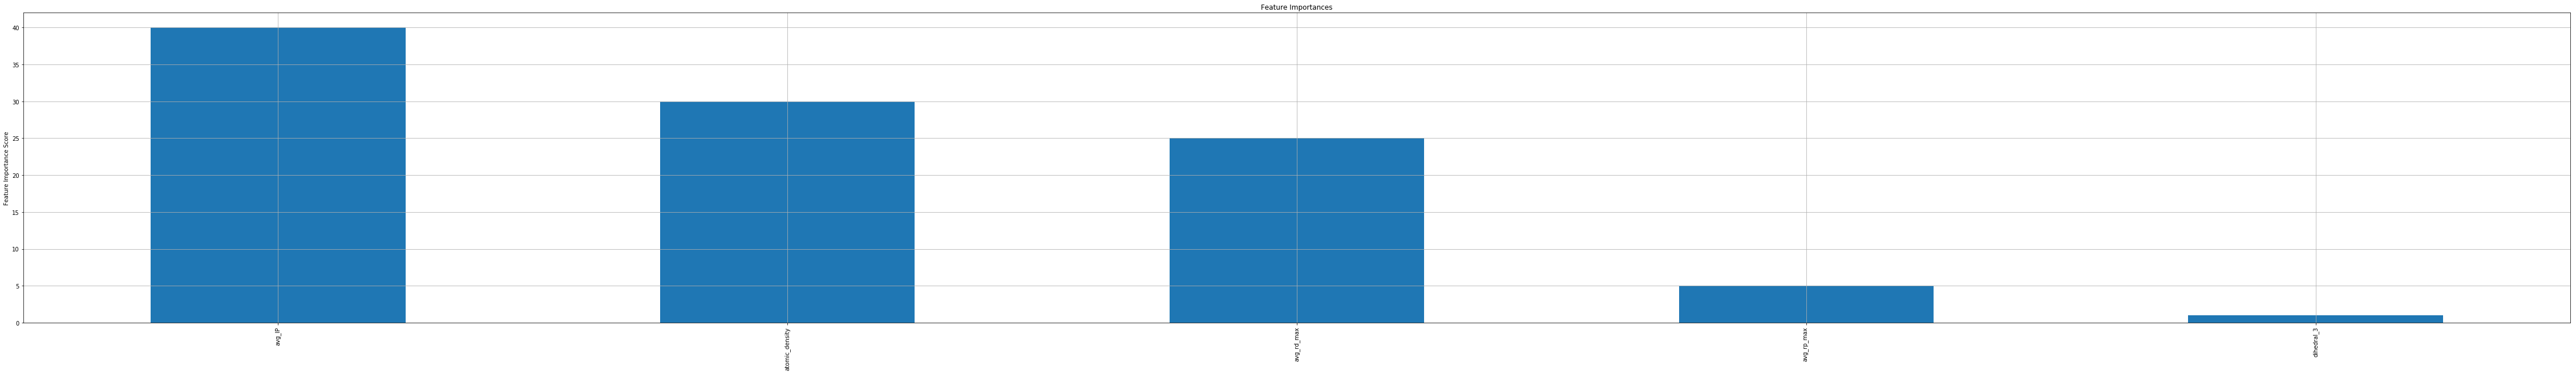

[Fold 2/5]
[0]	train-rmse:0.622282	valid-rmse:0.564209	train-rmsle:0.320786	valid-rmsle:0.294346
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.034662	valid-rmse:0.039243	train-rmsle:0.01692	valid-rmsle:0.019241
[200]	train-rmse:0.034662	valid-rmse:0.039233	train-rmsle:0.016906	valid-rmsle:0.019231
[300]	train-rmse:0.034662	valid-rmse:0.039243	train-rmsle:0.01692	valid-rmsle:0.019241
[400]	train-rmse:0.034664	valid-rmse:0.039251	train-rmsle:0.016929	valid-rmsle:0.019247
Stopping. Best iteration:
[320]	train-rmse:0.034664	valid-rmse:0.039224	train-rmsle:0.016893	valid-rmsle:0.019223

[Fold 2/5 Prediciton:]


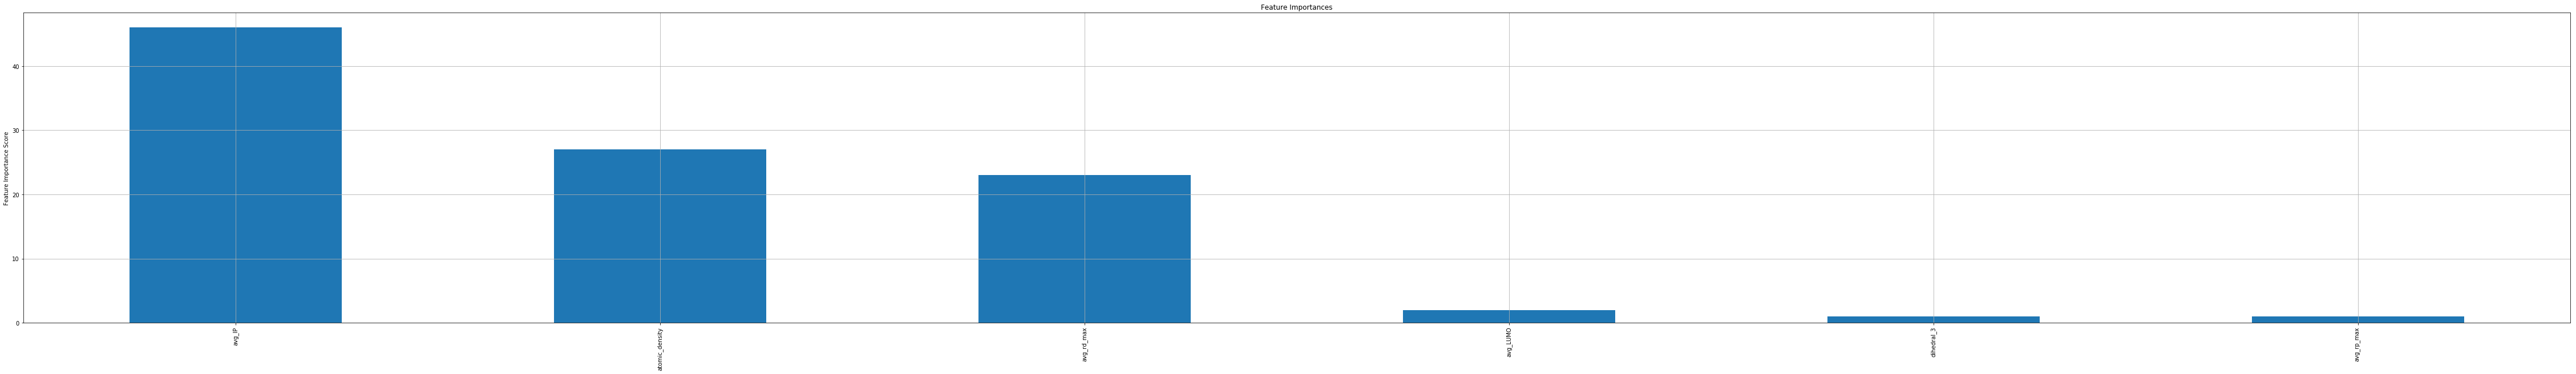

[Fold 3/5]
[0]	train-rmse:0.612704	valid-rmse:0.605537	train-rmsle:0.316212	valid-rmsle:0.313925
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.027873	valid-rmse:0.061406	train-rmsle:0.014226	valid-rmsle:0.028457
Stopping. Best iteration:
[37]	train-rmse:0.031136	valid-rmse:0.061018	train-rmsle:0.014987	valid-rmsle:0.027925

[Fold 3/5 Prediciton:]


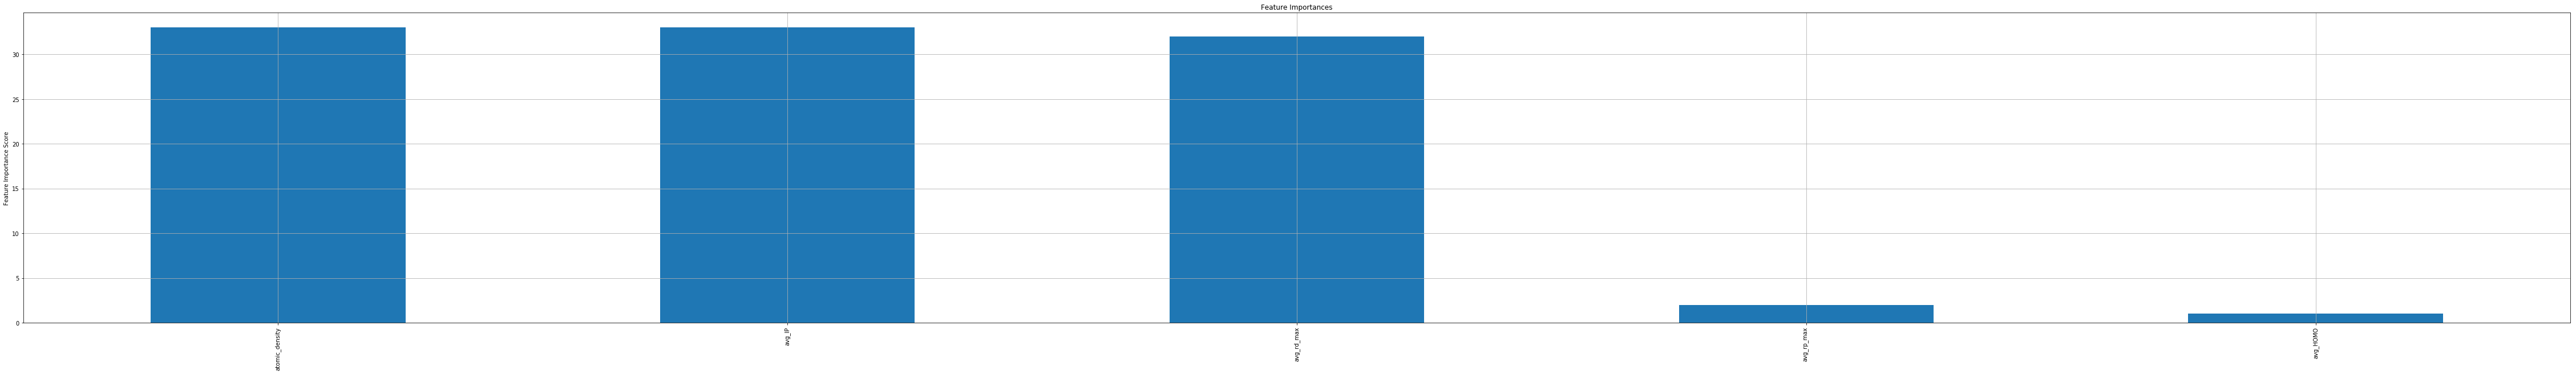

[Fold 4/5]
[0]	train-rmse:0.616885	valid-rmse:0.587521	train-rmsle:0.317842	valid-rmsle:0.306818
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.037256	valid-rmse:0.029189	train-rmsle:0.018022	valid-rmsle:0.015336
[200]	train-rmse:0.036973	valid-rmse:0.028978	train-rmsle:0.017907	valid-rmsle:0.015253
Stopping. Best iteration:
[130]	train-rmse:0.036975	valid-rmse:0.028987	train-rmsle:0.017898	valid-rmsle:0.015251

[Fold 4/5 Prediciton:]


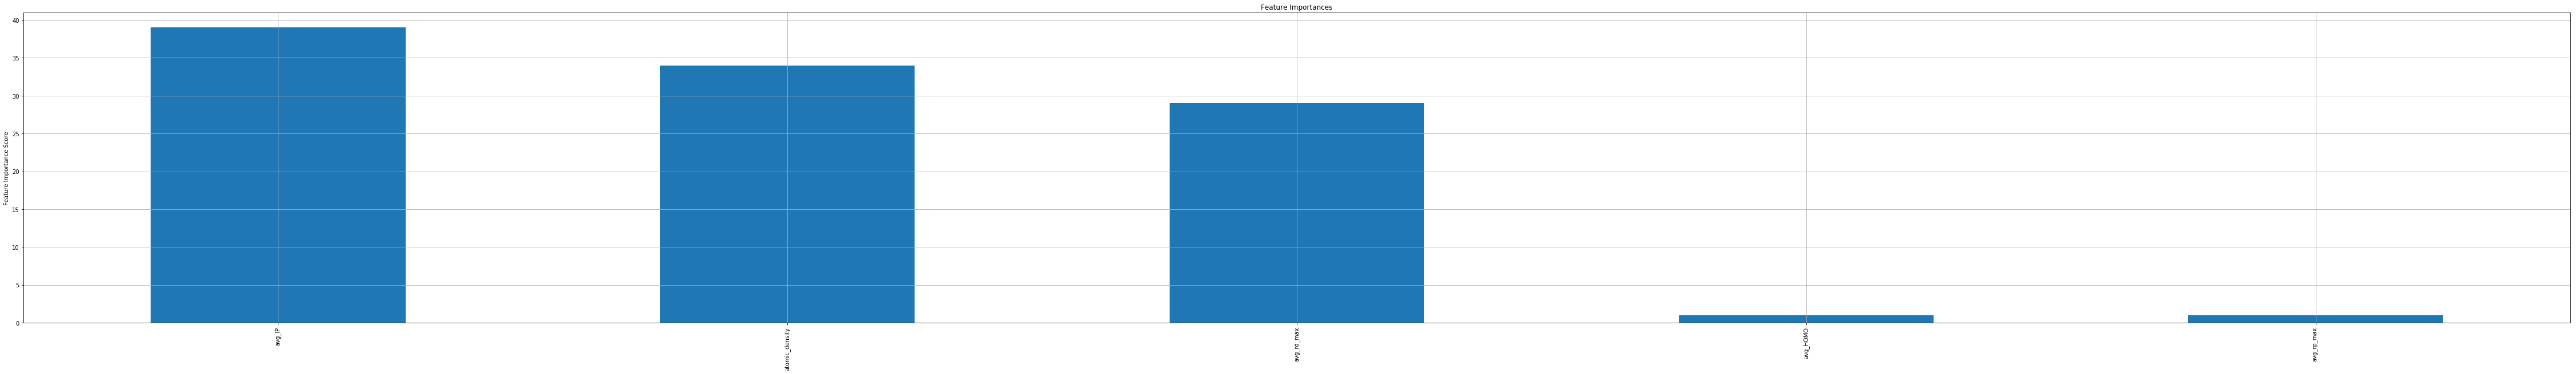

[Fold 5/5]
[0]	train-rmse:0.618459	valid-rmse:0.580501	train-rmsle:0.318865	valid-rmsle:0.30251
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.036352	valid-rmse:0.031726	train-rmsle:0.017492	valid-rmsle:0.016061
Stopping. Best iteration:
[93]	train-rmse:0.036351	valid-rmse:0.031687	train-rmsle:0.017513	valid-rmsle:0.016056

[Fold 5/5 Prediciton:]


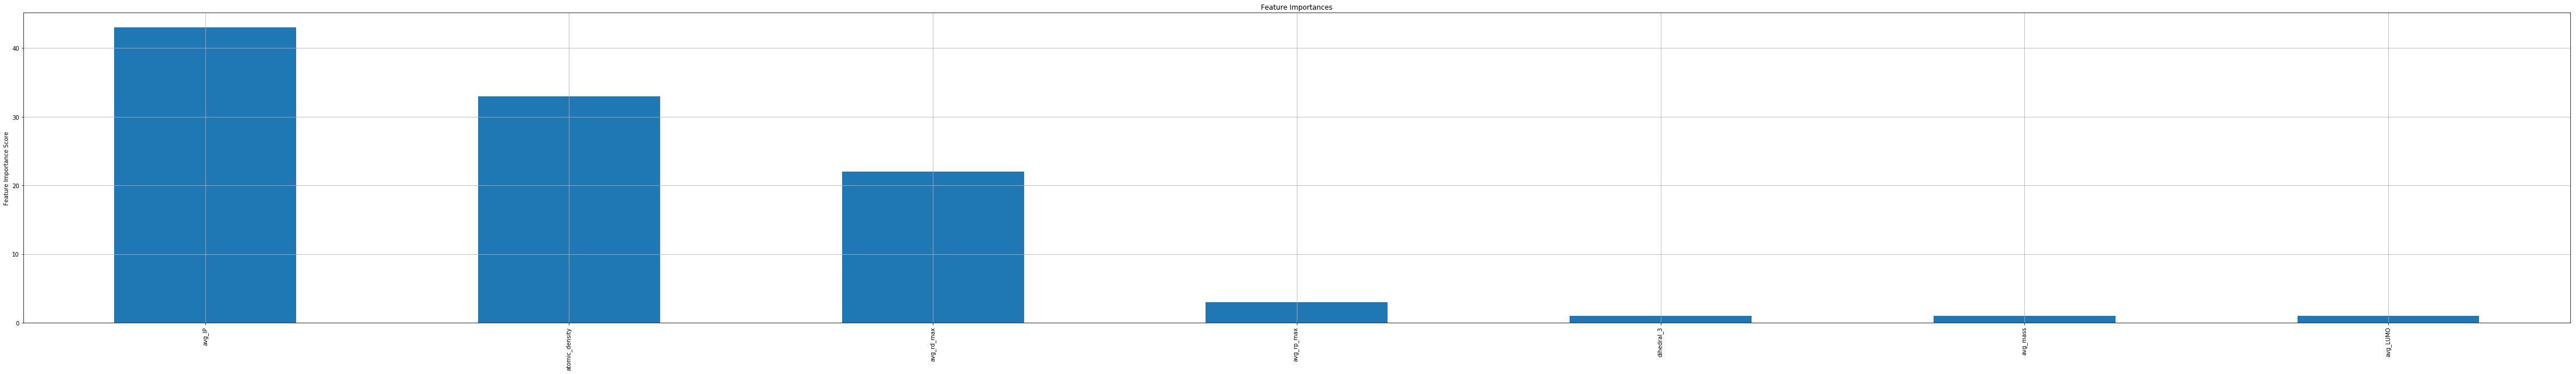

--------------------------------------
cluster: 5
--------------------------------------
[Fold 1/5]
[Fold 1/5 validation score: 0.041898408581362394]
[Fold 2/5]
[Fold 2/5 validation score: 0.03758174144119353]
[Fold 3/5]
[Fold 3/5 validation score: 0.03861127553532841]
[Fold 4/5]
[Fold 4/5 validation score: 0.037405808916354075]
[Fold 5/5]
[Fold 5/5 validation score: 0.040828091387366316]
--------------------------------------
cluster: 6
--------------------------------------
[Fold 1/5]
[0]	train-rmse:0.638267	valid-rmse:0.62873	train-rmsle:0.305954	valid-rmsle:0.30848
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.050247	valid-rmse:0.039344	train-rmsle:0.023543	valid-rmsle:0.019102
Stopping. Best iteration:
[90]	train-rmse:0.050221	valid-rmse:0.038908	train-rmsle:0.023871	valid-rmsle:0.019031

[Fold 1/5 Prediciton:]


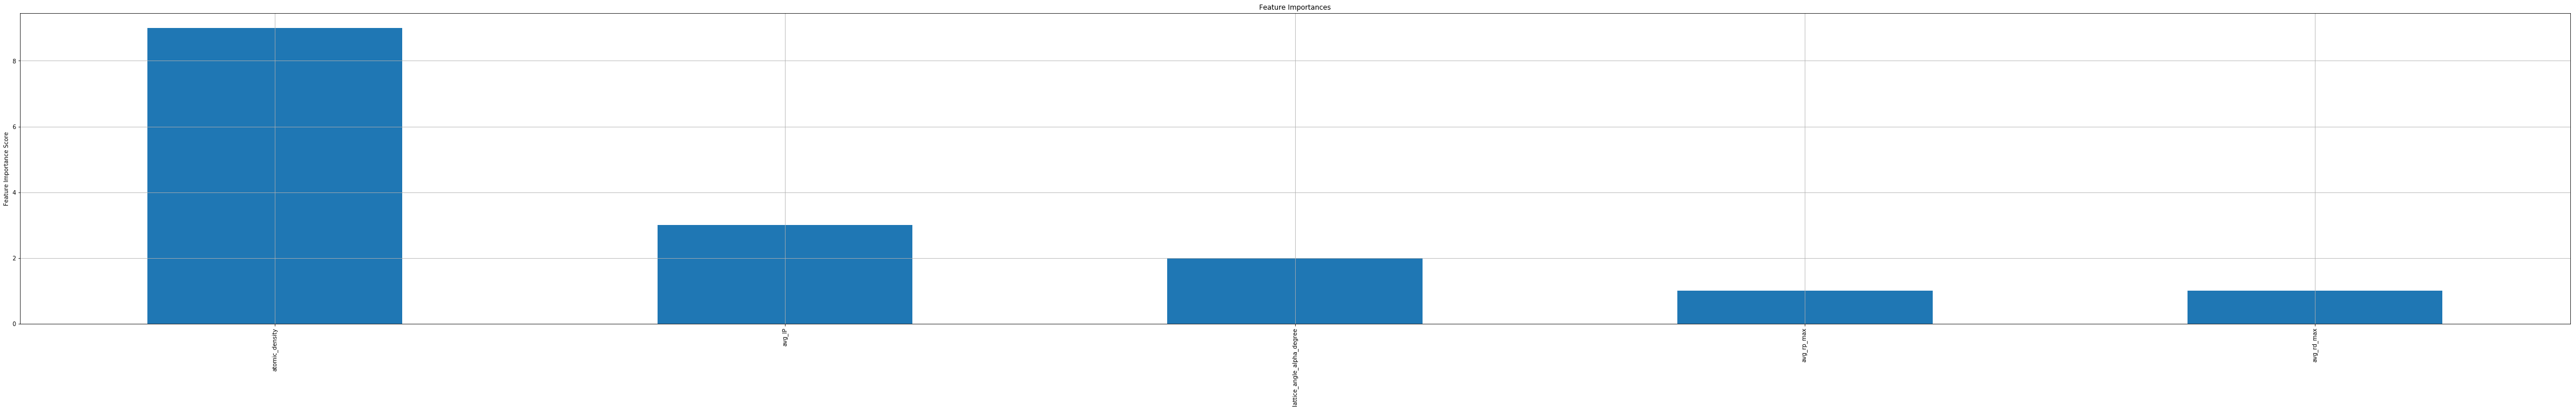

[Fold 2/5]
[0]	train-rmse:0.648482	valid-rmse:0.555866	train-rmsle:0.311576	valid-rmsle:0.267354
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.046818	valid-rmse:0.071229	train-rmsle:0.022119	valid-rmsle:0.028403
[200]	train-rmse:0.046828	valid-rmse:0.071643	train-rmsle:0.021985	valid-rmsle:0.028517
Stopping. Best iteration:
[104]	train-rmse:0.047062	valid-rmse:0.070091	train-rmsle:0.022653	valid-rmsle:0.028152

[Fold 2/5 Prediciton:]


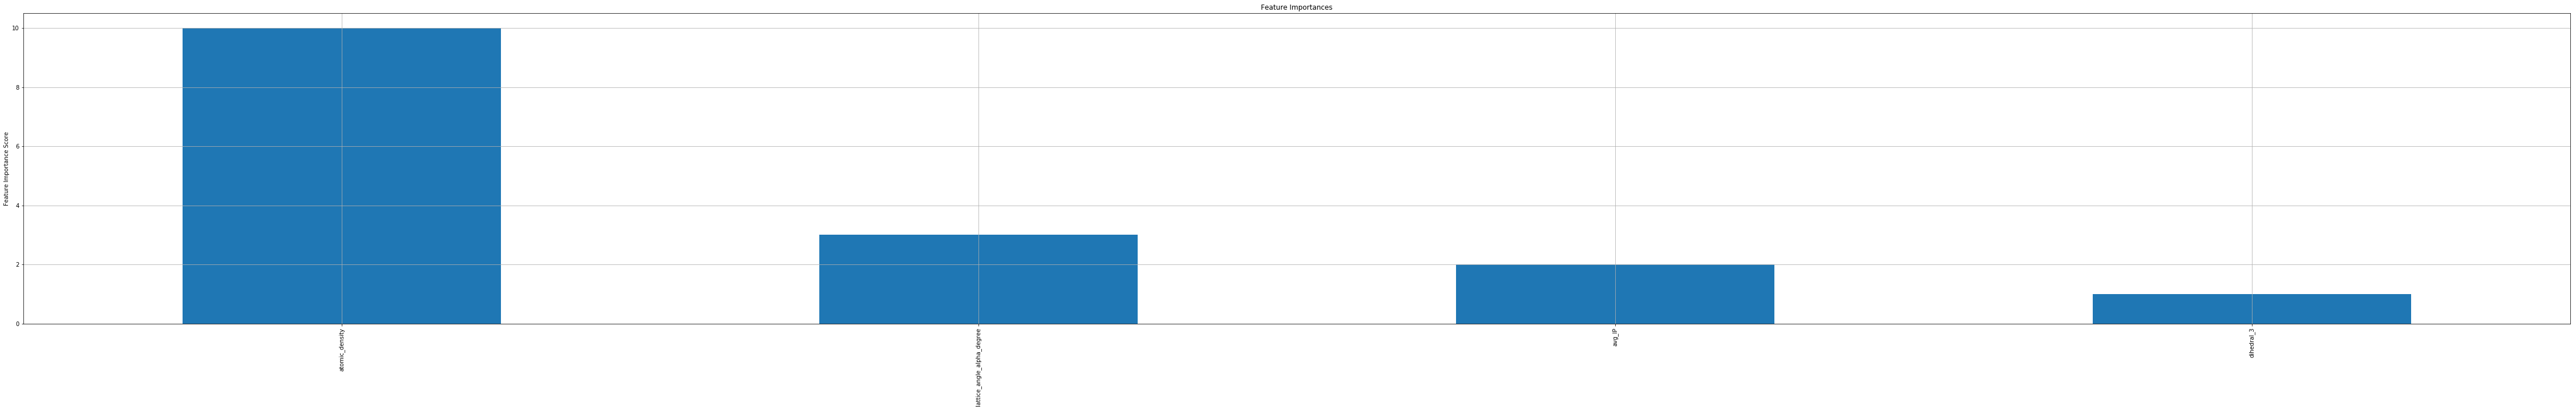

[Fold 3/5]
[0]	train-rmse:0.649868	valid-rmse:0.57712	train-rmsle:0.311941	valid-rmsle:0.284572
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.047189	valid-rmse:0.068181	train-rmsle:0.022108	valid-rmsle:0.033996
Stopping. Best iteration:
[64]	train-rmse:0.047556	valid-rmse:0.067108	train-rmsle:0.022867	valid-rmsle:0.033829

[Fold 3/5 Prediciton:]


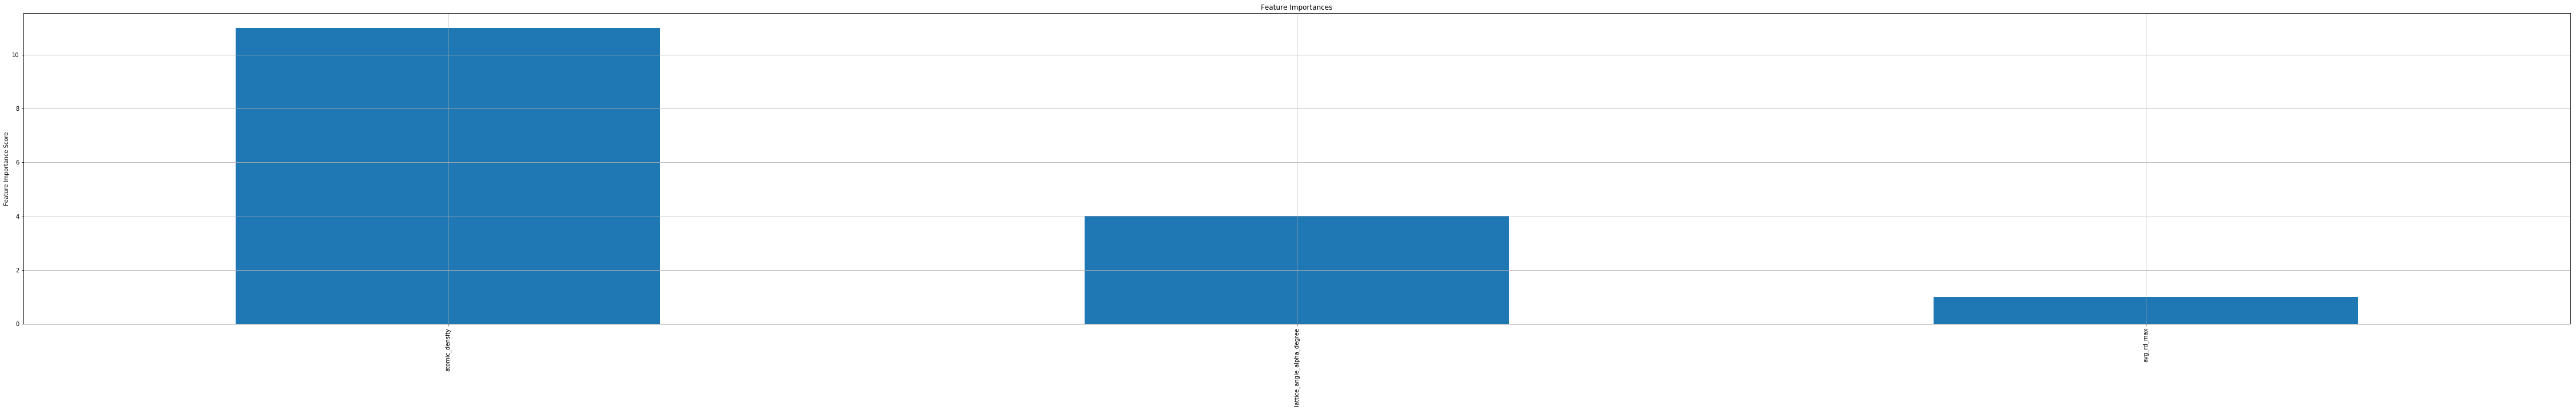

[Fold 4/5]
[0]	train-rmse:0.62189	valid-rmse:0.672572	train-rmsle:0.300094	valid-rmsle:0.321058
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.048447	valid-rmse:0.09792	train-rmsle:0.023266	valid-rmsle:0.04005
[200]	train-rmse:0.048424	valid-rmse:0.098043	train-rmsle:0.023229	valid-rmsle:0.040094
Stopping. Best iteration:
[193]	train-rmse:0.048707	valid-rmse:0.096907	train-rmsle:0.023607	valid-rmsle:0.039698

[Fold 4/5 Prediciton:]


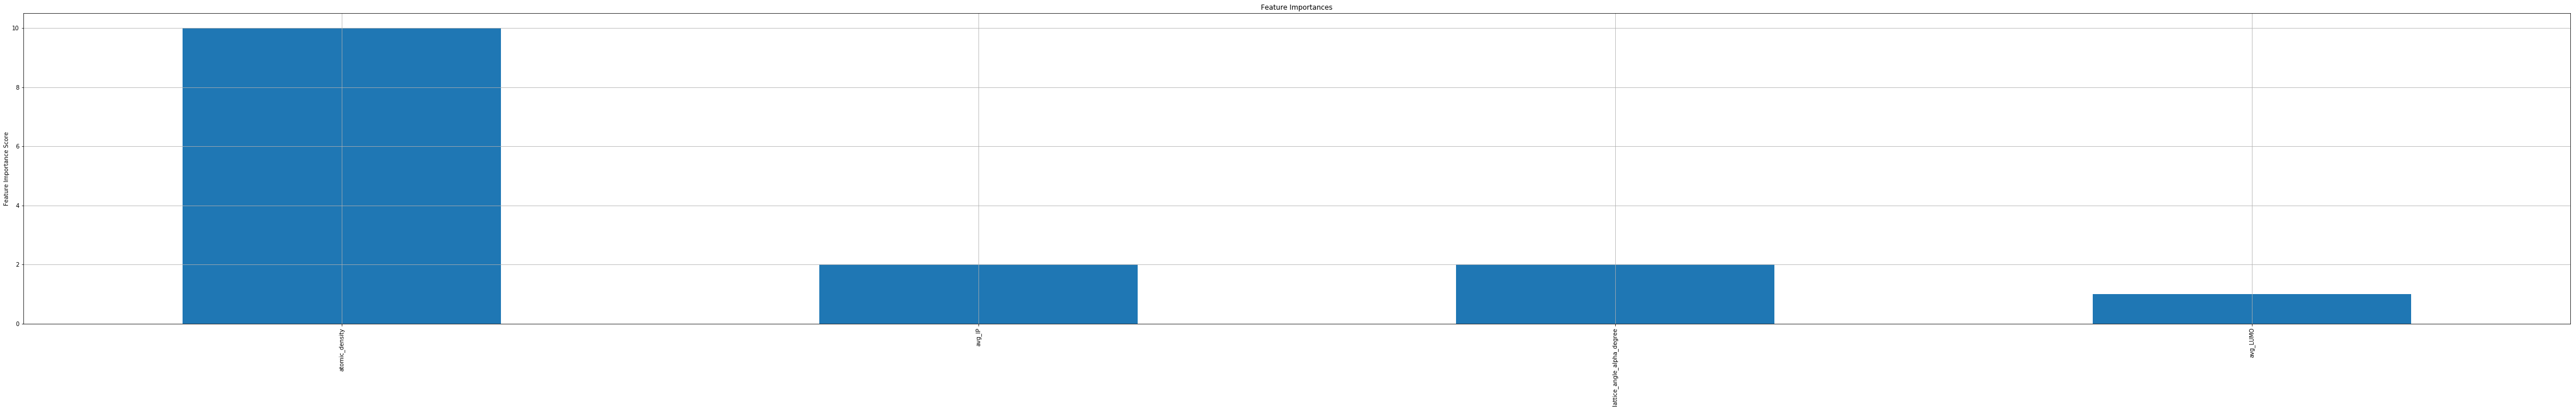

[Fold 5/5]
[0]	train-rmse:0.64615	valid-rmse:0.524497	train-rmsle:0.308497	valid-rmsle:0.258856
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.05495	valid-rmse:0.04141	train-rmsle:0.025048	valid-rmsle:0.018762
Stopping. Best iteration:
[15]	train-rmse:0.056233	valid-rmse:0.042219	train-rmsle:0.024508	valid-rmsle:0.018143

[Fold 5/5 Prediciton:]


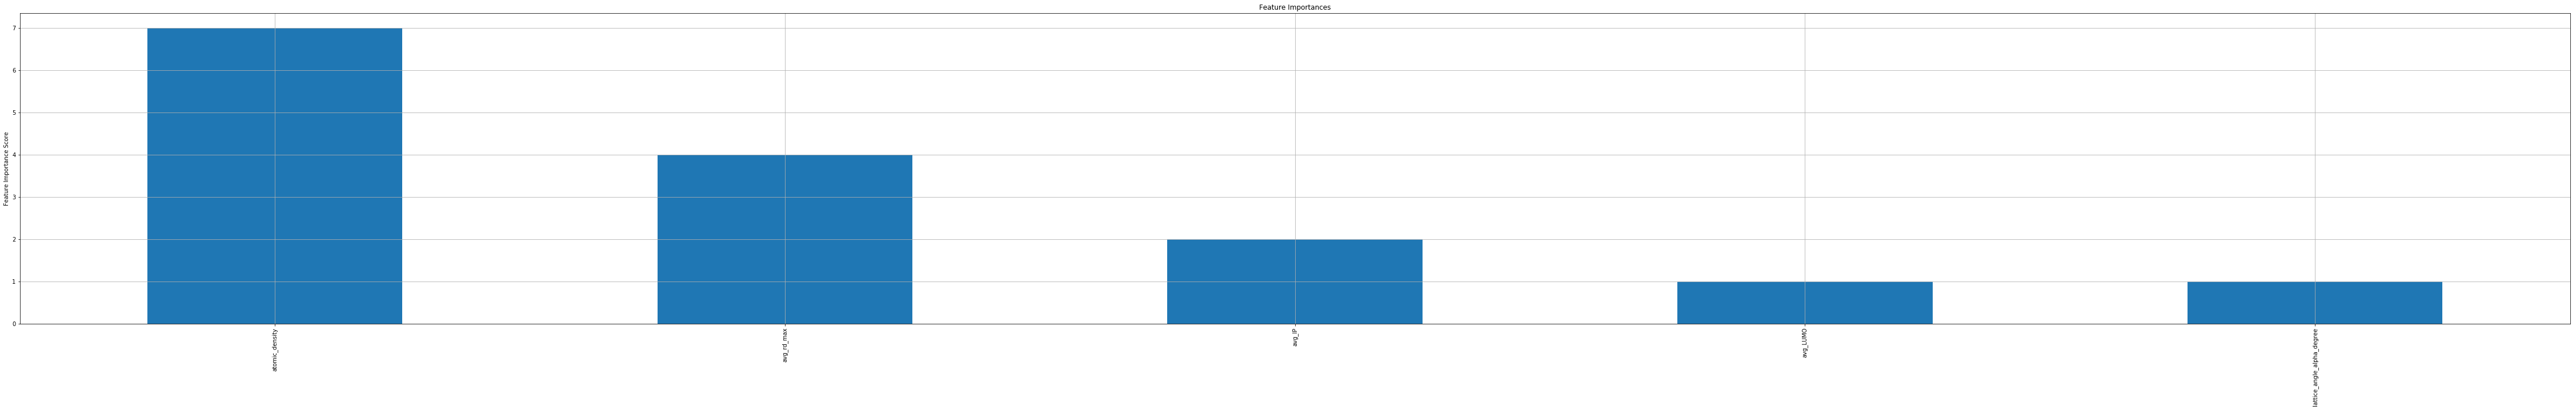

--------------------------------------
cluster: 7
--------------------------------------
[Fold 1/5]
[0]	train-rmse:0.617933	valid-rmse:0.506738	train-rmsle:0.317985	valid-rmsle:0.266415
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.041177	valid-rmse:0.048399	train-rmsle:0.0204	valid-rmsle:0.025624
[200]	train-rmse:0.040044	valid-rmse:0.047542	train-rmsle:0.019983	valid-rmsle:0.025323
Stopping. Best iteration:
[149]	train-rmse:0.040057	valid-rmse:0.047594	train-rmsle:0.019899	valid-rmsle:0.025271

[Fold 1/5 Prediciton:]


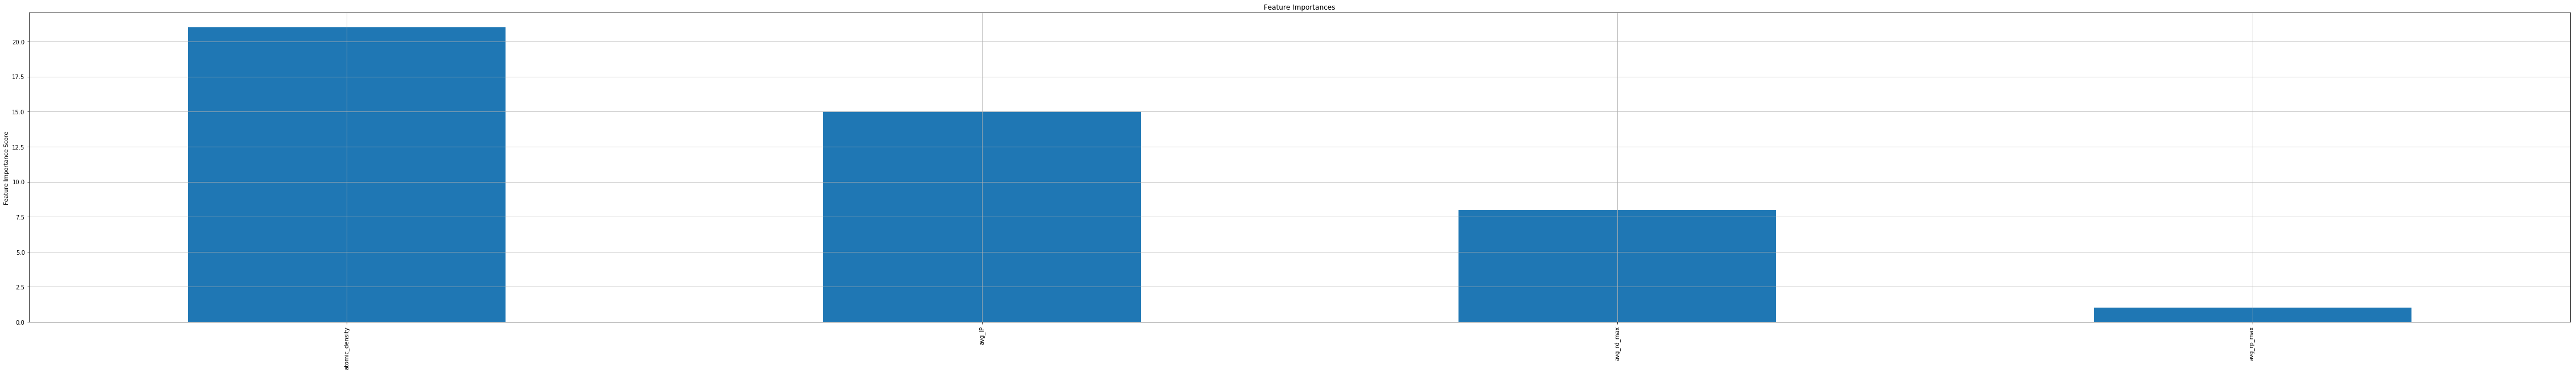

[Fold 2/5]
[0]	train-rmse:0.60711	valid-rmse:0.55345	train-rmsle:0.312284	valid-rmsle:0.290469
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.040416	valid-rmse:0.054339	train-rmsle:0.020515	valid-rmsle:0.02619
Stopping. Best iteration:
[54]	train-rmse:0.04045	valid-rmse:0.054154	train-rmsle:0.020384	valid-rmsle:0.025992

[Fold 2/5 Prediciton:]


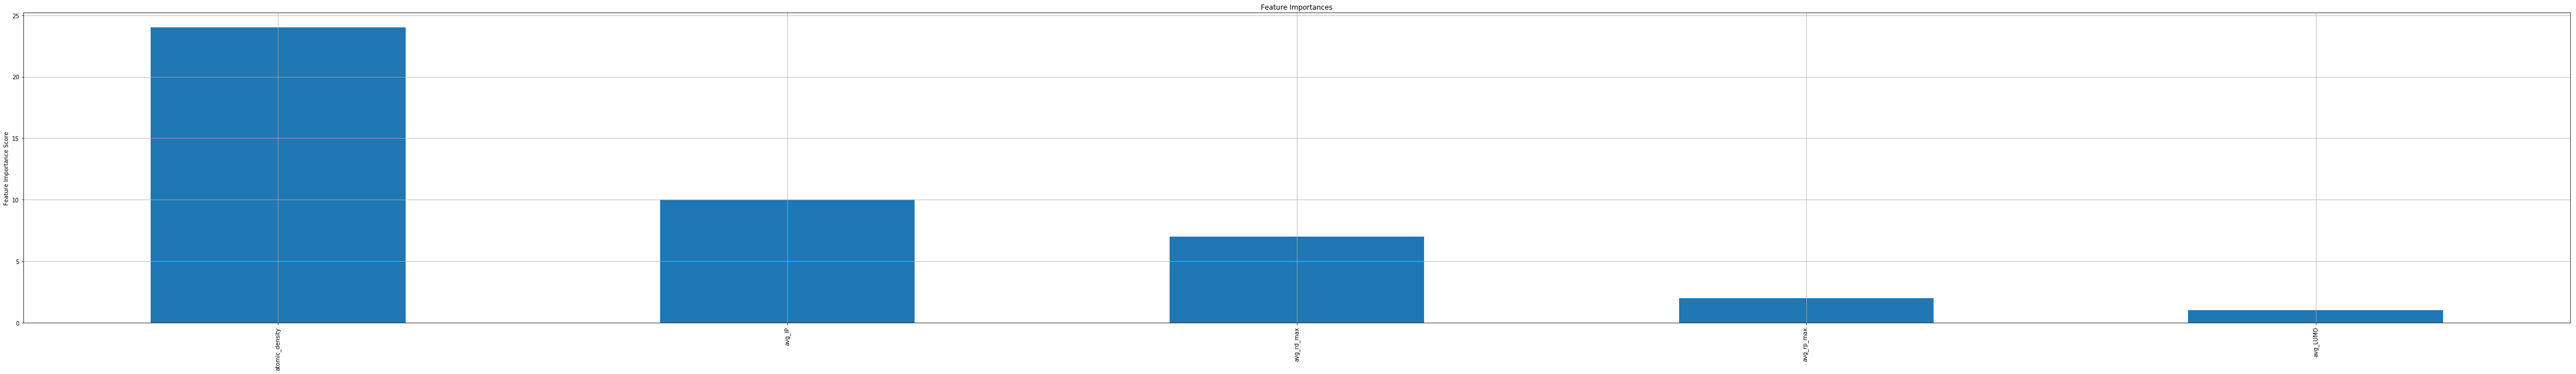

[Fold 3/5]
[0]	train-rmse:0.610806	valid-rmse:0.5344	train-rmsle:0.314157	valid-rmsle:0.280492
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.039722	valid-rmse:0.055507	train-rmsle:0.020294	valid-rmsle:0.027839
Stopping. Best iteration:
[41]	train-rmse:0.042932	valid-rmse:0.055396	train-rmsle:0.020921	valid-rmsle:0.027234

[Fold 3/5 Prediciton:]


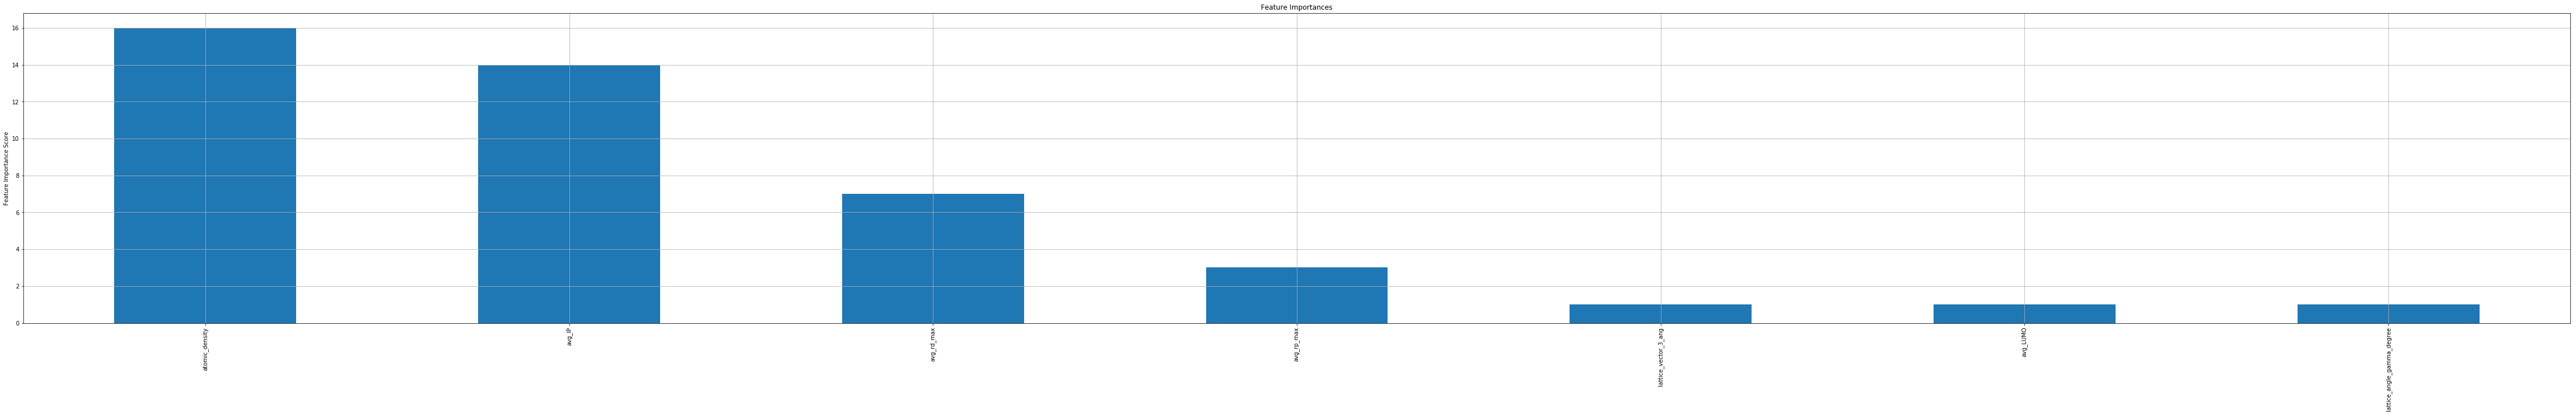

[Fold 4/5]
[0]	train-rmse:0.583249	valid-rmse:0.64517	train-rmsle:0.301232	valid-rmsle:0.332717
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.040969	valid-rmse:0.051003	train-rmsle:0.020748	valid-rmsle:0.023151
[200]	train-rmse:0.040972	valid-rmse:0.050929	train-rmsle:0.020782	valid-rmsle:0.023115
[300]	train-rmse:0.039785	valid-rmse:0.050867	train-rmsle:0.020186	valid-rmsle:0.023161
Stopping. Best iteration:
[205]	train-rmse:0.040977	valid-rmse:0.050863	train-rmsle:0.020816	valid-rmsle:0.023082

[Fold 4/5 Prediciton:]


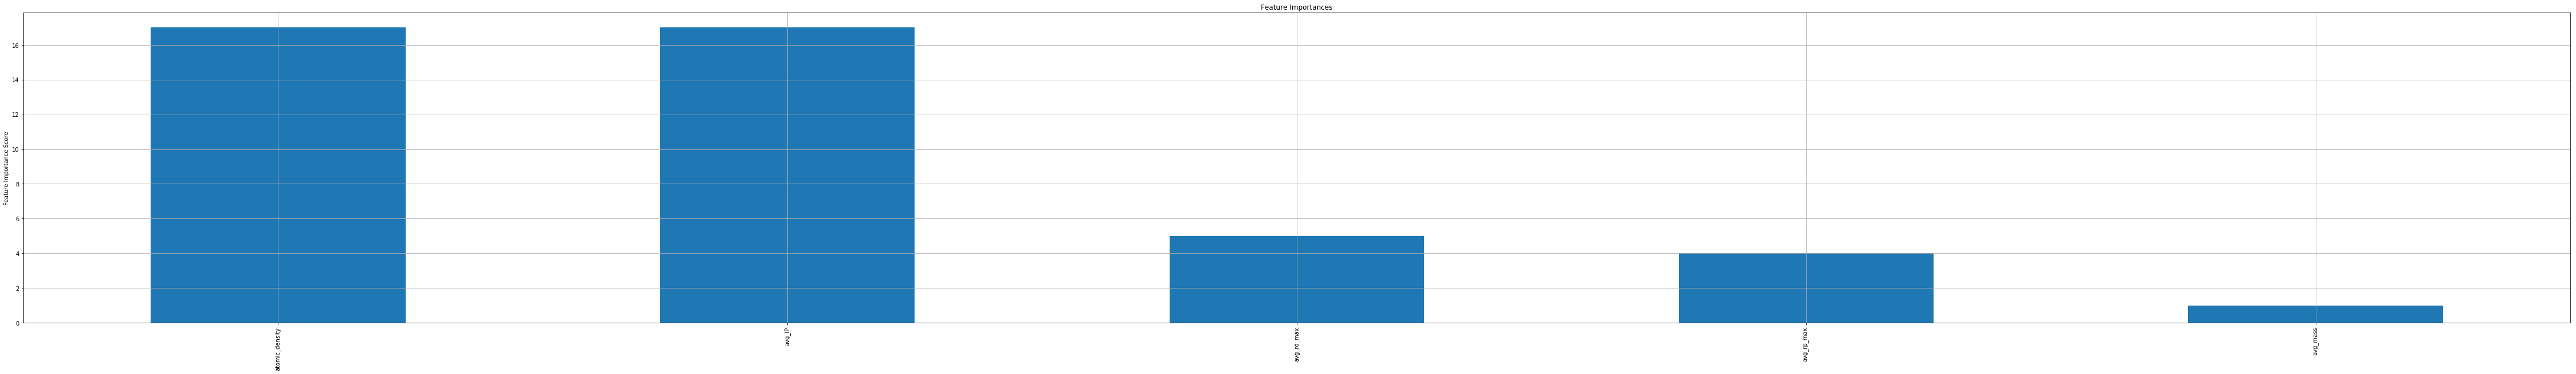

[Fold 5/5]
[0]	train-rmse:0.600067	valid-rmse:0.584095	train-rmsle:0.309259	valid-rmsle:0.304279
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.038644	valid-rmse:0.048532	train-rmsle:0.019613	valid-rmsle:0.022764
[200]	train-rmse:0.038645	valid-rmse:0.04858	train-rmsle:0.019556	valid-rmsle:0.022747
Stopping. Best iteration:
[175]	train-rmse:0.038663	valid-rmse:0.048667	train-rmsle:0.019478	valid-rmsle:0.022729

[Fold 5/5 Prediciton:]


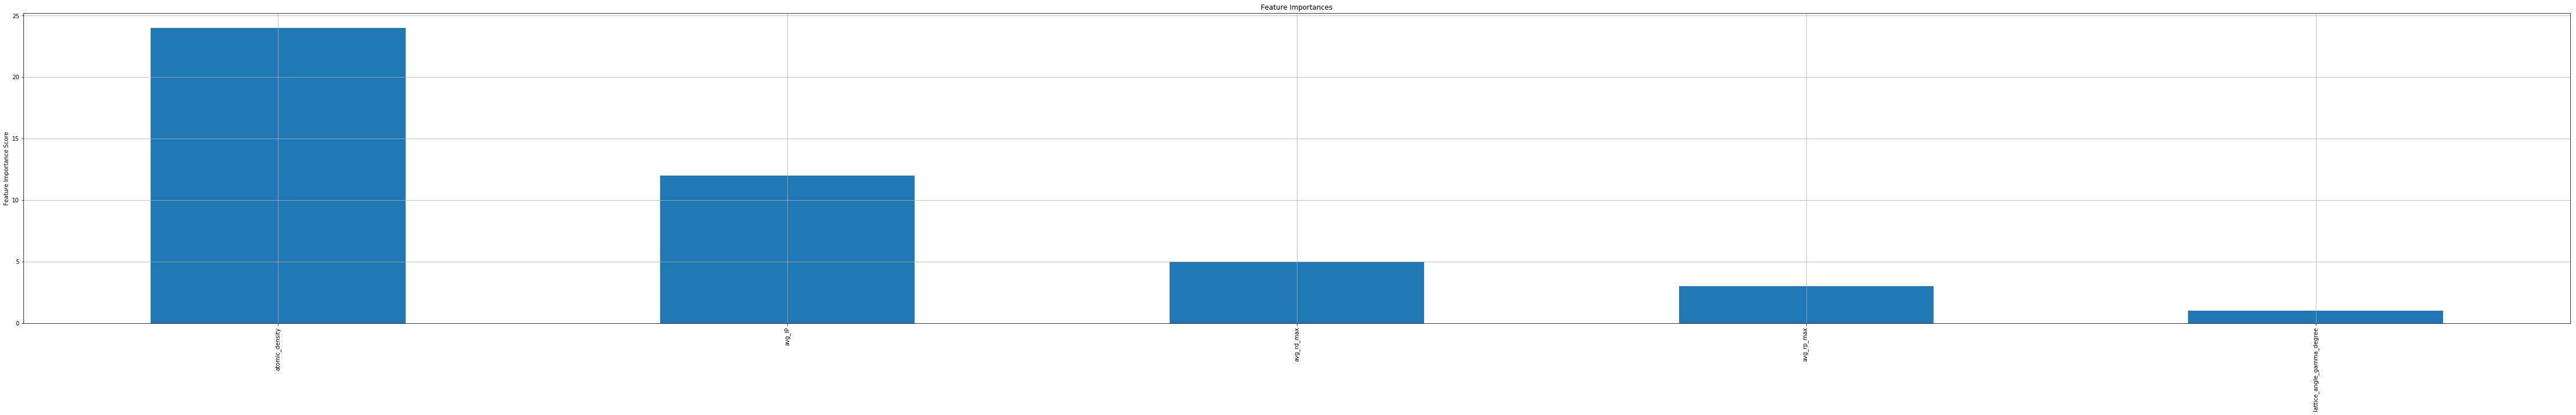

--------------------------------------
cluster: 8
--------------------------------------
[Fold 1/5]
[Fold 1/5 validation score: 0.027251956943908535]
[Fold 2/5]
[Fold 2/5 validation score: 0.029899550565644497]
[Fold 3/5]
[Fold 3/5 validation score: 0.028867552799948022]
[Fold 4/5]
[Fold 4/5 validation score: 0.02918119984067117]
[Fold 5/5]
[Fold 5/5 validation score: 0.02905118863148574]
--------------------------------------
cluster: 9
--------------------------------------
[Fold 1/5]
[0]	train-rmse:0.345788	valid-rmse:0.361579	train-rmsle:0.201397	valid-rmsle:0.209502
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.161508	valid-rmse:0.249243	train-rmsle:0.103974	valid-rmsle:0.157791
Stopping. Best iteration:
[5]	train-rmse:0.206183	valid-rmse:0.251764	train-rmsle:0.128123	valid-rmsle:0.155442

[Fold 1/5 Prediciton:]


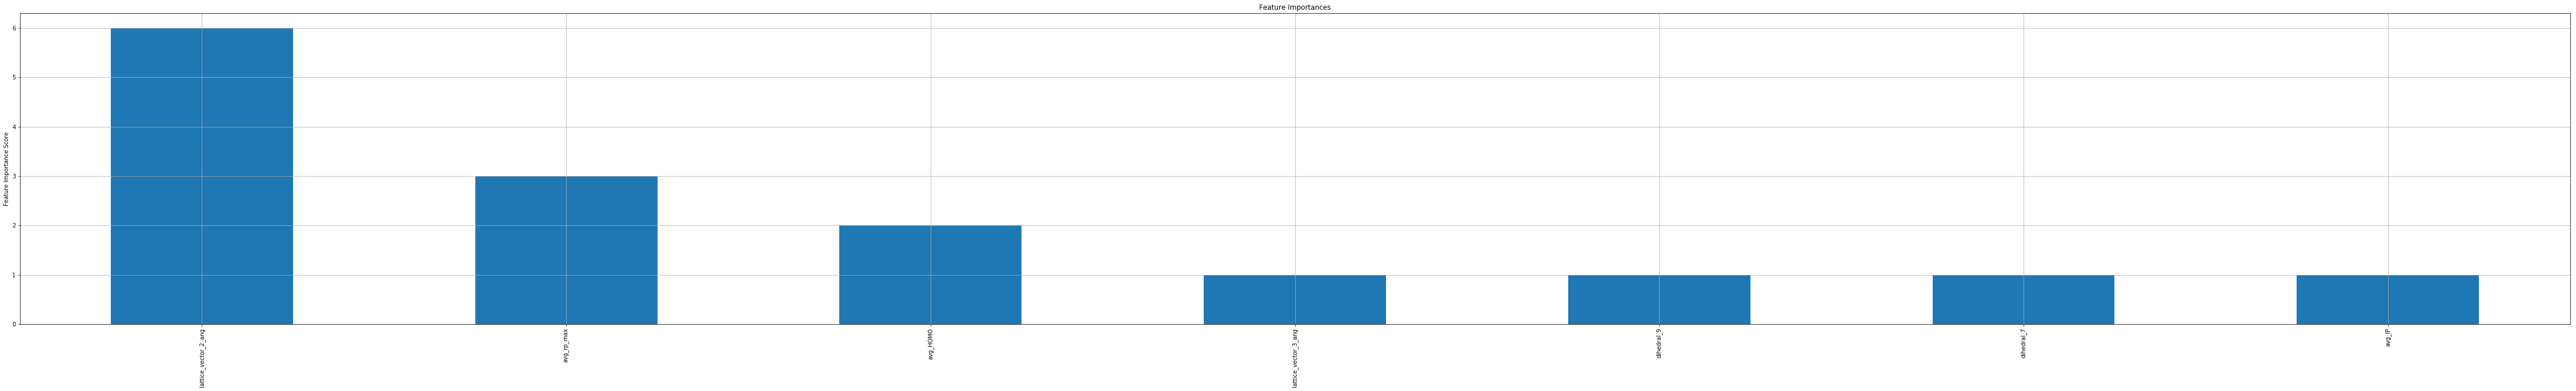

[Fold 2/5]
[0]	train-rmse:0.360648	valid-rmse:0.296132	train-rmsle:0.209762	valid-rmsle:0.176634
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.163542	valid-rmse:0.229326	train-rmsle:0.104384	valid-rmsle:0.14139
Stopping. Best iteration:
[7]	train-rmse:0.192947	valid-rmse:0.215759	train-rmsle:0.120821	valid-rmsle:0.133234

[Fold 2/5 Prediciton:]


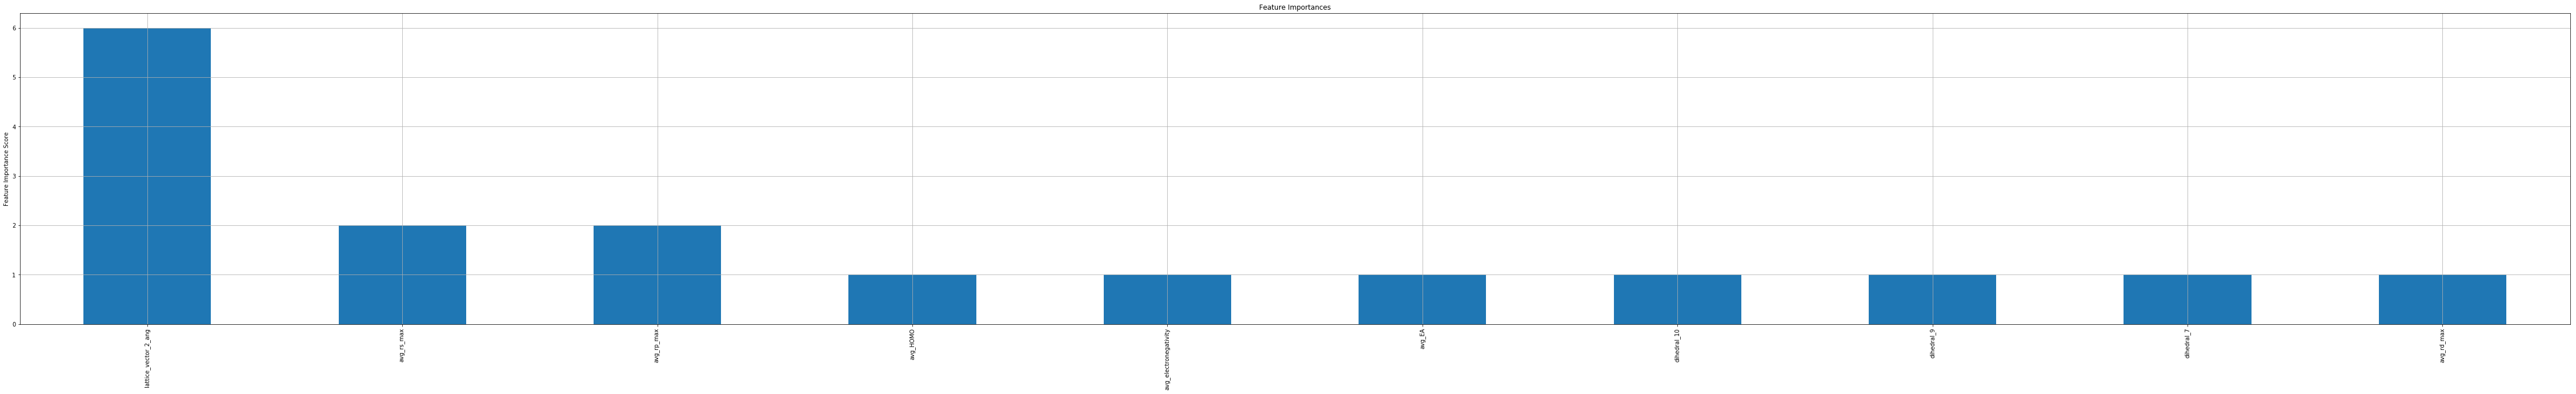

[Fold 3/5]
[0]	train-rmse:0.347991	valid-rmse:0.361388	train-rmsle:0.202387	valid-rmsle:0.213732
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.16916	valid-rmse:0.206572	train-rmsle:0.107409	valid-rmsle:0.132908
Stopping. Best iteration:
[63]	train-rmse:0.170652	valid-rmse:0.203272	train-rmsle:0.108964	valid-rmsle:0.131052

[Fold 3/5 Prediciton:]


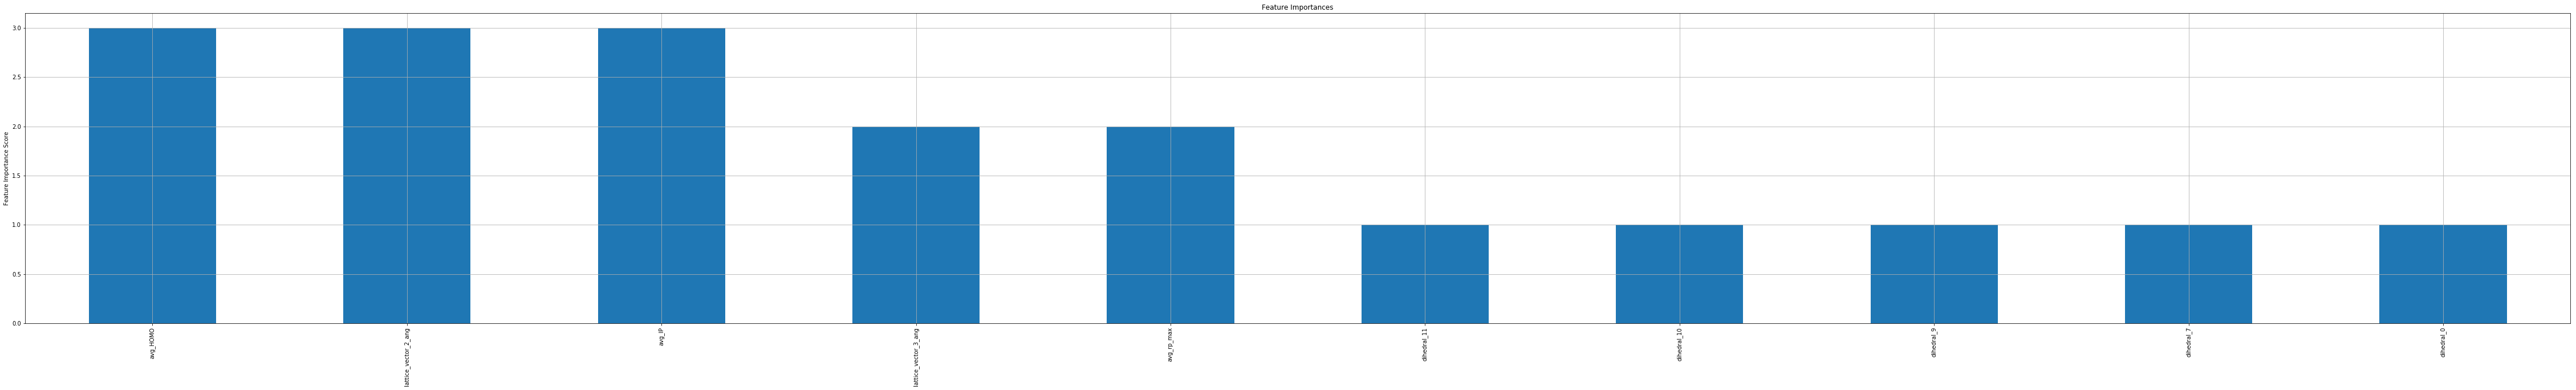

[Fold 4/5]
[0]	train-rmse:0.348086	valid-rmse:0.336806	train-rmsle:0.202565	valid-rmsle:0.197369
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.166317	valid-rmse:0.221988	train-rmsle:0.105509	valid-rmsle:0.141272
Stopping. Best iteration:
[44]	train-rmse:0.16642	valid-rmse:0.222023	train-rmsle:0.105361	valid-rmsle:0.141253

[Fold 4/5 Prediciton:]


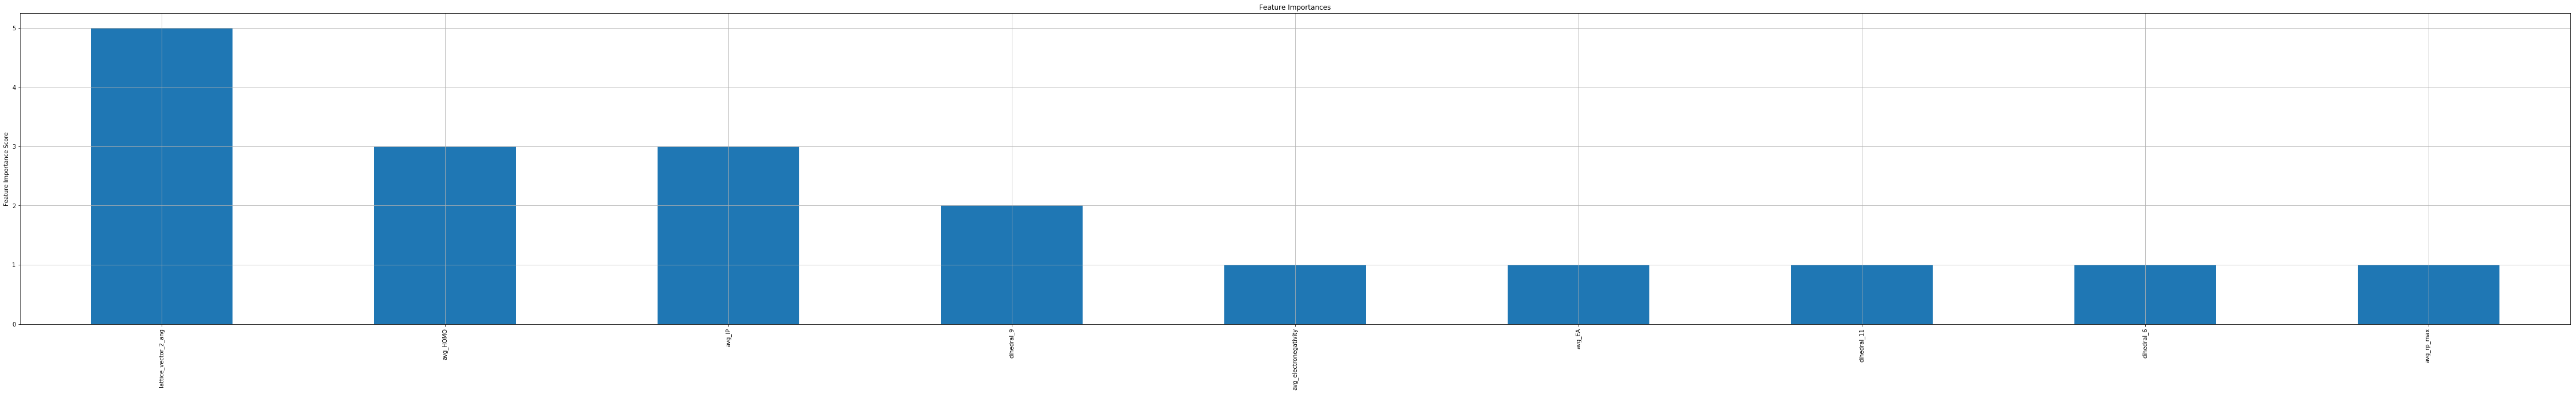

[Fold 5/5]
[0]	train-rmse:0.337407	valid-rmse:0.380236	train-rmsle:0.196805	valid-rmsle:0.220492
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.166053	valid-rmse:0.221872	train-rmsle:0.106082	valid-rmsle:0.135369
Stopping. Best iteration:
[92]	train-rmse:0.167999	valid-rmse:0.216469	train-rmsle:0.106887	valid-rmsle:0.132368

[Fold 5/5 Prediciton:]


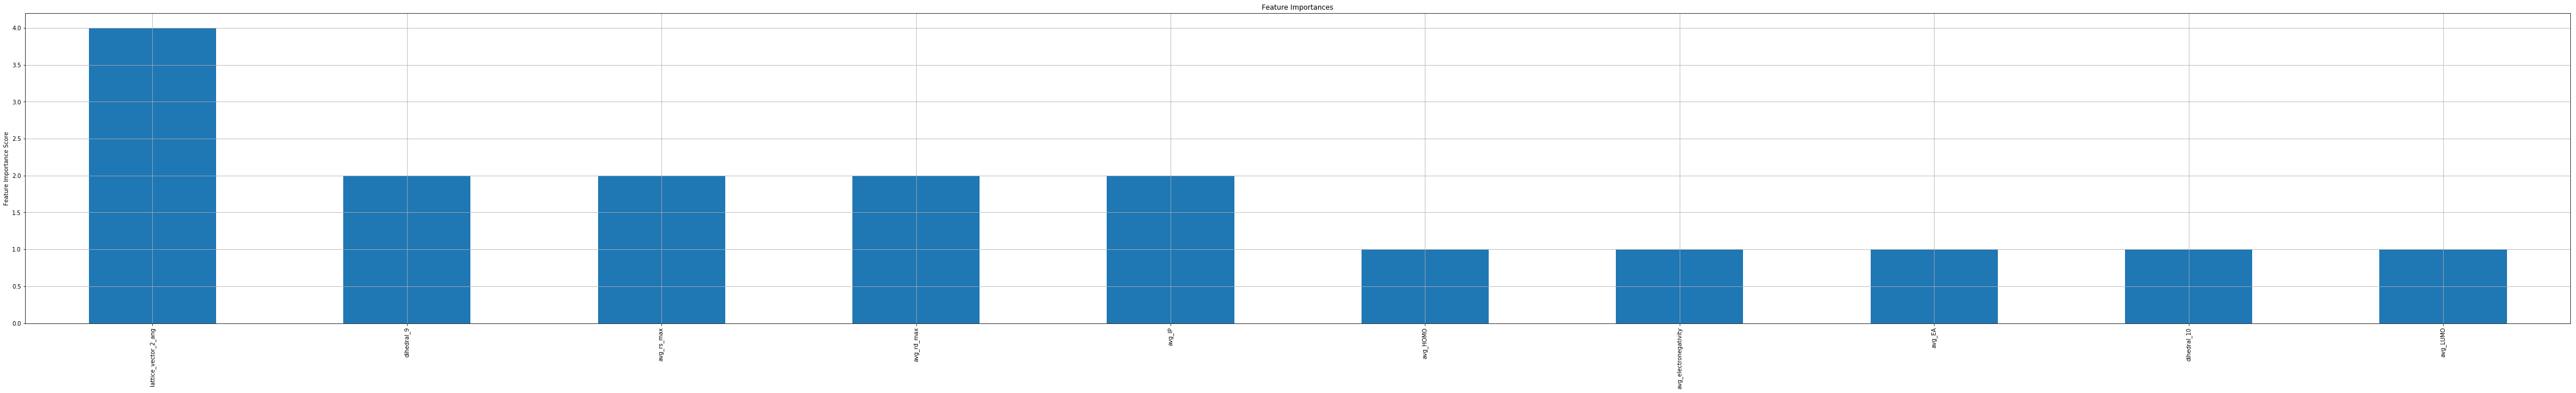

--------------------------------------
cluster: 10
--------------------------------------
[Fold 1/5]
[0]	train-rmse:0.540231	valid-rmse:0.694775	train-rmsle:0.28684	valid-rmsle:0.349303
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.181737	valid-rmse:0.275291	train-rmsle:0.105642	valid-rmsle:0.133223
[200]	train-rmse:0.184988	valid-rmse:0.29079	train-rmsle:0.105766	valid-rmsle:0.143783
[300]	train-rmse:0.181452	valid-rmse:0.286654	train-rmsle:0.105777	valid-rmsle:0.140934
Stopping. Best iteration:
[269]	train-rmse:0.182496	valid-rmse:0.237162	train-rmsle:0.107484	valid-rmsle:0.120102

[Fold 1/5 Prediciton:]


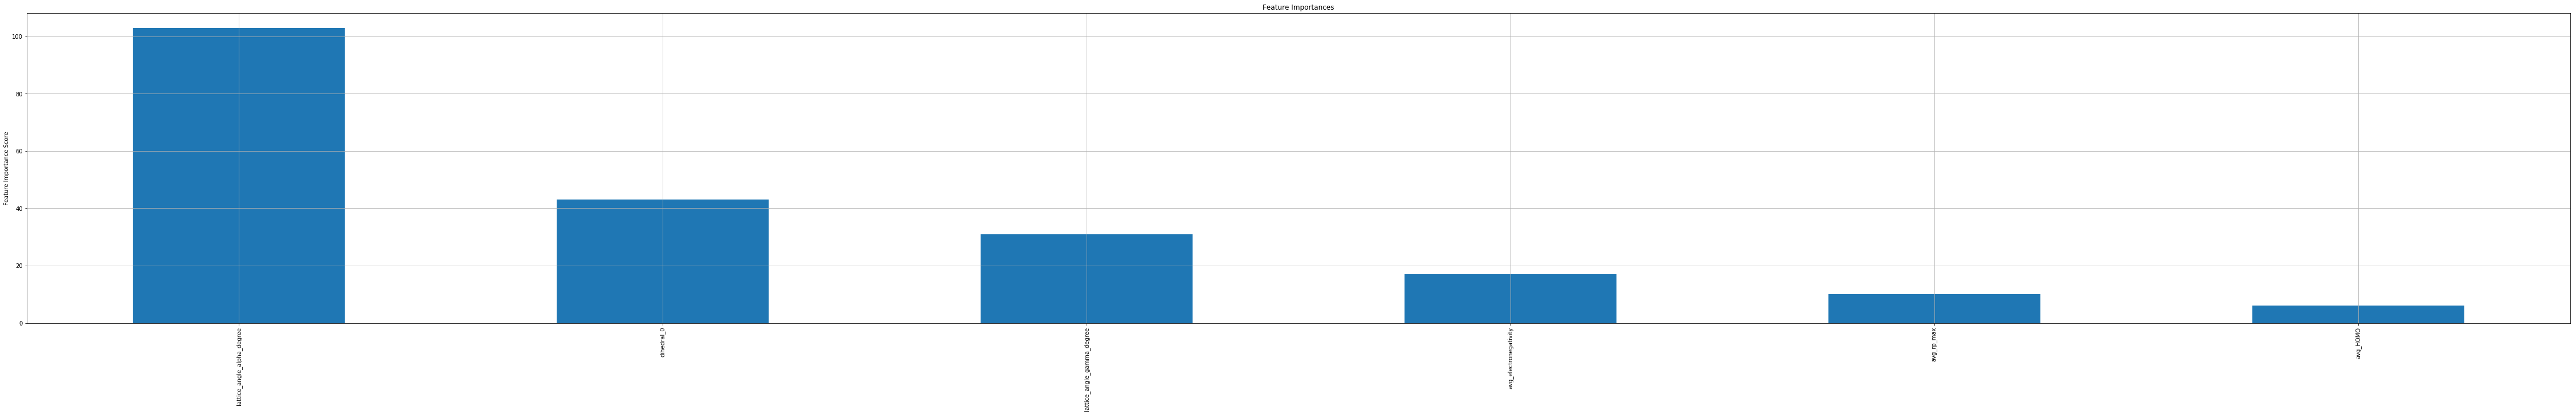

[Fold 2/5]
[0]	train-rmse:0.550137	valid-rmse:0.701886	train-rmsle:0.293113	valid-rmsle:0.353812
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.047822	valid-rmse:0.427889	train-rmsle:0.024057	valid-rmsle:0.240352
Stopping. Best iteration:
[35]	train-rmse:0.072742	valid-rmse:0.428906	train-rmsle:0.033889	valid-rmsle:0.237554

[Fold 2/5 Prediciton:]


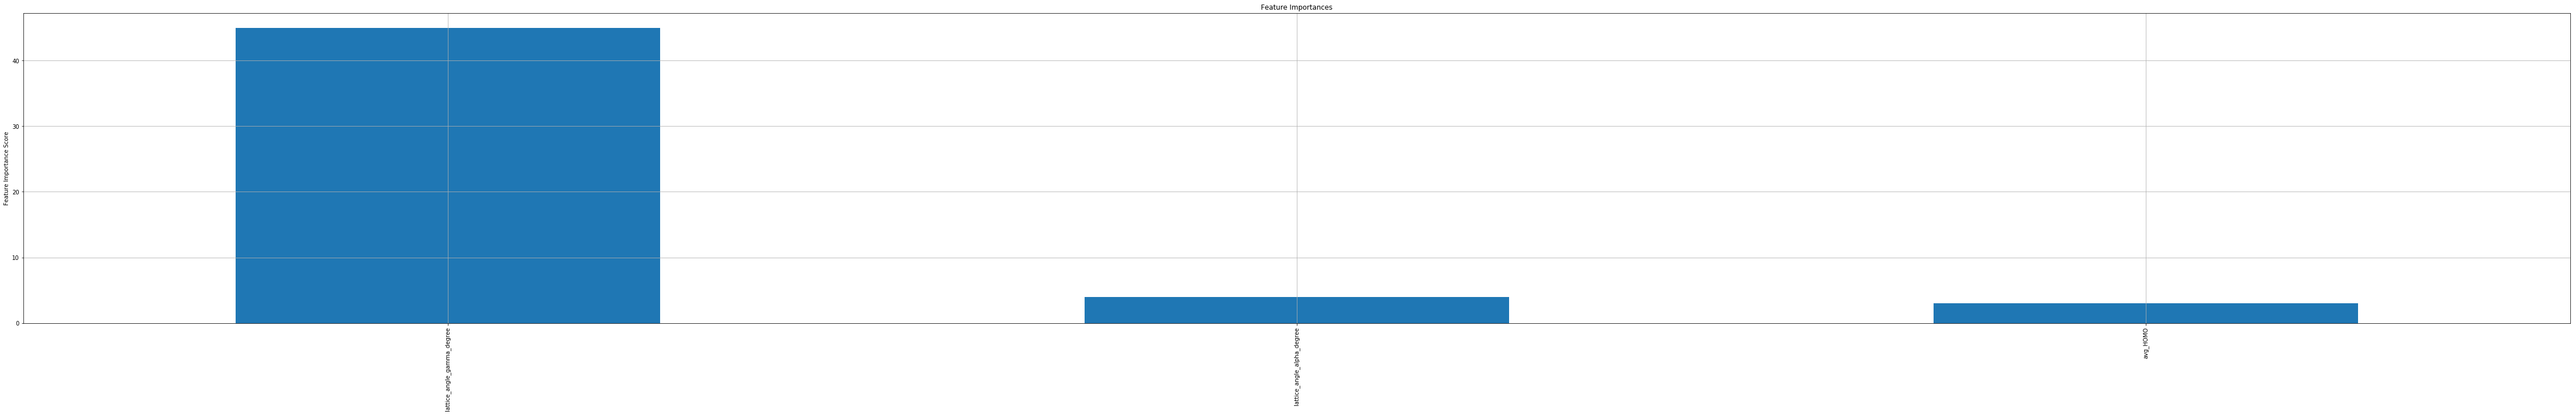

[Fold 3/5]
[0]	train-rmse:0.602496	valid-rmse:0.529959	train-rmsle:0.312768	valid-rmsle:0.286447
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.180194	valid-rmse:0.195086	train-rmsle:0.104919	valid-rmsle:0.10791
Stopping. Best iteration:
[25]	train-rmse:0.218821	valid-rmse:0.138695	train-rmsle:0.117669	valid-rmsle:0.07709

[Fold 3/5 Prediciton:]


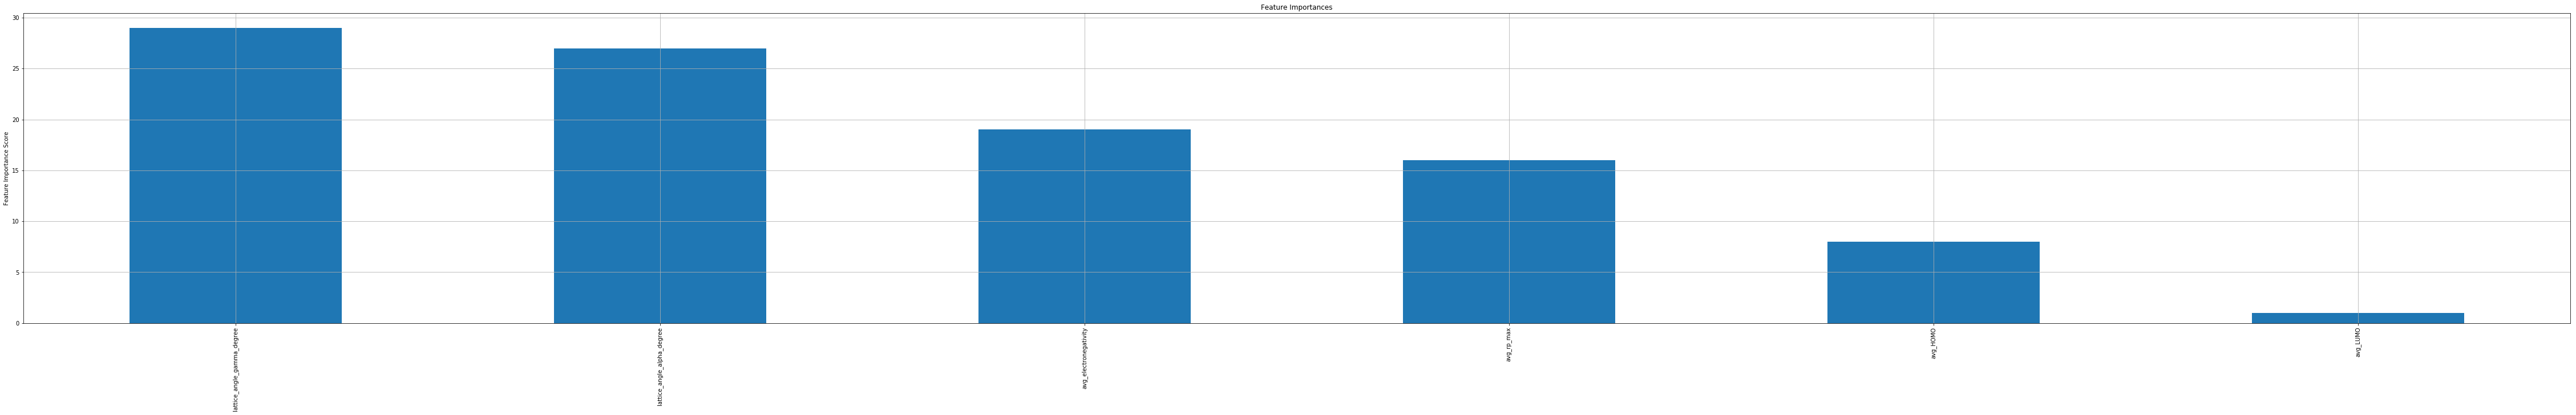

[Fold 4/5]
[0]	train-rmse:0.574408	valid-rmse:0.597612	train-rmsle:0.296447	valid-rmsle:0.321957
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.155529	valid-rmse:0.306782	train-rmsle:0.090076	valid-rmsle:0.161482
Stopping. Best iteration:
[34]	train-rmse:0.176116	valid-rmse:0.242411	train-rmsle:0.09847	valid-rmsle:0.125639

[Fold 4/5 Prediciton:]


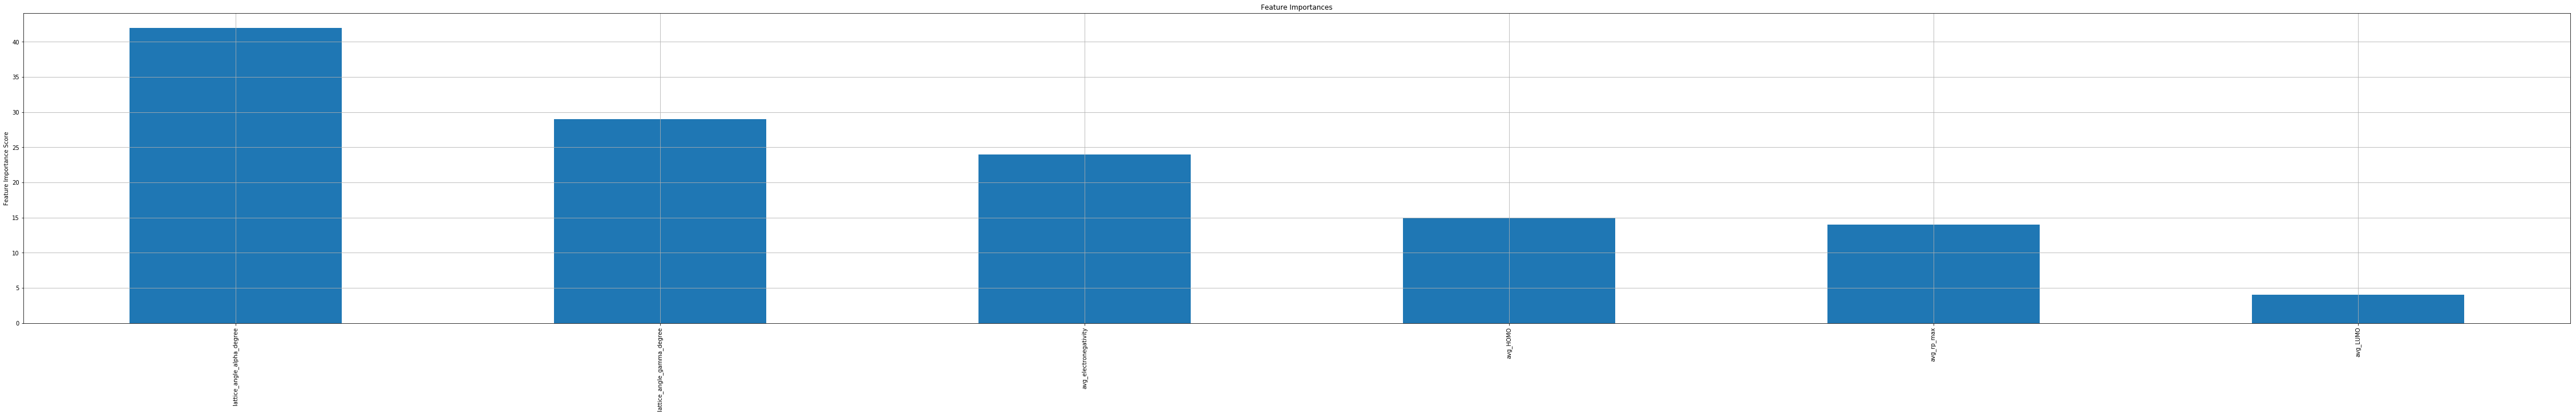

[Fold 5/5]
[0]	train-rmse:0.638167	valid-rmse:0.328667	train-rmsle:0.330856	valid-rmsle:0.185138
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 100 rounds.
[100]	train-rmse:0.050018	valid-rmse:0.432774	train-rmsle:0.025812	valid-rmsle:0.251504
Stopping. Best iteration:
[2]	train-rmse:0.545089	valid-rmse:0.294059	train-rmsle:0.272564	valid-rmsle:0.168355

[Fold 5/5 Prediciton:]


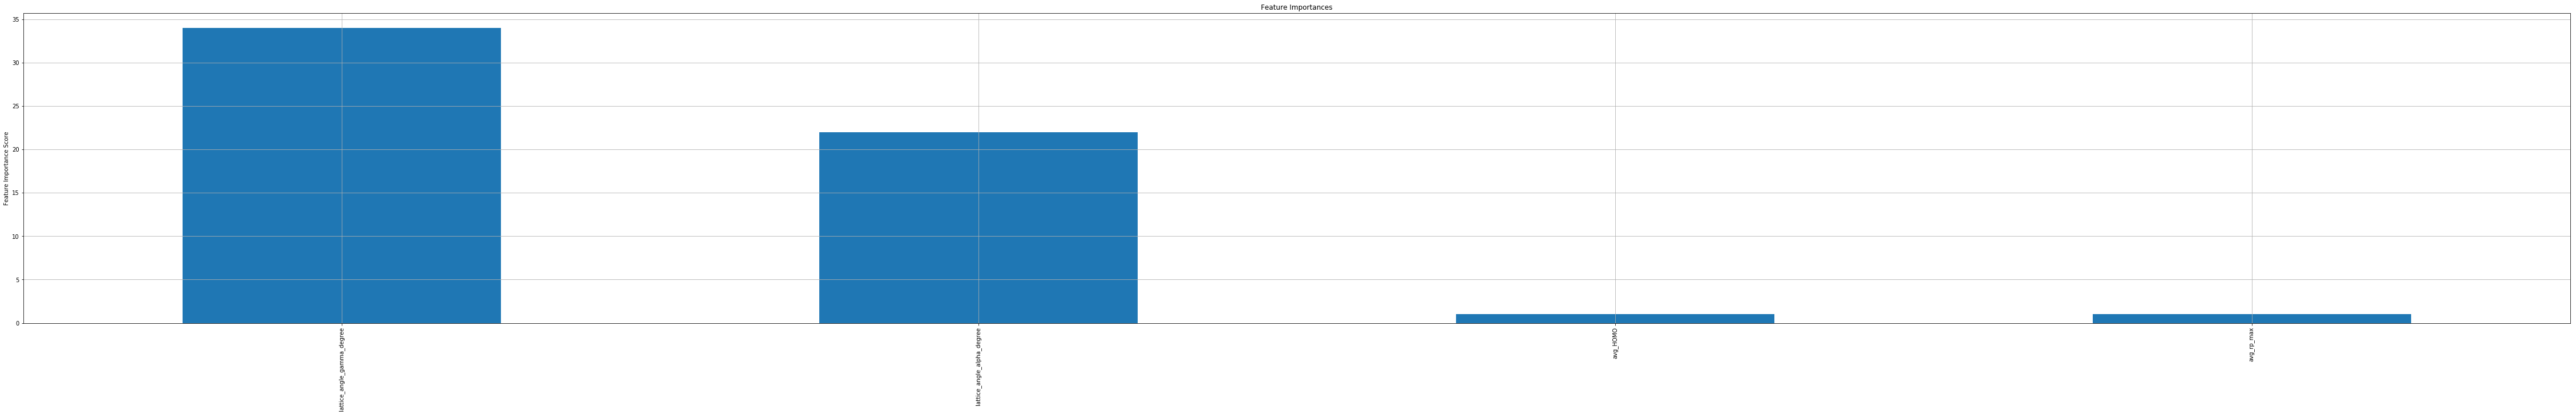


this took 36.071438789367676seconds


In [72]:
feat_list = ['lattice_angle_alpha_degree',
             'lattice_vector_1_ang',
             'lattice_vector_2_ang',
             'lattice_vector_3_ang']+dist_features+avg_features

features_be = ['lattice_angle_alpha_degree',
               'lattice_angle_gamma_degree',
               'number_of_total_atoms',
               'vol',
               'atomic_density',
               'lattice_vector_1_ang',
               'lattice_vector_2_ang',
               'lattice_vector_3_ang']+avg_features+percent_features+dist_features

sub['bandgap_energy_ev'] = np.zeros_like(test_id)

t = time.time()

kfold = 5
sscv = ShuffleSplit(n_splits=5, test_size=.2)

for cluster in range(11):
    print('--------------------------------------')
    print('cluster: '+str(cluster))
    print('--------------------------------------')
#     BE_features = FE_features#  ['lattice_angle_alpha_degree',
#                  'lattice_angle_gamma_degree',
#                  'number_of_total_atoms',
#                  'vol',
#                  'atomic_density',
#                  'lattice_vector_1_ang',
#                  'lattice_vector_2_ang',
#                  'lattice_vector_3_ang']+avg_features+percent_features+dist_features
    
    X_test_be = df_test[features_be].values

    X_train_be = df_train[features_be].values
    
    X = X_train_be[train_labels==cluster]
    y = np.log(df_train['bandgap_energy_ev'].values +1)[train_labels==cluster]
    X_test = X_test_be[test_labels==cluster]
#     y_m = y.max()
#     y=y/y.max()
    params = params_be[str(cluster)]
    
    for i, (train_index, test_index) in enumerate(sscv.split(X, y)):
        print('[Fold %d/%d]' % (i + 1, kfold))
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        
        if cluster ==8:
            regr = SVR(kernel='linear', gamma=7.2246246246246248e-06, C = 0.035065065065065064)
        
            # Train the model using the training sets
            regr.fit(X_train, y_train)

            # Predict on our test data
            y_predicted = regr.predict(X_valid)
            score = rmsle(y_predicted, y_valid)
            print('[Fold {}/{} validation score: {}]'.format(i + 1, kfold, score))

            # Make predictions using the testing set
            y_test = regr.predict(X_test)
            test_ids = test_id[test_labels==cluster]
            sub.loc[sub['id'].isin(test_ids),'bandgap_energy_ev'] += (np.exp(y_test)-1)/kfold
        
        elif cluster ==5:
            regr = SVR(kernel='linear', gamma=  0.0047657657657657658, C =0.0012972972972972972)
        
            # Train the model using the training sets
            regr.fit(X_train, y_train)

            # Predict on our test data
            y_predicted = regr.predict(X_valid)
            score = rmsle(y_predicted, y_valid)
            print('[Fold {}/{} validation score: {}]'.format(i + 1, kfold, score))

            # Make predictions using the testing set
            y_test = regr.predict(X_test)
            test_ids = test_id[test_labels==cluster]
            sub.loc[sub['id'].isin(test_ids),'bandgap_energy_ev'] += (np.exp(y_test)-1)/kfold
        
        else:
            # Convert our data into XGBoost format
            d_train = xgb.DMatrix(X_train, y_train)
            d_valid = xgb.DMatrix(X_valid, y_valid)
            d_test = xgb.DMatrix(X_test)
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]

            # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
            # and the custom metric (maximize=True tells xgb that higher metric is better)
            mdl = xgb.train(params,
                            d_train,
                            1600,
                            watchlist,
                            early_stopping_rounds=100,
                            feval=rmsle_xgb,
                            maximize=False,
                            verbose_eval=100)

            print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
            # Predict on our test data

            p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
            test_ids=test_id[test_labels==cluster]
            #sub.loc[sub['id'].isin(test_ids),'bandgap_energy_ev'] += ((np.exp(p_test*y_m)-1)/kfold)
            #p_test = scaler_be.inverse_transform(p_test.reshape(-1, 1)).flatten()
            sub.loc[sub['id'].isin(test_ids),'bandgap_energy_ev'] += ((np.exp(p_test)-1)/kfold)
    
            feat_imp = pd.Series(mdl.get_fscore()).sort_values(ascending=False)
            feat_imp.rename(index={i:FE_features[int(i[1:])] for i in feat_imp.index.tolist()}, inplace=True)
            feat_imp.plot(kind='bar', title='Feature Importances', figsize=(80,10))
            plt.ylabel('Feature Importance Score')
            plt.grid()
            plt.show()

    
print()
print('this took {}seconds'.format(time.time()-t))

In [73]:
train_clusters = [(i,sum(train_labels==i)) for i in range(11)]

In [74]:
dist_clusters = [(i,sum(test_labels==i)) for i in range(11)]

In [75]:
dist_clusters,train_clusters

([(0, 77),
  (1, 83),
  (2, 48),
  (3, 73),
  (4, 126),
  (5, 27),
  (6, 14),
  (7, 30),
  (8, 70),
  (9, 45),
  (10, 7)],
 [(0, 306),
  (1, 340),
  (2, 247),
  (3, 326),
  (4, 490),
  (5, 84),
  (6, 48),
  (7, 126),
  (8, 274),
  (9, 146),
  (10, 13)])

In [56]:
sub.head()

,id,formation_energy_ev_natom,bandgap_energy_ev
0,1,0.203081,1.603470
1,2,0.064903,3.703852
2,3,0.155089,3.405904
3,4,0.030561,2.902494
4,5,0.136344,1.680934


In [57]:
sub.id = sub.id.astype('Int32')
sub.to_csv('../output/jan10_predictions.csv', index=False)

In [58]:
sample_df = pd.read_csv('../output/sample.csv')

In [59]:
sample_df.head()

,id,formation_energy_ev_natom,bandgap_energy_ev
0,1,0.192000,1.515015
1,2,0.071637,3.868475
2,3,0.164172,3.557467
3,4,0.030110,2.978686
4,5,0.133663,1.561450


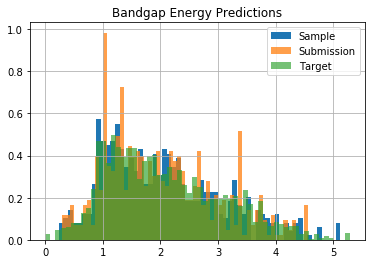

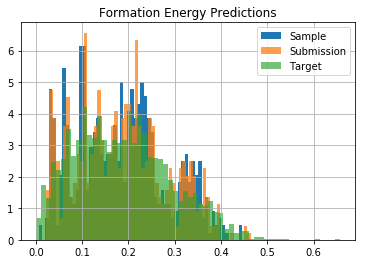

In [60]:


sample_df.bandgap_energy_ev.hist(label='Sample', alpha=1,bins=60, normed=True)
sub.bandgap_energy_ev.hist(label='Submission', alpha=0.75,bins=60, normed=True)
df_train['bandgap_energy_ev'].hist(label='Target', alpha=0.65,bins=60, normed=True)
plt.title('Bandgap Energy Predictions')
plt.legend()
plt.show()

sample_df.formation_energy_ev_natom.hist(label='Sample', alpha=1,bins=60, normed=True)
sub.formation_energy_ev_natom.hist(label='Submission', alpha=0.75,bins=60, normed=True)
df_train['formation_energy_ev_natom'].hist(label='Target', alpha=0.65,bins=60, normed=True)
plt.title('Formation Energy Predictions')
plt.legend()
plt.show()

